In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy

from utils.compl_cal import compl_mul, compl_div
from utils.PINNnet import sine_init, first_layer_sine_init, PINN
from utils.plot_func import plot_field, model_pred, plot_error_field, plot_loss

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
device

'cuda'

In [3]:
# fixed parameters
L, N = 1, 100
Lx, Ly = L, L
src = [-0.4, 0.5]
k = 2 * np.pi * 20 / 1500 * 100

In [4]:
## hyperparameter
w = 100
n_in = 2 
n_out = 2
n_hiddens = 256
n_layers = 5
n_epochs = int(1e2)
learning_rate = 2e-5

In [5]:
def loss_grad_norm(loss, model):
    loss_grad_norm = 0
    loss_clone = loss.clone()
    for params in model.parameters():
        loss_grad = torch.autograd.grad(loss_clone, params, retain_graph=True, allow_unused=True, materialize_grads=True)[0]
        loss_grad_norm += torch.sum(loss_grad**2)
    loss_grad_norm = loss_grad_norm**0.5
    loss_grad_norm = loss_grad_norm.detach()
    return loss_grad_norm

def update_lambda(model, loss_lst, lamb_lst, alpha):
    grad = []
    for loss in loss_lst:
        grad.append(loss_grad_norm(loss, model))
    grad_sum = sum(grad)
    lamb = []
    for i in range(len(grad)):
        lamb_hat = grad_sum / grad[i]
        if torch.isnan(lamb_hat) or torch.isinf(lamb_hat):
            lamb_hat = torch.ones_like(lamb_hat)
        lamb_new = alpha*lamb_lst[i] + (1-alpha)*lamb_hat
        lamb.append(lamb_new)
    return lamb

In [6]:
## Dataset

def get_dataset(Lx, Ly, src, std=0.01, device=device):
    # pde
    x0, y0 = 2 * Lx * torch.rand(100000, 1) - Lx, 2 * Ly * torch.rand(100000, 1) - Ly
    r, theta = torch.linspace(0, 2.5, 500), torch.linspace(0, 2 * np.pi, 360)
    r, theta = torch.meshgrid(r, theta)
    r, theta = r.reshape(-1, 1), theta.reshape(-1, 1)
    x, y = r * torch.cos(theta) + src[0], r * torch.sin(theta) + src[1]
    x_min, x_max = -Lx, Lx
    y_min, y_max = -Ly, Ly
    mask = (x >= x_min) & (x <= x_max) & (y >= y_min) & (y <= y_max)
    x, y = x[mask].reshape(-1, 1), y[mask].reshape(-1, 1)
    x0[-len(x):, :], y0[-len(x):, :] = x, y
    f = 1 / (2 * np.pi * std ** 2) * torch.exp(-0.5 * (((x0 - src[0])/std)**2 + ((y0 - src[1])/std)**2))
    f = torch.cat([f, torch.zeros_like(f)], dim=-1)
    return torch.tensor(x0, dtype=torch.float32, requires_grad=False).to(device),\
            torch.tensor(y0, dtype=torch.float32, requires_grad=False).to(device),\
             f.to(device)

def data_iter(batch_size, x, y, f):
    import random as rd
    num = len(f)
    ids = list(range(num))
    rd.shuffle(ids)
    for i in range(0, num, batch_size):
        batch_id = torch.tensor(ids[i:min(i + batch_size, num)])
        yield x[batch_id], y[batch_id], f[batch_id]

In [7]:
def get_PML_coefficient(x, y, L_pml, sigma0):
    dist_hor = torch.clamp(torch.abs(x) - (Lx - L_pml), min=0)
    dist_ver = torch.clamp(- y - (Lx - L_pml), min=0)
    sx = sigma0 * (dist_hor / L_pml) ** 2
    sy = sigma0 * (dist_ver / L_pml) ** 2
    ex = torch.cat([torch.ones_like(sx), sx], dim=-1)
    ey = torch.cat([torch.ones_like(sy), sy], dim=-1)
    return ex, ey

def loss_fn(model, x, y, src, k, f, L_pml=0.3, sigma0=3.5):
    x, y = x.reshape(-1, 1).to(device), y.reshape(-1, 1).to(device)
    x, y = x.requires_grad_(), y.requires_grad_()
    ex, ey = get_PML_coefficient(x, y, L_pml, sigma0)
    xy = torch.cat([x, y], dim=-1)
    p = model(xy)
    px_real = torch.autograd.grad(p[:, 0:1], x, torch.ones_like(p[:, 0:1]), create_graph=True)[0]
    px_imag = torch.autograd.grad(p[:, 1:2], x, torch.ones_like(p[:, 1:2]), create_graph=True)[0]
    px = compl_mul(compl_div(ey, ex), torch.cat([px_real, px_imag], dim=-1))
    pxx_real = torch.autograd.grad(px[:, 0:1], x, torch.ones_like(px[:, 0:1]), create_graph=True)[0]
    pxx_imag = torch.autograd.grad(px[:, 1:2], x, torch.ones_like(px[:, 1:2]), create_graph=True)[0]
    pxx = torch.cat([pxx_real, pxx_imag], dim=-1)
    py_real = torch.autograd.grad(p[:, 0:1], y, torch.ones_like(p[:, 0:1]), create_graph=True)[0]
    py_imag = torch.autograd.grad(p[:, 1:2], y, torch.ones_like(p[:, 1:2]), create_graph=True)[0]
    py = compl_mul(compl_div(ex, ey), torch.cat([py_real, py_imag], dim=-1))
    pyy_real = torch.autograd.grad(py[:, 0:1], y, torch.ones_like(py[:, 0:1]), create_graph=True)[0]
    pyy_imag = torch.autograd.grad(py[:, 1:2], y, torch.ones_like(py[:, 1:2]), create_graph=True)[0]
    pyy = torch.cat([pyy_real, pyy_imag], dim=-1)
    
    res = pxx + pyy + k**2 * compl_mul(compl_mul(ex, ey), p) - f
    del pyy, pxx
    return (res ** 2).mean()

def loss_bd(model, Lx, Ly, device=device):
    x, y = torch.linspace(-Lx, Lx, 500), torch.ones(500)
    #y[:int(y.shape[0] / 2)] = -y[:int(x.shape[0] / 2)]
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    x = torch.tensor(x, dtype=torch.float32, requires_grad=True).to(device)
    y = torch.tensor(y, dtype=torch.float32, requires_grad=True).to(device)
    xy = torch.cat([x, y], dim=-1)
    p = model(xy)
    return (p ** 2).mean()

In [8]:
new_train = True
if new_train:
    model = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
    model.apply(sine_init)
    model.net[0].apply(first_layer_sine_init)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    lamb = [1, 1]
    l_lst = []
    n_lamb_update = 50
else:
    import joblib
    state_dict = joblib.load('model_batches.joblib')
    model = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
    model.load_state_dict(state_dict)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    lamb = [1, 1]
    l_lst = []
    n_lamb_update = 50

In [9]:
n_epochs = int(5e3)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

In [10]:
x0, y0, f0 = get_dataset(Lx, Ly, src)
i = 0
loss_min = 2
model = model.to(device)
for epoch in tqdm(range(n_epochs)):
    if epoch == 1000:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    if epoch == 3000:
        optimizer = torch.optim.Adam(model.parameters(), lr=5e-6)
    if epoch == 4000:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
    for x, y, f in data_iter(10000, x0, y0, f0):
        optimizer.zero_grad()
        loss_pde = loss_fn(model, x, y, src, k, f, L_pml=0.5, sigma0=3.5)
        loss_bound = loss_bd(model, Lx, Ly)
        if i % 50 == 0:
            loss_lst = [loss_pde, loss_bound]
            lamb = update_lambda(model, loss_lst, lamb, 0.9)
        loss = loss_pde + loss_bound * lamb[1] / lamb[0]
        loss.backward()
        optimizer.step()
        i = i + 1
    
    if (epoch + 1) % 5 == 0: 
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Loss_pde: {loss_pde.item()}, Loss_bound: {loss_bound.item()}')
    if loss_min > loss.item():
        loss_min = loss.item()
        model0 = model
    l_lst.append(loss)

/home/zhufanjie/miniconda3/envs/work/lib/python3.11/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_9385/1648869101.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x0, dtype=torch.float32, requires_grad=False).to(device),\
/tmp/ipykernel_9385/1648869101.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y0, dtype=torch.float32, requires_grad=False).to(device),\
/tmp/ipykernel_9385/735888669.py:

Epoch 5, Loss: 78.63427734375, Loss_pde: 77.23714447021484, Loss_bound: 0.00010928735719062388


  0%|          | 10/5000 [00:18<2:25:15,  1.75s/it]

Epoch 10, Loss: 29.74493980407715, Loss_pde: 29.51724624633789, Loss_bound: 7.344020104937954e-06


  0%|          | 15/5000 [00:27<2:25:16,  1.75s/it]

Epoch 15, Loss: 17.30742645263672, Loss_pde: 17.214475631713867, Loss_bound: 9.23692994092562e-07


  0%|          | 20/5000 [00:36<2:25:42,  1.76s/it]

Epoch 20, Loss: 12.197553634643555, Loss_pde: 12.15230941772461, Loss_bound: 1.233849928894415e-07


  0%|          | 25/5000 [00:45<2:25:57,  1.76s/it]

Epoch 25, Loss: 9.797545433044434, Loss_pde: 9.705249786376953, Loss_bound: 1.0761274182868874e-07


  1%|          | 30/5000 [00:54<2:26:13,  1.77s/it]

Epoch 30, Loss: 8.442239761352539, Loss_pde: 8.119305610656738, Loss_bound: 2.2359175488873007e-07


  1%|          | 35/5000 [01:04<2:28:16,  1.79s/it]

Epoch 35, Loss: 7.37852144241333, Loss_pde: 7.35344123840332, Loss_bound: 1.8062801032669995e-08


  1%|          | 40/5000 [01:13<2:28:49,  1.80s/it]

Epoch 40, Loss: 14.071659088134766, Loss_pde: 10.683874130249023, Loss_bound: 1.4806450963078532e-06


  1%|          | 45/5000 [01:23<2:30:14,  1.82s/it]

Epoch 45, Loss: 6.602619647979736, Loss_pde: 6.573161602020264, Loss_bound: 1.3528853592958967e-08


  1%|          | 50/5000 [01:32<2:31:35,  1.84s/it]

Epoch 50, Loss: 4.950845241546631, Loss_pde: 4.924474716186523, Loss_bound: 7.22079729342795e-09


  1%|          | 55/5000 [01:42<2:34:34,  1.88s/it]

Epoch 55, Loss: 4.722423553466797, Loss_pde: 4.677721977233887, Loss_bound: 1.0948304485225435e-08


  1%|          | 60/5000 [01:52<2:35:28,  1.89s/it]

Epoch 60, Loss: 124.61639404296875, Loss_pde: 118.51140594482422, Loss_bound: 1.6247561234195018e-06


  1%|▏         | 65/5000 [02:02<2:35:32,  1.89s/it]

Epoch 65, Loss: 7.098424434661865, Loss_pde: 6.994183540344238, Loss_bound: 2.8920586814251692e-08


  1%|▏         | 70/5000 [02:12<2:35:45,  1.90s/it]

Epoch 70, Loss: 4.0363993644714355, Loss_pde: 3.953021764755249, Loss_bound: 1.6015167858540735e-08


  2%|▏         | 75/5000 [02:22<2:39:50,  1.95s/it]

Epoch 75, Loss: 3.427842617034912, Loss_pde: 3.408005475997925, Loss_bound: 4.075404458347975e-09


  2%|▏         | 80/5000 [02:32<2:40:19,  1.96s/it]

Epoch 80, Loss: 19.04833221435547, Loss_pde: 11.884078025817871, Loss_bound: 1.0023161394201452e-06


  2%|▏         | 85/5000 [02:42<2:35:24,  1.90s/it]

Epoch 85, Loss: 5.200507164001465, Loss_pde: 5.0913519859313965, Loss_bound: 1.5637594330542015e-08


  2%|▏         | 90/5000 [02:52<2:40:56,  1.97s/it]

Epoch 90, Loss: 4.123236179351807, Loss_pde: 4.0877275466918945, Loss_bound: 5.263256941390182e-09


  2%|▏         | 95/5000 [03:02<2:42:18,  1.99s/it]

Epoch 95, Loss: 3.6206629276275635, Loss_pde: 3.5900464057922363, Loss_bound: 3.56446006044564e-09


  2%|▏         | 100/5000 [03:13<2:41:44,  1.98s/it]

Epoch 100, Loss: 12.031661987304688, Loss_pde: 4.876530647277832, Loss_bound: 5.023432549933204e-07


  2%|▏         | 105/5000 [03:23<2:39:18,  1.95s/it]

Epoch 105, Loss: 3.5394842624664307, Loss_pde: 3.4812839031219482, Loss_bound: 4.416640386750714e-09


  2%|▏         | 110/5000 [03:33<2:37:05,  1.93s/it]

Epoch 110, Loss: 3.1145832538604736, Loss_pde: 3.088528871536255, Loss_bound: 2.0440535930532633e-09


  2%|▏         | 115/5000 [03:43<2:37:08,  1.93s/it]

Epoch 115, Loss: 2.9037671089172363, Loss_pde: 2.883319854736328, Loss_bound: 1.6108866462971605e-09


  2%|▏         | 120/5000 [03:53<2:41:32,  1.99s/it]

Epoch 120, Loss: 2.769359827041626, Loss_pde: 2.748887062072754, Loss_bound: 1.2692615847242905e-09


  2%|▎         | 125/5000 [04:04<2:42:53,  2.00s/it]

Epoch 125, Loss: 2.7657783031463623, Loss_pde: 2.745279550552368, Loss_bound: 1.2502484603160724e-09


  3%|▎         | 130/5000 [04:14<2:42:41,  2.00s/it]

Epoch 130, Loss: 40.87059020996094, Loss_pde: 18.171358108520508, Loss_bound: 9.085054557544936e-07


  3%|▎         | 135/5000 [04:25<2:42:53,  2.01s/it]

Epoch 135, Loss: 7.448469638824463, Loss_pde: 7.237734794616699, Loss_bound: 9.048686244739201e-09


  3%|▎         | 140/5000 [04:35<2:42:46,  2.01s/it]

Epoch 140, Loss: 5.116221904754639, Loss_pde: 5.045006275177002, Loss_bound: 3.1813194301122394e-09


  3%|▎         | 145/5000 [04:46<2:42:18,  2.01s/it]

Epoch 145, Loss: 4.380734443664551, Loss_pde: 4.329306125640869, Loss_bound: 2.124687092930344e-09


  3%|▎         | 150/5000 [04:56<2:41:59,  2.00s/it]

Epoch 150, Loss: 3.704029083251953, Loss_pde: 3.6600310802459717, Loss_bound: 1.567561191961886e-09


  3%|▎         | 155/5000 [05:06<2:41:38,  2.00s/it]

Epoch 155, Loss: 3.4064674377441406, Loss_pde: 3.3702471256256104, Loss_bound: 1.232311364063321e-09


  3%|▎         | 160/5000 [05:17<2:41:10,  2.00s/it]

Epoch 160, Loss: 3.1787991523742676, Loss_pde: 3.1499125957489014, Loss_bound: 1.0418891305263855e-09


  3%|▎         | 165/5000 [05:27<2:41:20,  2.00s/it]

Epoch 165, Loss: 2.986802101135254, Loss_pde: 2.960200309753418, Loss_bound: 8.563399989114373e-10


  3%|▎         | 170/5000 [05:38<2:41:21,  2.00s/it]

Epoch 170, Loss: 2.858919382095337, Loss_pde: 2.8326256275177, Loss_bound: 7.345623553867142e-10


  4%|▎         | 175/5000 [05:48<2:41:04,  2.00s/it]

Epoch 175, Loss: 8.326013565063477, Loss_pde: 2.739356279373169, Loss_bound: 1.5068415848418226e-07


  4%|▎         | 180/5000 [05:59<2:40:57,  2.00s/it]

Epoch 180, Loss: 2.576733350753784, Loss_pde: 2.5466578006744385, Loss_bound: 9.001435707922667e-10


  4%|▎         | 185/5000 [06:09<2:41:08,  2.01s/it]

Epoch 185, Loss: 2.460810899734497, Loss_pde: 2.4444148540496826, Loss_bound: 5.393543944798296e-10


  4%|▍         | 190/5000 [06:19<2:40:43,  2.00s/it]

Epoch 190, Loss: 2.4232826232910156, Loss_pde: 2.407836437225342, Loss_bound: 5.502956978986617e-10


  4%|▍         | 195/5000 [06:30<2:40:36,  2.01s/it]

Epoch 195, Loss: 2.331843852996826, Loss_pde: 2.319486141204834, Loss_bound: 4.388444052594309e-10


  4%|▍         | 200/5000 [06:40<2:40:22,  2.00s/it]

Epoch 200, Loss: 2.2413110733032227, Loss_pde: 2.2192883491516113, Loss_bound: 7.196803153419751e-10


  4%|▍         | 205/5000 [06:51<2:40:39,  2.01s/it]

Epoch 205, Loss: 2.202787160873413, Loss_pde: 2.1920459270477295, Loss_bound: 3.7312664069588664e-10


  4%|▍         | 210/5000 [07:01<2:39:58,  2.00s/it]

Epoch 210, Loss: 12.839544296264648, Loss_pde: 7.161097526550293, Loss_bound: 1.5144460974170215e-07


  4%|▍         | 215/5000 [07:11<2:39:43,  2.00s/it]

Epoch 215, Loss: 6.980827808380127, Loss_pde: 6.765674114227295, Loss_bound: 5.870510300098886e-09


  4%|▍         | 220/5000 [07:22<2:39:42,  2.00s/it]

Epoch 220, Loss: 2.7692127227783203, Loss_pde: 2.7354440689086914, Loss_bound: 9.177515969405192e-10


  4%|▍         | 225/5000 [07:32<2:39:21,  2.00s/it]

Epoch 225, Loss: 5.281397819519043, Loss_pde: 2.416879892349243, Loss_bound: 6.816294728650973e-08


  5%|▍         | 230/5000 [07:43<2:39:21,  2.00s/it]

Epoch 230, Loss: 2.1769464015960693, Loss_pde: 2.1580984592437744, Loss_bound: 4.977924739080208e-10


  5%|▍         | 235/5000 [07:53<2:39:09,  2.00s/it]

Epoch 235, Loss: 2.1457064151763916, Loss_pde: 2.1293652057647705, Loss_bound: 3.885405885917237e-10


  5%|▍         | 240/5000 [08:04<2:38:56,  2.00s/it]

Epoch 240, Loss: 2.111677885055542, Loss_pde: 2.0372726917266846, Loss_bound: 1.5938850239649582e-09


  5%|▍         | 245/5000 [08:14<2:38:49,  2.00s/it]

Epoch 245, Loss: 1.9563677310943604, Loss_pde: 1.9387972354888916, Loss_bound: 4.129125097396269e-10


  5%|▌         | 250/5000 [08:24<2:38:56,  2.01s/it]

Epoch 250, Loss: 65.90338897705078, Loss_pde: 2.0061826705932617, Loss_bound: 1.432163799108821e-06


  5%|▌         | 255/5000 [08:35<2:38:29,  2.00s/it]

Epoch 255, Loss: 4.500536918640137, Loss_pde: 3.1799652576446533, Loss_bound: 3.284797145397533e-08


  5%|▌         | 260/5000 [08:45<2:38:08,  2.00s/it]

Epoch 260, Loss: 2.377450942993164, Loss_pde: 2.282026529312134, Loss_bound: 2.3059498754918195e-09


  5%|▌         | 265/5000 [08:56<2:38:15,  2.01s/it]

Epoch 265, Loss: 1.9206444025039673, Loss_pde: 1.8929049968719482, Loss_bound: 6.708441024905198e-10


  5%|▌         | 270/5000 [09:06<2:37:51,  2.00s/it]

Epoch 270, Loss: 1.7700341939926147, Loss_pde: 1.7628816366195679, Loss_bound: 1.8504039966948937e-10


  6%|▌         | 275/5000 [09:16<2:37:49,  2.00s/it]

Epoch 275, Loss: 5.454770088195801, Loss_pde: 4.022787570953369, Loss_bound: 3.080064203686561e-08


  6%|▌         | 280/5000 [09:27<2:37:51,  2.01s/it]

Epoch 280, Loss: 5.318112850189209, Loss_pde: 4.559925556182861, Loss_bound: 1.763503831853086e-08


  6%|▌         | 285/5000 [09:37<2:37:45,  2.01s/it]

Epoch 285, Loss: 2.1051900386810303, Loss_pde: 2.021293878555298, Loss_bound: 1.943734062592739e-09


  6%|▌         | 290/5000 [09:48<2:37:39,  2.01s/it]

Epoch 290, Loss: 4.134410381317139, Loss_pde: 2.533168077468872, Loss_bound: 3.352043620452605e-08


  6%|▌         | 295/5000 [09:58<2:37:34,  2.01s/it]

Epoch 295, Loss: 1.8336267471313477, Loss_pde: 1.8085505962371826, Loss_bound: 5.803081348787487e-10


  6%|▌         | 300/5000 [10:09<2:37:18,  2.01s/it]

Epoch 300, Loss: 2.1604108810424805, Loss_pde: 2.119980812072754, Loss_bound: 9.696730085551053e-10


  6%|▌         | 305/5000 [10:19<2:36:16,  2.00s/it]

Epoch 305, Loss: 1.703836441040039, Loss_pde: 1.6817716360092163, Loss_bound: 4.515663121207325e-10


  6%|▌         | 310/5000 [10:29<2:36:46,  2.01s/it]

Epoch 310, Loss: 27.425338745117188, Loss_pde: 17.785480499267578, Loss_bound: 1.7874091895464517e-07


  6%|▋         | 315/5000 [10:40<2:37:03,  2.01s/it]

Epoch 315, Loss: 2.5550801753997803, Loss_pde: 2.398580551147461, Loss_bound: 3.0646947202228603e-09


  6%|▋         | 320/5000 [10:50<2:37:04,  2.01s/it]

Epoch 320, Loss: 2.9802825450897217, Loss_pde: 2.5790200233459473, Loss_bound: 7.72178854191452e-09


  6%|▋         | 325/5000 [11:01<2:36:03,  2.00s/it]

Epoch 325, Loss: 2.716947555541992, Loss_pde: 2.653876304626465, Loss_bound: 1.2707030982994638e-09


  7%|▋         | 330/5000 [11:11<2:35:58,  2.00s/it]

Epoch 330, Loss: 1.6064656972885132, Loss_pde: 1.592453122138977, Loss_bound: 2.928383091571618e-10


  7%|▋         | 335/5000 [11:22<2:35:48,  2.00s/it]

Epoch 335, Loss: 1.512702465057373, Loss_pde: 1.5040149688720703, Loss_bound: 1.956027007032901e-10


  7%|▋         | 340/5000 [11:32<2:35:37,  2.00s/it]

Epoch 340, Loss: 1.5081192255020142, Loss_pde: 1.49905264377594, Loss_bound: 2.033497537023976e-10


  7%|▋         | 345/5000 [11:42<2:35:33,  2.01s/it]

Epoch 345, Loss: 1.5399194955825806, Loss_pde: 1.5312775373458862, Loss_bound: 2.0247808985018878e-10


  7%|▋         | 350/5000 [11:53<2:35:04,  2.00s/it]

Epoch 350, Loss: 1.8290557861328125, Loss_pde: 1.7658976316452026, Loss_bound: 1.3566217038629702e-09


  7%|▋         | 355/5000 [12:03<2:34:51,  2.00s/it]

Epoch 355, Loss: 87.67617797851562, Loss_pde: 84.47664642333984, Loss_bound: 7.112393518582394e-08


  7%|▋         | 360/5000 [12:14<2:34:50,  2.00s/it]

Epoch 360, Loss: 9.335033416748047, Loss_pde: 8.50571060180664, Loss_bound: 1.9040669485548278e-08


  7%|▋         | 365/5000 [12:24<2:34:41,  2.00s/it]

Epoch 365, Loss: 2.741952896118164, Loss_pde: 2.0329582691192627, Loss_bound: 1.628473711434708e-08


  7%|▋         | 370/5000 [12:34<2:34:30,  2.00s/it]

Epoch 370, Loss: 1.8633577823638916, Loss_pde: 1.7474337816238403, Loss_bound: 2.6530346808328886e-09


  8%|▊         | 375/5000 [12:45<2:34:36,  2.01s/it]

Epoch 375, Loss: 1.461511492729187, Loss_pde: 1.4458602666854858, Loss_bound: 3.832164030548313e-10


  8%|▊         | 380/5000 [12:55<2:34:08,  2.00s/it]

Epoch 380, Loss: 4.7081193923950195, Loss_pde: 1.9931608438491821, Loss_bound: 5.491774501820146e-08


  8%|▊         | 385/5000 [13:06<2:33:54,  2.00s/it]

Epoch 385, Loss: 1.4749644994735718, Loss_pde: 1.4510003328323364, Loss_bound: 5.235510358581053e-10


  8%|▊         | 390/5000 [13:16<2:33:41,  2.00s/it]

Epoch 390, Loss: 1.3453871011734009, Loss_pde: 1.3366694450378418, Loss_bound: 1.7262441476262325e-10


  8%|▊         | 395/5000 [13:27<2:33:50,  2.00s/it]

Epoch 395, Loss: 1.32378351688385, Loss_pde: 1.3172773122787476, Loss_bound: 1.3911549689993308e-10


  8%|▊         | 400/5000 [13:37<2:33:34,  2.00s/it]

Epoch 400, Loss: 4.428305625915527, Loss_pde: 1.293831467628479, Loss_bound: 6.522591888824536e-08


  8%|▊         | 405/5000 [13:47<2:33:18,  2.00s/it]

Epoch 405, Loss: 1.2872095108032227, Loss_pde: 1.2718521356582642, Loss_bound: 3.547247218183003e-10


  8%|▊         | 410/5000 [13:58<2:32:55,  2.00s/it]

Epoch 410, Loss: 1.2515664100646973, Loss_pde: 1.2468348741531372, Loss_bound: 1.202193206095714e-10


  8%|▊         | 415/5000 [14:08<2:32:45,  2.00s/it]

Epoch 415, Loss: 1.3237650394439697, Loss_pde: 1.3144546747207642, Loss_bound: 2.470685878108725e-10


  8%|▊         | 420/5000 [14:19<2:32:57,  2.00s/it]

Epoch 420, Loss: 1.219544768333435, Loss_pde: 1.2015219926834106, Loss_bound: 4.800059794085598e-10


  8%|▊         | 425/5000 [14:29<2:32:56,  2.01s/it]

Epoch 425, Loss: 1.3634922504425049, Loss_pde: 1.3436579704284668, Loss_bound: 5.40672784321572e-10


  9%|▊         | 430/5000 [14:39<2:33:44,  2.02s/it]

Epoch 430, Loss: 8.661885261535645, Loss_pde: 7.338165283203125, Loss_bound: 3.71939705701152e-08


  9%|▊         | 435/5000 [14:50<2:32:26,  2.00s/it]

Epoch 435, Loss: 1.9228029251098633, Loss_pde: 1.8171542882919312, Loss_bound: 3.04492586700178e-09


  9%|▉         | 440/5000 [15:00<2:32:23,  2.01s/it]

Epoch 440, Loss: 11.315183639526367, Loss_pde: 11.02820873260498, Loss_bound: 7.5438419955276e-09


  9%|▉         | 445/5000 [15:11<2:32:15,  2.01s/it]

Epoch 445, Loss: 361.00396728515625, Loss_pde: 124.70379638671875, Loss_bound: 5.202993179409532e-06


  9%|▉         | 450/5000 [15:21<2:32:28,  2.01s/it]

Epoch 450, Loss: 52.0316047668457, Loss_pde: 50.44214630126953, Loss_bound: 3.861016395489969e-08


  9%|▉         | 455/5000 [15:32<2:31:31,  2.00s/it]

Epoch 455, Loss: 34.44862365722656, Loss_pde: 34.22444152832031, Loss_bound: 5.844666972620871e-09


  9%|▉         | 460/5000 [15:42<2:31:36,  2.00s/it]

Epoch 460, Loss: 25.11412811279297, Loss_pde: 24.972896575927734, Loss_bound: 3.686300376060103e-09


  9%|▉         | 465/5000 [15:52<2:31:19,  2.00s/it]

Epoch 465, Loss: 20.321563720703125, Loss_pde: 20.205799102783203, Loss_bound: 2.5782274093444357e-09


  9%|▉         | 470/5000 [16:03<2:31:02,  2.00s/it]

Epoch 470, Loss: 16.681028366088867, Loss_pde: 16.580245971679688, Loss_bound: 1.902363155892317e-09


 10%|▉         | 475/5000 [16:13<2:31:05,  2.00s/it]

Epoch 475, Loss: 14.7164306640625, Loss_pde: 14.620049476623535, Loss_bound: 1.4024547079216632e-09


 10%|▉         | 480/5000 [16:24<2:30:22,  2.00s/it]

Epoch 480, Loss: 51.981624603271484, Loss_pde: 14.950169563293457, Loss_bound: 4.5210850885268883e-07


 10%|▉         | 485/5000 [16:34<2:32:03,  2.02s/it]

Epoch 485, Loss: 12.095935821533203, Loss_pde: 11.86862564086914, Loss_bound: 3.0691069685673256e-09


 10%|▉         | 490/5000 [16:45<2:32:01,  2.02s/it]

Epoch 490, Loss: 10.649317741394043, Loss_pde: 10.584301948547363, Loss_bound: 9.61256629850027e-10


 10%|▉         | 495/5000 [16:55<2:31:50,  2.02s/it]

Epoch 495, Loss: 9.55361557006836, Loss_pde: 9.500649452209473, Loss_bound: 7.890659237119735e-10


 10%|█         | 500/5000 [17:06<2:30:48,  2.01s/it]

Epoch 500, Loss: 8.835628509521484, Loss_pde: 8.78201961517334, Loss_bound: 6.508210081968002e-10


 10%|█         | 505/5000 [17:16<2:30:40,  2.01s/it]

Epoch 505, Loss: 28.208362579345703, Loss_pde: 11.056068420410156, Loss_bound: 1.6722037798899692e-07


 10%|█         | 510/5000 [17:26<2:30:56,  2.02s/it]

Epoch 510, Loss: 8.544962882995605, Loss_pde: 8.360504150390625, Loss_bound: 1.995784870700845e-09


 10%|█         | 515/5000 [17:37<2:30:45,  2.02s/it]

Epoch 515, Loss: 7.73878812789917, Loss_pde: 7.683191776275635, Loss_bound: 6.597646318162731e-10


 10%|█         | 520/5000 [17:47<2:30:23,  2.01s/it]

Epoch 520, Loss: 6.956332683563232, Loss_pde: 6.910055160522461, Loss_bound: 5.143002135277186e-10


 10%|█         | 525/5000 [17:58<2:30:03,  2.01s/it]

Epoch 525, Loss: 6.575937271118164, Loss_pde: 6.530971527099609, Loss_bound: 4.238764617081614e-10


 11%|█         | 530/5000 [18:08<2:30:09,  2.02s/it]

Epoch 530, Loss: 6.073046684265137, Loss_pde: 6.027716159820557, Loss_bound: 3.5373870499455506e-10


 11%|█         | 535/5000 [18:19<2:29:35,  2.01s/it]

Epoch 535, Loss: 16.65985870361328, Loss_pde: 5.780065536499023, Loss_bound: 8.26607475801211e-08


 11%|█         | 540/5000 [18:29<2:29:24,  2.01s/it]

Epoch 540, Loss: 5.943676471710205, Loss_pde: 5.528609275817871, Loss_bound: 3.5034741774353506e-09


 11%|█         | 545/5000 [18:40<2:29:23,  2.01s/it]

Epoch 545, Loss: 5.192743301391602, Loss_pde: 5.161518096923828, Loss_bound: 2.9181673744105296e-10


 11%|█         | 550/5000 [18:50<2:29:19,  2.01s/it]

Epoch 550, Loss: 4.96132230758667, Loss_pde: 4.936097621917725, Loss_bound: 2.508797614098057e-10


 11%|█         | 555/5000 [19:01<2:28:52,  2.01s/it]

Epoch 555, Loss: 4.6452860832214355, Loss_pde: 4.619687557220459, Loss_bound: 2.334436532969164e-10


 11%|█         | 560/5000 [19:11<2:28:46,  2.01s/it]

Epoch 560, Loss: 4.562139987945557, Loss_pde: 4.534543037414551, Loss_bound: 2.0757755236910924e-10


 11%|█▏        | 565/5000 [19:22<2:28:42,  2.01s/it]

Epoch 565, Loss: 22.734119415283203, Loss_pde: 4.756125450134277, Loss_bound: 1.290819540145094e-07


 11%|█▏        | 570/5000 [19:32<2:28:36,  2.01s/it]

Epoch 570, Loss: 4.578378200531006, Loss_pde: 4.464548110961914, Loss_bound: 9.076257523332742e-10


 12%|█▏        | 575/5000 [19:42<2:28:31,  2.01s/it]

Epoch 575, Loss: 4.139394283294678, Loss_pde: 4.113800048828125, Loss_bound: 2.258238873675822e-10


 12%|█▏        | 580/5000 [19:53<2:28:19,  2.01s/it]

Epoch 580, Loss: 3.929826498031616, Loss_pde: 3.9059979915618896, Loss_bound: 1.9525661643093883e-10


 12%|█▏        | 585/5000 [20:03<2:28:40,  2.02s/it]

Epoch 585, Loss: 3.811843156814575, Loss_pde: 3.789820909500122, Loss_bound: 1.799364823806826e-10


 12%|█▏        | 590/5000 [20:14<2:27:56,  2.01s/it]

Epoch 590, Loss: 5.153904438018799, Loss_pde: 3.5488686561584473, Loss_bound: 1.1985478387543935e-08


 12%|█▏        | 595/5000 [20:24<2:27:42,  2.01s/it]

Epoch 595, Loss: 3.4936275482177734, Loss_pde: 3.4740710258483887, Loss_bound: 1.6214013465187804e-10


 12%|█▏        | 600/5000 [20:35<2:27:52,  2.02s/it]

Epoch 600, Loss: 3.3819282054901123, Loss_pde: 3.36550235748291, Loss_bound: 1.4836061545953072e-10


 12%|█▏        | 605/5000 [20:45<2:27:32,  2.01s/it]

Epoch 605, Loss: 24.06241226196289, Loss_pde: 4.3743696212768555, Loss_bound: 1.494052810357971e-07


 12%|█▏        | 610/5000 [20:56<2:27:16,  2.01s/it]

Epoch 610, Loss: 3.632749080657959, Loss_pde: 3.528073310852051, Loss_bound: 8.813597074386337e-10


 12%|█▏        | 615/5000 [21:06<2:27:04,  2.01s/it]

Epoch 615, Loss: 3.3471744060516357, Loss_pde: 3.322791337966919, Loss_bound: 2.247700914281836e-10


 12%|█▏        | 620/5000 [21:17<2:26:54,  2.01s/it]

Epoch 620, Loss: 3.159252882003784, Loss_pde: 3.13948655128479, Loss_bound: 1.8587099914757488e-10


 12%|█▎        | 625/5000 [21:27<2:26:59,  2.02s/it]

Epoch 625, Loss: 3.0027761459350586, Loss_pde: 2.984410524368286, Loss_bound: 1.6539977720775312e-10


 13%|█▎        | 630/5000 [21:38<2:26:56,  2.02s/it]

Epoch 630, Loss: 3.0237364768981934, Loss_pde: 3.002467393875122, Loss_bound: 1.624567147473499e-10


 13%|█▎        | 635/5000 [21:48<2:26:46,  2.02s/it]

Epoch 635, Loss: 2.925102472305298, Loss_pde: 2.9058516025543213, Loss_bound: 1.5146944809529828e-10


 13%|█▎        | 640/5000 [21:59<2:26:35,  2.02s/it]

Epoch 640, Loss: 17.589441299438477, Loss_pde: 3.153503179550171, Loss_bound: 1.111065230929853e-07


 13%|█▎        | 645/5000 [22:09<2:26:14,  2.01s/it]

Epoch 645, Loss: 2.9610447883605957, Loss_pde: 2.862297296524048, Loss_bound: 8.438297838253561e-10


 13%|█▎        | 650/5000 [22:19<2:26:11,  2.02s/it]

Epoch 650, Loss: 2.771775960922241, Loss_pde: 2.7573633193969727, Loss_bound: 1.3582508728848808e-10


 13%|█▎        | 655/5000 [22:30<2:27:11,  2.03s/it]

Epoch 655, Loss: 2.6461641788482666, Loss_pde: 2.6337642669677734, Loss_bound: 1.168562469011647e-10


 13%|█▎        | 660/5000 [22:41<2:27:28,  2.04s/it]

Epoch 660, Loss: 2.6137781143188477, Loss_pde: 2.5982284545898438, Loss_bound: 1.2590974096671204e-10


 13%|█▎        | 665/5000 [22:51<2:26:08,  2.02s/it]

Epoch 665, Loss: 2.5063817501068115, Loss_pde: 2.4931304454803467, Loss_bound: 1.0810928541271636e-10


 13%|█▎        | 670/5000 [23:02<2:25:41,  2.02s/it]

Epoch 670, Loss: 2.4876856803894043, Loss_pde: 2.4751296043395996, Loss_bound: 1.067243307617538e-10


 14%|█▎        | 675/5000 [23:12<2:25:12,  2.01s/it]

Epoch 675, Loss: 2.510810375213623, Loss_pde: 2.4936084747314453, Loss_bound: 1.4677500881354888e-10


 14%|█▎        | 680/5000 [23:23<2:28:10,  2.06s/it]

Epoch 680, Loss: 7.549284934997559, Loss_pde: 2.871269941329956, Loss_bound: 3.8166817262208497e-08


 14%|█▎        | 685/5000 [23:34<2:25:51,  2.03s/it]

Epoch 685, Loss: 2.450852870941162, Loss_pde: 2.420487880706787, Loss_bound: 2.7370344879429354e-10


 14%|█▍        | 690/5000 [23:44<2:24:50,  2.02s/it]

Epoch 690, Loss: 2.3778162002563477, Loss_pde: 2.3665099143981934, Loss_bound: 1.1087687712407757e-10


 14%|█▍        | 695/5000 [23:54<2:24:52,  2.02s/it]

Epoch 695, Loss: 18.827547073364258, Loss_pde: 3.6281545162200928, Loss_bound: 1.1542924482910166e-07


 14%|█▍        | 700/5000 [24:05<2:26:12,  2.04s/it]

Epoch 700, Loss: 2.6855573654174805, Loss_pde: 2.588609457015991, Loss_bound: 8.088540393025312e-10


 14%|█▍        | 705/5000 [24:16<2:24:13,  2.01s/it]

Epoch 705, Loss: 2.4520342350006104, Loss_pde: 2.430992841720581, Loss_bound: 1.805497140683343e-10


 14%|█▍        | 710/5000 [24:26<2:23:44,  2.01s/it]

Epoch 710, Loss: 2.262765645980835, Loss_pde: 2.247046709060669, Loss_bound: 1.3576903490353232e-10


 14%|█▍        | 715/5000 [24:36<2:23:36,  2.01s/it]

Epoch 715, Loss: 26.405433654785156, Loss_pde: 2.2683780193328857, Loss_bound: 1.8680087521261157e-07


 14%|█▍        | 720/5000 [24:47<2:23:19,  2.01s/it]

Epoch 720, Loss: 3.024383306503296, Loss_pde: 2.5239346027374268, Loss_bound: 4.298795097668062e-09


 14%|█▍        | 725/5000 [24:57<2:23:00,  2.01s/it]

Epoch 725, Loss: 4.070946216583252, Loss_pde: 3.9405694007873535, Loss_bound: 1.155068152236538e-09


 15%|█▍        | 730/5000 [25:08<2:22:55,  2.01s/it]

Epoch 730, Loss: 2.096463918685913, Loss_pde: 2.0617144107818604, Loss_bound: 3.147594407337806e-10


 15%|█▍        | 735/5000 [25:18<2:22:36,  2.01s/it]

Epoch 735, Loss: 2.170743942260742, Loss_pde: 2.158531427383423, Loss_bound: 1.1747115780114115e-10


 15%|█▍        | 740/5000 [25:29<2:22:34,  2.01s/it]

Epoch 740, Loss: 1.9870855808258057, Loss_pde: 1.9509620666503906, Loss_bound: 3.3033450974606637e-10


 15%|█▍        | 745/5000 [25:39<2:22:26,  2.01s/it]

Epoch 745, Loss: 2.5815529823303223, Loss_pde: 2.2873971462249756, Loss_bound: 2.7376996225569883e-09


 15%|█▌        | 750/5000 [25:50<2:22:06,  2.01s/it]

Epoch 750, Loss: 1.9073477983474731, Loss_pde: 1.8768213987350464, Loss_bound: 2.840100377099475e-10


 15%|█▌        | 755/5000 [26:00<2:22:34,  2.02s/it]

Epoch 755, Loss: 6.672056198120117, Loss_pde: 3.1981725692749023, Loss_bound: 2.9077794394538614e-08


 15%|█▌        | 760/5000 [26:10<2:22:12,  2.01s/it]

Epoch 760, Loss: 2.2848734855651855, Loss_pde: 2.1869406700134277, Loss_bound: 8.935306938795406e-10


 15%|█▌        | 765/5000 [26:21<2:21:49,  2.01s/it]

Epoch 765, Loss: 2.583308458328247, Loss_pde: 2.4860517978668213, Loss_bound: 8.91629658994475e-10


 15%|█▌        | 770/5000 [26:31<2:21:35,  2.01s/it]

Epoch 770, Loss: 98.76161193847656, Loss_pde: 4.02100133895874, Loss_bound: 7.209924319795391e-07


 16%|█▌        | 775/5000 [26:42<2:21:25,  2.01s/it]

Epoch 775, Loss: 4.542745590209961, Loss_pde: 4.052663326263428, Loss_bound: 4.120966679010962e-09


 16%|█▌        | 780/5000 [26:52<2:21:08,  2.01s/it]

Epoch 780, Loss: 2.1647772789001465, Loss_pde: 2.1280763149261475, Loss_bound: 3.1293337365845275e-10


 16%|█▌        | 785/5000 [27:03<2:21:09,  2.01s/it]

Epoch 785, Loss: 1.9677084684371948, Loss_pde: 1.9495577812194824, Loss_bound: 1.668035848334526e-10


 16%|█▌        | 790/5000 [27:13<2:20:52,  2.01s/it]

Epoch 790, Loss: 1.8647632598876953, Loss_pde: 1.8513880968093872, Loss_bound: 1.251318354489328e-10


 16%|█▌        | 795/5000 [27:24<2:20:46,  2.01s/it]

Epoch 795, Loss: 1.794160008430481, Loss_pde: 1.7827850580215454, Loss_bound: 1.0377627923663368e-10


 16%|█▌        | 800/5000 [27:34<2:20:39,  2.01s/it]

Epoch 800, Loss: 1.79147207736969, Loss_pde: 1.7820439338684082, Loss_bound: 8.98831772899733e-11


 16%|█▌        | 805/5000 [27:44<2:20:27,  2.01s/it]

Epoch 805, Loss: 3.901259422302246, Loss_pde: 3.8763022422790527, Loss_bound: 2.33650349068526e-10


 16%|█▌        | 810/5000 [27:55<2:20:22,  2.01s/it]

Epoch 810, Loss: 6.872298717498779, Loss_pde: 5.333920001983643, Loss_bound: 1.16710365816175e-08


 16%|█▋        | 815/5000 [28:05<2:20:03,  2.01s/it]

Epoch 815, Loss: 1.8330410718917847, Loss_pde: 1.8076475858688354, Loss_bound: 2.1184441700849987e-10


 16%|█▋        | 820/5000 [28:16<2:19:51,  2.01s/it]

Epoch 820, Loss: 1.77008855342865, Loss_pde: 1.7575396299362183, Loss_bound: 1.0982747350452016e-10


 16%|█▋        | 825/5000 [28:26<2:20:24,  2.02s/it]

Epoch 825, Loss: 1.6581833362579346, Loss_pde: 1.6503634452819824, Loss_bound: 7.138854091204294e-11


 17%|█▋        | 830/5000 [28:37<2:20:15,  2.02s/it]

Epoch 830, Loss: 1.727277159690857, Loss_pde: 1.7193800210952759, Loss_bound: 7.62541002563566e-11


 17%|█▋        | 835/5000 [28:47<2:19:35,  2.01s/it]

Epoch 835, Loss: 2.006575107574463, Loss_pde: 1.992478847503662, Loss_bound: 1.2533687976379326e-10


 17%|█▋        | 840/5000 [28:58<2:19:15,  2.01s/it]

Epoch 840, Loss: 2430.2353515625, Loss_pde: 65.3194580078125, Loss_bound: 1.5886605979176238e-05


 17%|█▋        | 845/5000 [29:08<2:19:09,  2.01s/it]

Epoch 845, Loss: 41.876007080078125, Loss_pde: 30.579423904418945, Loss_bound: 8.403907969523061e-08


 17%|█▋        | 850/5000 [29:19<2:19:04,  2.01s/it]

Epoch 850, Loss: 18.32149314880371, Loss_pde: 18.053869247436523, Loss_bound: 2.18831930354213e-09


 17%|█▋        | 855/5000 [29:29<2:18:51,  2.01s/it]

Epoch 855, Loss: 13.637134552001953, Loss_pde: 13.497210502624512, Loss_bound: 1.2366415669262665e-09


 17%|█▋        | 860/5000 [29:39<2:18:50,  2.01s/it]

Epoch 860, Loss: 10.906339645385742, Loss_pde: 10.795679092407227, Loss_bound: 8.964771147645934e-10


 17%|█▋        | 865/5000 [29:50<2:18:28,  2.01s/it]

Epoch 865, Loss: 9.308697700500488, Loss_pde: 9.211732864379883, Loss_bound: 6.874970037706873e-10


 17%|█▋        | 870/5000 [30:00<2:18:16,  2.01s/it]

Epoch 870, Loss: 7.9441914558410645, Loss_pde: 7.858185768127441, Loss_bound: 5.481017861797e-10


 18%|█▊        | 875/5000 [30:11<2:18:07,  2.01s/it]

Epoch 875, Loss: 6.965782642364502, Loss_pde: 6.880157470703125, Loss_bound: 4.3627135237755965e-10


 18%|█▊        | 880/5000 [30:21<2:17:56,  2.01s/it]

Epoch 880, Loss: 6.251884460449219, Loss_pde: 6.180481433868408, Loss_bound: 3.6117728252627046e-10


 18%|█▊        | 885/5000 [30:32<2:17:47,  2.01s/it]

Epoch 885, Loss: 5.593852996826172, Loss_pde: 5.535196781158447, Loss_bound: 3.105626034116682e-10


 18%|█▊        | 890/5000 [30:42<2:17:36,  2.01s/it]

Epoch 890, Loss: 40.60311508178711, Loss_pde: 7.251739025115967, Loss_bound: 1.4417365434837848e-07


 18%|█▊        | 895/5000 [30:53<2:17:30,  2.01s/it]

Epoch 895, Loss: 5.810802459716797, Loss_pde: 5.613879680633545, Loss_bound: 9.44788469681157e-10


 18%|█▊        | 900/5000 [31:03<2:17:33,  2.01s/it]

Epoch 900, Loss: 4.970561504364014, Loss_pde: 4.898202896118164, Loss_bound: 3.840706086499779e-10


 18%|█▊        | 905/5000 [31:14<2:17:52,  2.02s/it]

Epoch 905, Loss: 4.578540325164795, Loss_pde: 4.520756721496582, Loss_bound: 3.121694569507838e-10


 18%|█▊        | 910/5000 [31:24<2:18:36,  2.03s/it]

Epoch 910, Loss: 4.204578399658203, Loss_pde: 4.145732879638672, Loss_bound: 2.599194748320599e-10


 18%|█▊        | 915/5000 [31:35<2:18:48,  2.04s/it]

Epoch 915, Loss: 4.009727954864502, Loss_pde: 3.9564898014068604, Loss_bound: 2.2301081814557477e-10


 18%|█▊        | 920/5000 [31:45<2:17:03,  2.02s/it]

Epoch 920, Loss: 3.750514507293701, Loss_pde: 3.7003116607666016, Loss_bound: 1.9356531655301268e-10


 18%|█▊        | 925/5000 [31:56<2:16:38,  2.01s/it]

Epoch 925, Loss: 3.6929872035980225, Loss_pde: 3.5804498195648193, Loss_bound: 3.9535216767028203e-10


 19%|█▊        | 930/5000 [32:06<2:16:20,  2.01s/it]

Epoch 930, Loss: 3.4417901039123535, Loss_pde: 3.402951955795288, Loss_bound: 1.5138186537644316e-10


 19%|█▊        | 935/5000 [32:17<2:16:09,  2.01s/it]

Epoch 935, Loss: 3.276052951812744, Loss_pde: 3.2419416904449463, Loss_bound: 1.376862651669697e-10


 19%|█▉        | 940/5000 [32:27<2:15:58,  2.01s/it]

Epoch 940, Loss: 3.086946487426758, Loss_pde: 3.055844783782959, Loss_bound: 1.25229160374829e-10


 19%|█▉        | 945/5000 [32:38<2:15:54,  2.01s/it]

Epoch 945, Loss: 30.432146072387695, Loss_pde: 2.9902782440185547, Loss_bound: 1.0534051853028359e-07


 19%|█▉        | 950/5000 [32:48<2:15:38,  2.01s/it]

Epoch 950, Loss: 2.9168753623962402, Loss_pde: 2.842686176300049, Loss_bound: 3.1600019823052605e-10


 19%|█▉        | 955/5000 [32:58<2:15:23,  2.01s/it]

Epoch 955, Loss: 2.8469436168670654, Loss_pde: 2.8232011795043945, Loss_bound: 1.122564680100524e-10


 19%|█▉        | 960/5000 [33:09<2:15:14,  2.01s/it]

Epoch 960, Loss: 2.6879489421844482, Loss_pde: 2.668292760848999, Loss_bound: 1.0096899705214213e-10


 19%|█▉        | 965/5000 [33:19<2:15:09,  2.01s/it]

Epoch 965, Loss: 2.642401933670044, Loss_pde: 2.6219871044158936, Loss_bound: 9.257627303638216e-11


 19%|█▉        | 970/5000 [33:30<2:15:00,  2.01s/it]

Epoch 970, Loss: 2.544980764389038, Loss_pde: 2.525139808654785, Loss_bound: 8.545861934772248e-11


 20%|█▉        | 975/5000 [33:40<2:14:58,  2.01s/it]

Epoch 975, Loss: 2.4616541862487793, Loss_pde: 2.442596197128296, Loss_bound: 8.002074697310846e-11


 20%|█▉        | 980/5000 [33:51<2:14:35,  2.01s/it]

Epoch 980, Loss: 47.88518524169922, Loss_pde: 2.8241682052612305, Loss_bound: 1.703954097820315e-07


 20%|█▉        | 985/5000 [34:01<2:14:27,  2.01s/it]

Epoch 985, Loss: 2.602508783340454, Loss_pde: 2.446969747543335, Loss_bound: 6.527853813054207e-10


 20%|█▉        | 990/5000 [34:12<2:14:30,  2.01s/it]

Epoch 990, Loss: 2.4158363342285156, Loss_pde: 2.394986867904663, Loss_bound: 9.689563734704976e-11


 20%|█▉        | 995/5000 [34:22<2:14:05,  2.01s/it]

Epoch 995, Loss: 2.289093494415283, Loss_pde: 2.2725446224212646, Loss_bound: 8.340177160004458e-11


 20%|██        | 1000/5000 [34:32<2:14:14,  2.01s/it]

Epoch 1000, Loss: 2.213090181350708, Loss_pde: 2.1955482959747314, Loss_bound: 7.580717997779374e-11


 20%|██        | 1005/5000 [34:43<2:13:49,  2.01s/it]

Epoch 1005, Loss: 10.320514678955078, Loss_pde: 7.924594402313232, Loss_bound: 9.22589560303777e-09


 20%|██        | 1010/5000 [34:53<2:13:37,  2.01s/it]

Epoch 1010, Loss: 2.5096354484558105, Loss_pde: 2.465632677078247, Loss_bound: 1.8135788704132239e-10


 20%|██        | 1015/5000 [35:04<2:13:34,  2.01s/it]

Epoch 1015, Loss: 2.336369276046753, Loss_pde: 2.3168745040893555, Loss_bound: 8.72082961400622e-11


 20%|██        | 1020/5000 [35:14<2:13:16,  2.01s/it]

Epoch 1020, Loss: 2.2161922454833984, Loss_pde: 2.1998767852783203, Loss_bound: 7.377339711345243e-11


 20%|██        | 1025/5000 [35:25<2:12:59,  2.01s/it]

Epoch 1025, Loss: 34.60878372192383, Loss_pde: 2.0601675510406494, Loss_bound: 1.351663030391137e-07


 21%|██        | 1030/5000 [35:35<2:13:00,  2.01s/it]

Epoch 1030, Loss: 2.255368947982788, Loss_pde: 2.0343573093414307, Loss_bound: 1.0197276356649354e-09


 21%|██        | 1035/5000 [35:46<2:12:40,  2.01s/it]

Epoch 1035, Loss: 2.076413869857788, Loss_pde: 2.063965082168579, Loss_bound: 6.375749928011487e-11


 21%|██        | 1040/5000 [35:56<2:12:32,  2.01s/it]

Epoch 1040, Loss: 2.000950336456299, Loss_pde: 1.9909589290618896, Loss_bound: 5.490258248030955e-11


 21%|██        | 1045/5000 [36:06<2:12:18,  2.01s/it]

Epoch 1045, Loss: 1.9478771686553955, Loss_pde: 1.9382765293121338, Loss_bound: 5.238580055855202e-11


 21%|██        | 1050/5000 [36:17<2:12:07,  2.01s/it]

Epoch 1050, Loss: 1.9062526226043701, Loss_pde: 1.896876573562622, Loss_bound: 4.9664630047407954e-11


 21%|██        | 1055/5000 [36:27<2:12:03,  2.01s/it]

Epoch 1055, Loss: 2.2876737117767334, Loss_pde: 1.8892492055892944, Loss_bound: 2.096547380148195e-09


 21%|██        | 1060/5000 [36:38<2:11:55,  2.01s/it]

Epoch 1060, Loss: 1.8660709857940674, Loss_pde: 1.8580695390701294, Loss_bound: 4.676541098813658e-11


 21%|██▏       | 1065/5000 [36:48<2:11:43,  2.01s/it]

Epoch 1065, Loss: 1.8086276054382324, Loss_pde: 1.8019014596939087, Loss_bound: 4.331607988961039e-11


 21%|██▏       | 1070/5000 [36:59<2:11:38,  2.01s/it]

Epoch 1070, Loss: 1.798988938331604, Loss_pde: 1.7927559614181519, Loss_bound: 4.257858648992752e-11


 22%|██▏       | 1075/5000 [37:09<2:11:19,  2.01s/it]

Epoch 1075, Loss: 1.7271394729614258, Loss_pde: 1.7209911346435547, Loss_bound: 4.1428322578029864e-11


 22%|██▏       | 1080/5000 [37:19<2:11:07,  2.01s/it]

Epoch 1080, Loss: 1.7045667171478271, Loss_pde: 1.6987751722335815, Loss_bound: 4.1033697273373804e-11


 22%|██▏       | 1085/5000 [37:30<2:10:53,  2.01s/it]

Epoch 1085, Loss: 1.6461207866668701, Loss_pde: 1.6409441232681274, Loss_bound: 3.922977220849333e-11


 22%|██▏       | 1090/5000 [37:40<2:10:49,  2.01s/it]

Epoch 1090, Loss: 4.361342430114746, Loss_pde: 1.7352001667022705, Loss_bound: 1.812234451392669e-08


 22%|██▏       | 1095/5000 [37:51<2:10:36,  2.01s/it]

Epoch 1095, Loss: 1.6984721422195435, Loss_pde: 1.6833019256591797, Loss_bound: 1.160315316051097e-10


 22%|██▏       | 1100/5000 [38:01<2:10:25,  2.01s/it]

Epoch 1100, Loss: 1.6502681970596313, Loss_pde: 1.6450159549713135, Loss_bound: 4.3343259537032e-11


 22%|██▏       | 1105/5000 [38:12<2:10:08,  2.00s/it]

Epoch 1105, Loss: 1.599177360534668, Loss_pde: 1.5941511392593384, Loss_bound: 4.115564486428802e-11


 22%|██▏       | 1110/5000 [38:22<2:10:03,  2.01s/it]

Epoch 1110, Loss: 1.5637032985687256, Loss_pde: 1.5585273504257202, Loss_bound: 3.9235906190704384e-11


 22%|██▏       | 1115/5000 [38:33<2:10:12,  2.01s/it]

Epoch 1115, Loss: 1.5432854890823364, Loss_pde: 1.5383832454681396, Loss_bound: 3.7624608290043327e-11


 22%|██▏       | 1120/5000 [38:43<2:10:01,  2.01s/it]

Epoch 1120, Loss: 1.5123850107192993, Loss_pde: 1.5071474313735962, Loss_bound: 3.830054329245769e-11


 22%|██▎       | 1125/5000 [38:53<2:09:49,  2.01s/it]

Epoch 1125, Loss: 21.281713485717773, Loss_pde: 1.5274548530578613, Loss_bound: 1.3882149119126552e-07


 23%|██▎       | 1130/5000 [39:04<2:09:28,  2.01s/it]

Epoch 1130, Loss: 1.528282880783081, Loss_pde: 1.4899741411209106, Loss_bound: 2.9902175180396284e-10


 23%|██▎       | 1135/5000 [39:14<2:09:28,  2.01s/it]

Epoch 1135, Loss: 1.4562898874282837, Loss_pde: 1.4519482851028442, Loss_bound: 3.708429743842778e-11


 23%|██▎       | 1140/5000 [39:25<2:09:10,  2.01s/it]

Epoch 1140, Loss: 1.4231786727905273, Loss_pde: 1.4194899797439575, Loss_bound: 3.15785592119866e-11


 23%|██▎       | 1145/5000 [39:35<2:08:57,  2.01s/it]

Epoch 1145, Loss: 1.4231233596801758, Loss_pde: 1.4189516305923462, Loss_bound: 3.503385775927015e-11


 23%|██▎       | 1150/5000 [39:46<2:08:52,  2.01s/it]

Epoch 1150, Loss: 1.3815921545028687, Loss_pde: 1.3769370317459106, Loss_bound: 3.704445430963155e-11


 23%|██▎       | 1155/5000 [39:56<2:08:42,  2.01s/it]

Epoch 1155, Loss: 1.3902448415756226, Loss_pde: 1.3857409954071045, Loss_bound: 3.818430641122639e-11


 23%|██▎       | 1160/5000 [40:06<2:08:31,  2.01s/it]

Epoch 1160, Loss: 2.93939471244812, Loss_pde: 2.823598623275757, Loss_bound: 9.963641023347236e-10


 23%|██▎       | 1165/5000 [40:17<2:08:23,  2.01s/it]

Epoch 1165, Loss: 1.366344690322876, Loss_pde: 1.351606011390686, Loss_bound: 1.374579200463799e-10


 23%|██▎       | 1170/5000 [40:27<2:08:11,  2.01s/it]

Epoch 1170, Loss: 1.2937240600585938, Loss_pde: 1.289995789527893, Loss_bound: 3.341388971067616e-11


 24%|██▎       | 1175/5000 [40:38<2:08:04,  2.01s/it]

Epoch 1175, Loss: 1.3087440729141235, Loss_pde: 1.304559350013733, Loss_bound: 3.870245443571285e-11


 24%|██▎       | 1180/5000 [40:48<2:07:55,  2.01s/it]

Epoch 1180, Loss: 2.097949981689453, Loss_pde: 1.3090794086456299, Loss_bound: 7.016257352887578e-09


 24%|██▎       | 1185/5000 [40:59<2:07:46,  2.01s/it]

Epoch 1185, Loss: 1.342972755432129, Loss_pde: 1.3326810598373413, Loss_bound: 1.0133186650884696e-10


 24%|██▍       | 1190/5000 [41:09<2:07:37,  2.01s/it]

Epoch 1190, Loss: 1.2663551568984985, Loss_pde: 1.2632955312728882, Loss_bound: 3.282695643092026e-11


 24%|██▍       | 1195/5000 [41:20<2:07:20,  2.01s/it]

Epoch 1195, Loss: 1.3349632024765015, Loss_pde: 1.326452612876892, Loss_bound: 9.317557836396873e-11


 24%|██▍       | 1200/5000 [41:30<2:07:08,  2.01s/it]

Epoch 1200, Loss: 1.8437434434890747, Loss_pde: 1.8301044702529907, Loss_bound: 1.3658189856879943e-10


 24%|██▍       | 1205/5000 [41:40<2:07:08,  2.01s/it]

Epoch 1205, Loss: 2.9341177940368652, Loss_pde: 1.4161971807479858, Loss_bound: 1.3016178357361241e-08


 24%|██▍       | 1210/5000 [41:51<2:07:01,  2.01s/it]

Epoch 1210, Loss: 1.2728406190872192, Loss_pde: 1.2622476816177368, Loss_bound: 1.003784624864501e-10


 24%|██▍       | 1215/5000 [42:01<2:06:42,  2.01s/it]

Epoch 1215, Loss: 2.6132776737213135, Loss_pde: 2.5889525413513184, Loss_bound: 2.474897231596884e-10


 24%|██▍       | 1220/5000 [42:12<2:06:28,  2.01s/it]

Epoch 1220, Loss: 8.836481094360352, Loss_pde: 8.611044883728027, Loss_bound: 1.872952015702367e-09


 24%|██▍       | 1225/5000 [42:22<2:06:23,  2.01s/it]

Epoch 1225, Loss: 2.293264627456665, Loss_pde: 1.3048309087753296, Loss_bound: 7.565328807856986e-09


 25%|██▍       | 1230/5000 [42:33<2:06:08,  2.01s/it]

Epoch 1230, Loss: 1.2325233221054077, Loss_pde: 1.2231464385986328, Loss_bound: 7.759134307283588e-11


 25%|██▍       | 1235/5000 [42:43<2:05:55,  2.01s/it]

Epoch 1235, Loss: 1.1744214296340942, Loss_pde: 1.170778512954712, Loss_bound: 3.296922110318512e-11


 25%|██▍       | 1240/5000 [42:54<2:05:48,  2.01s/it]

Epoch 1240, Loss: 1.2481391429901123, Loss_pde: 1.2423248291015625, Loss_bound: 4.495412722627101e-11


 25%|██▍       | 1245/5000 [43:04<2:05:49,  2.01s/it]

Epoch 1245, Loss: 1.2010650634765625, Loss_pde: 1.1890637874603271, Loss_bound: 9.294329195164153e-11


 25%|██▌       | 1250/5000 [43:14<2:05:34,  2.01s/it]

Epoch 1250, Loss: 1.1389446258544922, Loss_pde: 1.133331060409546, Loss_bound: 4.5144811500197335e-11


 25%|██▌       | 1255/5000 [43:25<2:05:18,  2.01s/it]

Epoch 1255, Loss: 2.2822649478912354, Loss_pde: 1.2650195360183716, Loss_bound: 7.47335260342652e-09


 25%|██▌       | 1260/5000 [43:35<2:05:09,  2.01s/it]

Epoch 1260, Loss: 1.146775484085083, Loss_pde: 1.1350759267807007, Loss_bound: 9.461208205774341e-11


 25%|██▌       | 1265/5000 [43:46<2:05:01,  2.01s/it]

Epoch 1265, Loss: 1.1526455879211426, Loss_pde: 1.1436691284179688, Loss_bound: 7.742249896747211e-11


 25%|██▌       | 1270/5000 [43:56<2:04:50,  2.01s/it]

Epoch 1270, Loss: 1.1538606882095337, Loss_pde: 1.1382691860198975, Loss_bound: 1.3292868195069474e-10


 26%|██▌       | 1275/5000 [44:07<2:04:47,  2.01s/it]

Epoch 1275, Loss: 9.702228546142578, Loss_pde: 5.938235759735107, Loss_bound: 2.9746654917062187e-08


 26%|██▌       | 1280/5000 [44:17<2:04:33,  2.01s/it]

Epoch 1280, Loss: 1.4587819576263428, Loss_pde: 1.3765034675598145, Loss_bound: 7.096719878418867e-10


 26%|██▌       | 1285/5000 [44:27<2:04:21,  2.01s/it]

Epoch 1285, Loss: 1.0872738361358643, Loss_pde: 1.0833789110183716, Loss_bound: 3.6427232757985095e-11


 26%|██▌       | 1290/5000 [44:38<2:04:10,  2.01s/it]

Epoch 1290, Loss: 1.0644142627716064, Loss_pde: 1.0617568492889404, Loss_bound: 2.5343907528174725e-11


 26%|██▌       | 1295/5000 [44:48<2:04:02,  2.01s/it]

Epoch 1295, Loss: 1.0726909637451172, Loss_pde: 1.0699604749679565, Loss_bound: 2.6855287091342994e-11


 26%|██▌       | 1300/5000 [44:59<2:03:53,  2.01s/it]

Epoch 1300, Loss: 1.0789766311645508, Loss_pde: 1.074902892112732, Loss_bound: 3.880104917919347e-11


 26%|██▌       | 1305/5000 [45:09<2:03:56,  2.01s/it]

Epoch 1305, Loss: 1.104650855064392, Loss_pde: 1.0971599817276, Loss_bound: 7.238411259269384e-11


 26%|██▌       | 1310/5000 [45:20<2:03:34,  2.01s/it]

Epoch 1310, Loss: 1.858690857887268, Loss_pde: 1.051887035369873, Loss_bound: 7.21081550025815e-09


 26%|██▋       | 1315/5000 [45:30<2:03:20,  2.01s/it]

Epoch 1315, Loss: 1.010944128036499, Loss_pde: 1.0016156435012817, Loss_bound: 9.244217197279525e-11


 26%|██▋       | 1320/5000 [45:41<2:03:19,  2.01s/it]

Epoch 1320, Loss: 1.0075695514678955, Loss_pde: 1.0053174495697021, Loss_bound: 2.4297421713503908e-11


 26%|██▋       | 1325/5000 [45:51<2:03:00,  2.01s/it]

Epoch 1325, Loss: 0.9966179728507996, Loss_pde: 0.9944500923156738, Loss_bound: 2.4825481947932104e-11


 27%|██▋       | 1330/5000 [46:01<2:02:50,  2.01s/it]

Epoch 1330, Loss: 2.6465835571289062, Loss_pde: 1.1861470937728882, Loss_bound: 1.3807336607385423e-08


 27%|██▋       | 1335/5000 [46:12<2:02:38,  2.01s/it]

Epoch 1335, Loss: 1.1115262508392334, Loss_pde: 1.094720482826233, Loss_bound: 1.7408978425503818e-10


 27%|██▋       | 1340/5000 [46:22<2:02:28,  2.01s/it]

Epoch 1340, Loss: 1.0680906772613525, Loss_pde: 1.0487309694290161, Loss_bound: 2.0103241293867313e-10


 27%|██▋       | 1345/5000 [46:33<2:02:17,  2.01s/it]

Epoch 1345, Loss: 17.522016525268555, Loss_pde: 16.615442276000977, Loss_bound: 9.257061783785048e-09


 27%|██▋       | 1350/5000 [46:43<2:02:13,  2.01s/it]

Epoch 1350, Loss: 1.14772367477417, Loss_pde: 1.0771108865737915, Loss_bound: 6.660880180753281e-10


 27%|██▋       | 1355/5000 [46:54<2:02:01,  2.01s/it]

Epoch 1355, Loss: 0.9753469228744507, Loss_pde: 0.9717277884483337, Loss_bound: 3.599304881918286e-11


 27%|██▋       | 1360/5000 [47:04<2:01:49,  2.01s/it]

Epoch 1360, Loss: 0.9734669923782349, Loss_pde: 0.9709869027137756, Loss_bound: 2.54233769453327e-11


 27%|██▋       | 1365/5000 [47:15<2:01:40,  2.01s/it]

Epoch 1365, Loss: 0.9533999562263489, Loss_pde: 0.9512786865234375, Loss_bound: 2.1978653272358706e-11


 27%|██▋       | 1370/5000 [47:25<2:01:29,  2.01s/it]

Epoch 1370, Loss: 1.1041815280914307, Loss_pde: 1.0951231718063354, Loss_bound: 9.514725118897616e-11


 28%|██▊       | 1375/5000 [47:35<2:01:49,  2.02s/it]

Epoch 1375, Loss: 0.9850060939788818, Loss_pde: 0.9175634384155273, Loss_bound: 7.040047433903851e-10


 28%|██▊       | 1380/5000 [47:46<2:01:24,  2.01s/it]

Epoch 1380, Loss: 3.737299919128418, Loss_pde: 3.229684829711914, Loss_bound: 5.865760765999539e-09


 28%|██▊       | 1385/5000 [47:56<2:00:59,  2.01s/it]

Epoch 1385, Loss: 2.233966112136841, Loss_pde: 2.1934356689453125, Loss_bound: 5.151463144947854e-10


 28%|██▊       | 1390/5000 [48:07<2:01:06,  2.01s/it]

Epoch 1390, Loss: 1.0727380514144897, Loss_pde: 1.0607184171676636, Loss_bound: 1.5189562108108845e-10


 28%|██▊       | 1395/5000 [48:17<2:00:53,  2.01s/it]

Epoch 1395, Loss: 1.2432007789611816, Loss_pde: 1.1473737955093384, Loss_bound: 1.1447852665824598e-09


 28%|██▊       | 1400/5000 [48:28<2:00:40,  2.01s/it]

Epoch 1400, Loss: 1.0384941101074219, Loss_pde: 1.009250521659851, Loss_bound: 3.731846220933477e-10


 28%|██▊       | 1405/5000 [48:38<2:00:20,  2.01s/it]

Epoch 1405, Loss: 1.225076675415039, Loss_pde: 1.0852046012878418, Loss_bound: 1.872556110171786e-09


 28%|██▊       | 1410/5000 [48:49<2:00:07,  2.01s/it]

Epoch 1410, Loss: 3.925647258758545, Loss_pde: 3.7142128944396973, Loss_bound: 2.841044732804221e-09


 28%|██▊       | 1415/5000 [48:59<2:00:02,  2.01s/it]

Epoch 1415, Loss: 6.1459527015686035, Loss_pde: 5.524046897888184, Loss_bound: 8.83691875230852e-09


 28%|██▊       | 1420/5000 [49:09<1:59:47,  2.01s/it]

Epoch 1420, Loss: 2.232525110244751, Loss_pde: 2.163365125656128, Loss_bound: 9.262627331807494e-10


 28%|██▊       | 1425/5000 [49:20<1:59:37,  2.01s/it]

Epoch 1425, Loss: 4.75441312789917, Loss_pde: 1.5269702672958374, Loss_bound: 3.41747288246097e-08


 29%|██▊       | 1430/5000 [49:30<1:59:31,  2.01s/it]

Epoch 1430, Loss: 1.145159363746643, Loss_pde: 1.1168323755264282, Loss_bound: 3.305332674230499e-10


 29%|██▊       | 1435/5000 [49:41<1:59:33,  2.01s/it]

Epoch 1435, Loss: 1.0160598754882812, Loss_pde: 1.008988618850708, Loss_bound: 8.341260321342858e-11


 29%|██▉       | 1440/5000 [49:51<1:59:29,  2.01s/it]

Epoch 1440, Loss: 0.9593939185142517, Loss_pde: 0.9531074166297913, Loss_bound: 6.117779893788367e-11


 29%|██▉       | 1445/5000 [50:02<1:59:06,  2.01s/it]

Epoch 1445, Loss: 0.961235523223877, Loss_pde: 0.9558429718017578, Loss_bound: 5.126663329968473e-11


 29%|██▉       | 1450/5000 [50:12<1:59:04,  2.01s/it]

Epoch 1450, Loss: 0.9184008240699768, Loss_pde: 0.9141046404838562, Loss_bound: 4.1862693866967504e-11


 29%|██▉       | 1455/5000 [50:23<1:58:47,  2.01s/it]

Epoch 1455, Loss: 0.9287010431289673, Loss_pde: 0.9246453046798706, Loss_bound: 3.841562137840704e-11


 29%|██▉       | 1460/5000 [50:33<1:58:40,  2.01s/it]

Epoch 1460, Loss: 2.4752063751220703, Loss_pde: 1.046748399734497, Loss_bound: 1.1938096733388193e-08


 29%|██▉       | 1465/5000 [50:44<1:58:21,  2.01s/it]

Epoch 1465, Loss: 1.1317293643951416, Loss_pde: 1.1184327602386475, Loss_bound: 1.215635092588485e-10


 29%|██▉       | 1470/5000 [50:54<1:58:27,  2.01s/it]

Epoch 1470, Loss: 0.8906915783882141, Loss_pde: 0.8870496153831482, Loss_bound: 3.275292884130643e-11


 30%|██▉       | 1475/5000 [51:04<1:58:02,  2.01s/it]

Epoch 1475, Loss: 0.8772083520889282, Loss_pde: 0.8741155862808228, Loss_bound: 2.7219008297274527e-11


 30%|██▉       | 1480/5000 [51:15<1:57:46,  2.01s/it]

Epoch 1480, Loss: 0.8692674040794373, Loss_pde: 0.8664965629577637, Loss_bound: 2.5928257804674892e-11


 30%|██▉       | 1485/5000 [51:25<1:57:42,  2.01s/it]

Epoch 1485, Loss: 1.32198166847229, Loss_pde: 0.8467229008674622, Loss_bound: 3.68702024466927e-09


 30%|██▉       | 1490/5000 [51:36<1:57:28,  2.01s/it]

Epoch 1490, Loss: 0.9253307580947876, Loss_pde: 0.9187284111976624, Loss_bound: 5.6850166935129565e-11


 30%|██▉       | 1495/5000 [51:46<1:57:20,  2.01s/it]

Epoch 1495, Loss: 0.9282798767089844, Loss_pde: 0.9174647927284241, Loss_bound: 9.529552147391485e-11


 30%|███       | 1500/5000 [51:57<1:57:19,  2.01s/it]

Epoch 1500, Loss: 10.139788627624512, Loss_pde: 9.10289478302002, Loss_bound: 8.380267146890219e-09


 30%|███       | 1505/5000 [52:07<1:57:06,  2.01s/it]

Epoch 1505, Loss: 1.161621332168579, Loss_pde: 1.1089651584625244, Loss_bound: 4.2628148233525565e-10


 30%|███       | 1510/5000 [52:18<1:56:55,  2.01s/it]

Epoch 1510, Loss: 1.5868744850158691, Loss_pde: 0.8926622867584229, Loss_bound: 5.329467978043567e-09


 30%|███       | 1515/5000 [52:28<1:56:45,  2.01s/it]

Epoch 1515, Loss: 0.824069619178772, Loss_pde: 0.8198351263999939, Loss_bound: 3.6058236257963117e-11


 30%|███       | 1520/5000 [52:38<1:56:35,  2.01s/it]

Epoch 1520, Loss: 0.8208531737327576, Loss_pde: 0.8188049793243408, Loss_bound: 1.897127767380713e-11


 30%|███       | 1525/5000 [52:49<1:56:16,  2.01s/it]

Epoch 1525, Loss: 0.7989184856414795, Loss_pde: 0.7969917058944702, Loss_bound: 1.7915814665148133e-11


 31%|███       | 1530/5000 [52:59<1:56:05,  2.01s/it]

Epoch 1530, Loss: 0.8019232749938965, Loss_pde: 0.7997474670410156, Loss_bound: 1.875318650368385e-11


 31%|███       | 1535/5000 [53:10<1:55:57,  2.01s/it]

Epoch 1535, Loss: 2.7308242321014404, Loss_pde: 0.8465927243232727, Loss_bound: 1.5370860140251352e-08


 31%|███       | 1540/5000 [53:20<1:56:35,  2.02s/it]

Epoch 1540, Loss: 0.8983322978019714, Loss_pde: 0.8842406272888184, Loss_bound: 1.2745851596385194e-10


 31%|███       | 1545/5000 [53:31<1:57:53,  2.05s/it]

Epoch 1545, Loss: 0.7911010980606079, Loss_pde: 0.7884674668312073, Loss_bound: 2.4868739012529062e-11


 31%|███       | 1550/5000 [53:42<2:02:58,  2.14s/it]

Epoch 1550, Loss: 0.7785966396331787, Loss_pde: 0.7764559388160706, Loss_bound: 2.0959123325781093e-11


 31%|███       | 1555/5000 [53:53<2:00:18,  2.10s/it]

Epoch 1555, Loss: 0.7658312320709229, Loss_pde: 0.7638413906097412, Loss_bound: 2.0152940080619963e-11


 31%|███       | 1560/5000 [54:04<2:06:20,  2.20s/it]

Epoch 1560, Loss: 1.7610212564468384, Loss_pde: 1.6355913877487183, Loss_bound: 1.2766300239164252e-09


 31%|███▏      | 1565/5000 [54:16<2:08:27,  2.24s/it]

Epoch 1565, Loss: 6.137306213378906, Loss_pde: 5.533017635345459, Loss_bound: 5.575802930479767e-09


 31%|███▏      | 1570/5000 [54:27<1:58:52,  2.08s/it]

Epoch 1570, Loss: 0.8329246640205383, Loss_pde: 0.8129397630691528, Loss_bound: 1.907514424193124e-10


 32%|███▏      | 1575/5000 [54:38<1:55:28,  2.02s/it]

Epoch 1575, Loss: 0.766413688659668, Loss_pde: 0.7643970847129822, Loss_bound: 2.0370123990365308e-11


 32%|███▏      | 1580/5000 [54:48<1:54:44,  2.01s/it]

Epoch 1580, Loss: 0.749014675617218, Loss_pde: 0.7473489046096802, Loss_bound: 1.6900481014658908e-11


 32%|███▏      | 1585/5000 [54:58<1:54:23,  2.01s/it]

Epoch 1585, Loss: 0.748145341873169, Loss_pde: 0.7465531826019287, Loss_bound: 1.6177711947840123e-11


 32%|███▏      | 1590/5000 [55:09<1:54:12,  2.01s/it]

Epoch 1590, Loss: 2.1287426948547363, Loss_pde: 0.9137113094329834, Loss_bound: 1.1899713214802432e-08


 32%|███▏      | 1595/5000 [55:19<1:54:02,  2.01s/it]

Epoch 1595, Loss: 0.7805802226066589, Loss_pde: 0.7741494178771973, Loss_bound: 6.955740150527134e-11


 32%|███▏      | 1600/5000 [55:30<1:53:56,  2.01s/it]

Epoch 1600, Loss: 0.7592915892601013, Loss_pde: 0.7575446367263794, Loss_bound: 2.0755595159238638e-11


 32%|███▏      | 1605/5000 [55:40<1:53:55,  2.01s/it]

Epoch 1605, Loss: 0.7428253293037415, Loss_pde: 0.7405946254730225, Loss_bound: 2.3871097806771324e-11


 32%|███▏      | 1610/5000 [55:51<1:53:44,  2.01s/it]

Epoch 1610, Loss: 0.7588774561882019, Loss_pde: 0.7567503452301025, Loss_bound: 2.3223312162201637e-11


 32%|███▏      | 1615/5000 [56:01<1:53:26,  2.01s/it]

Epoch 1615, Loss: 0.7292540073394775, Loss_pde: 0.72757887840271, Loss_bound: 1.8718443461906986e-11


 32%|███▏      | 1620/5000 [56:12<1:53:25,  2.01s/it]

Epoch 1620, Loss: 0.7492297887802124, Loss_pde: 0.7474737167358398, Loss_bound: 2.01835041735432e-11


 32%|███▎      | 1625/5000 [56:22<1:53:05,  2.01s/it]

Epoch 1625, Loss: 2.5314314365386963, Loss_pde: 0.8375608325004578, Loss_bound: 1.6774192701518587e-08


 33%|███▎      | 1630/5000 [56:32<1:52:51,  2.01s/it]

Epoch 1630, Loss: 0.7649757862091064, Loss_pde: 0.7543210983276367, Loss_bound: 1.167829166703882e-10


 33%|███▎      | 1635/5000 [56:43<1:52:40,  2.01s/it]

Epoch 1635, Loss: 0.7448864579200745, Loss_pde: 0.7426275014877319, Loss_bound: 2.6316452489405506e-11


 33%|███▎      | 1640/5000 [56:53<1:52:32,  2.01s/it]

Epoch 1640, Loss: 0.8244919180870056, Loss_pde: 0.8192919492721558, Loss_bound: 5.876610309485386e-11


 33%|███▎      | 1645/5000 [57:04<1:52:31,  2.01s/it]

Epoch 1645, Loss: 1.0125291347503662, Loss_pde: 0.9433495998382568, Loss_bound: 6.865843449332942e-10


 33%|███▎      | 1650/5000 [57:14<1:52:12,  2.01s/it]

Epoch 1650, Loss: 3.706099510192871, Loss_pde: 3.5215554237365723, Loss_bound: 1.9418158192507917e-09


 33%|███▎      | 1655/5000 [57:25<1:51:57,  2.01s/it]

Epoch 1655, Loss: 15.672348022460938, Loss_pde: 14.839746475219727, Loss_bound: 8.793880290625111e-09


 33%|███▎      | 1660/5000 [57:35<1:51:54,  2.01s/it]

Epoch 1660, Loss: 3.033409595489502, Loss_pde: 2.795823812484741, Loss_bound: 2.5714388396380627e-09


 33%|███▎      | 1665/5000 [57:46<1:51:42,  2.01s/it]

Epoch 1665, Loss: 1.830611228942871, Loss_pde: 1.0175206661224365, Loss_bound: 7.579338046070916e-09


 33%|███▎      | 1670/5000 [57:56<1:51:28,  2.01s/it]

Epoch 1670, Loss: 0.7597741484642029, Loss_pde: 0.753380537033081, Loss_bound: 6.48404940850611e-11


 34%|███▎      | 1675/5000 [58:06<1:51:27,  2.01s/it]

Epoch 1675, Loss: 0.7382023334503174, Loss_pde: 0.7363505363464355, Loss_bound: 2.0251904320200964e-11


 34%|███▎      | 1680/5000 [58:17<1:51:19,  2.01s/it]

Epoch 1680, Loss: 0.7167026996612549, Loss_pde: 0.7146500945091248, Loss_bound: 2.074788084394097e-11


 34%|███▎      | 1685/5000 [58:27<1:51:06,  2.01s/it]

Epoch 1685, Loss: 2.5083115100860596, Loss_pde: 0.7193625569343567, Loss_bound: 1.6953174863942877e-08


 34%|███▍      | 1690/5000 [58:38<1:50:53,  2.01s/it]

Epoch 1690, Loss: 0.6915205121040344, Loss_pde: 0.6898414492607117, Loss_bound: 1.767194897361879e-11


 34%|███▍      | 1695/5000 [58:48<1:50:51,  2.01s/it]

Epoch 1695, Loss: 0.686876118183136, Loss_pde: 0.6851692795753479, Loss_bound: 1.9824629785003545e-11


 34%|███▍      | 1700/5000 [58:59<1:53:26,  2.06s/it]

Epoch 1700, Loss: 0.6878746151924133, Loss_pde: 0.6862578988075256, Loss_bound: 1.738091094660721e-11


 34%|███▍      | 1705/5000 [59:11<2:02:29,  2.23s/it]

Epoch 1705, Loss: 0.6694532036781311, Loss_pde: 0.667574405670166, Loss_bound: 2.0407831674562615e-11


 34%|███▍      | 1710/5000 [59:21<1:54:19,  2.09s/it]

Epoch 1710, Loss: 1.3418238162994385, Loss_pde: 0.6645528078079224, Loss_bound: 7.096680576523795e-09


 34%|███▍      | 1715/5000 [59:32<1:53:49,  2.08s/it]

Epoch 1715, Loss: 0.6628602743148804, Loss_pde: 0.6600712537765503, Loss_bound: 3.2461353050017294e-11


 34%|███▍      | 1720/5000 [59:43<1:50:24,  2.02s/it]

Epoch 1720, Loss: 0.7353101372718811, Loss_pde: 0.7277324199676514, Loss_bound: 9.49313752607317e-11


 34%|███▍      | 1725/5000 [59:53<1:49:59,  2.02s/it]

Epoch 1725, Loss: 1.8182915449142456, Loss_pde: 1.7742509841918945, Loss_bound: 5.282616566404386e-10


 35%|███▍      | 1730/5000 [1:00:04<1:49:33,  2.01s/it]

Epoch 1730, Loss: 2.871629476547241, Loss_pde: 1.8387706279754639, Loss_bound: 1.0734952482494009e-08


 35%|███▍      | 1735/5000 [1:00:14<1:49:17,  2.01s/it]

Epoch 1735, Loss: 0.7341528534889221, Loss_pde: 0.721579909324646, Loss_bound: 1.3627403372407088e-10


 35%|███▍      | 1740/5000 [1:00:24<1:49:09,  2.01s/it]

Epoch 1740, Loss: 0.6779658794403076, Loss_pde: 0.6758666634559631, Loss_bound: 2.403048593446755e-11


 35%|███▍      | 1745/5000 [1:00:35<1:48:55,  2.01s/it]

Epoch 1745, Loss: 0.6565102338790894, Loss_pde: 0.6547205448150635, Loss_bound: 2.07216951930711e-11


 35%|███▌      | 1750/5000 [1:00:45<1:48:48,  2.01s/it]

Epoch 1750, Loss: 0.6396498084068298, Loss_pde: 0.6379527449607849, Loss_bound: 2.026480719341528e-11


 35%|███▌      | 1755/5000 [1:00:56<1:48:37,  2.01s/it]

Epoch 1755, Loss: 0.6504480242729187, Loss_pde: 0.6489078998565674, Loss_bound: 1.8915162838806232e-11


 35%|███▌      | 1760/5000 [1:01:06<1:48:28,  2.01s/it]

Epoch 1760, Loss: 0.6495565176010132, Loss_pde: 0.647371768951416, Loss_bound: 2.747061432495368e-11


 35%|███▌      | 1765/5000 [1:01:17<1:48:20,  2.01s/it]

Epoch 1765, Loss: 0.6797175407409668, Loss_pde: 0.6768466830253601, Loss_bound: 3.458098390973774e-11


 35%|███▌      | 1770/5000 [1:01:27<1:48:10,  2.01s/it]

Epoch 1770, Loss: 0.6378504037857056, Loss_pde: 0.6363190412521362, Loss_bound: 1.8563581227759585e-11


 36%|███▌      | 1775/5000 [1:01:38<1:48:16,  2.01s/it]

Epoch 1775, Loss: 0.6127258539199829, Loss_pde: 0.6105102300643921, Loss_bound: 2.5374426518287585e-11


 36%|███▌      | 1780/5000 [1:01:48<1:47:57,  2.01s/it]

Epoch 1780, Loss: 1.01779305934906, Loss_pde: 0.8725351095199585, Loss_bound: 1.8225756459600007e-09


 36%|███▌      | 1785/5000 [1:01:58<1:47:37,  2.01s/it]

Epoch 1785, Loss: 5.566440582275391, Loss_pde: 5.219062805175781, Loss_bound: 4.275298337574895e-09


 36%|███▌      | 1790/5000 [1:02:09<1:47:26,  2.01s/it]

Epoch 1790, Loss: 1.955112099647522, Loss_pde: 1.1730810403823853, Loss_bound: 8.378622240456934e-09


 36%|███▌      | 1795/5000 [1:02:19<1:47:18,  2.01s/it]

Epoch 1795, Loss: 0.7088212966918945, Loss_pde: 0.7018386721611023, Loss_bound: 8.050327765518617e-11


 36%|███▌      | 1800/5000 [1:02:30<1:47:12,  2.01s/it]

Epoch 1800, Loss: 0.6700969338417053, Loss_pde: 0.6669195294380188, Loss_bound: 3.770051631990512e-11


 36%|███▌      | 1805/5000 [1:02:40<1:47:03,  2.01s/it]

Epoch 1805, Loss: 0.6447295546531677, Loss_pde: 0.6429067254066467, Loss_bound: 2.096998616418766e-11


 36%|███▌      | 1810/5000 [1:02:51<1:46:49,  2.01s/it]

Epoch 1810, Loss: 1.1911591291427612, Loss_pde: 0.6407613158226013, Loss_bound: 5.800029789782002e-09


 36%|███▋      | 1815/5000 [1:03:01<1:46:40,  2.01s/it]

Epoch 1815, Loss: 0.6492260098457336, Loss_pde: 0.6370366811752319, Loss_bound: 1.4264681102993393e-10


 36%|███▋      | 1820/5000 [1:03:12<1:46:29,  2.01s/it]

Epoch 1820, Loss: 0.6066762208938599, Loss_pde: 0.6051215529441833, Loss_bound: 1.960546308632516e-11


 36%|███▋      | 1825/5000 [1:03:22<1:46:20,  2.01s/it]

Epoch 1825, Loss: 0.6176584362983704, Loss_pde: 0.6163491010665894, Loss_bound: 1.718464086308824e-11


 37%|███▋      | 1830/5000 [1:03:32<1:46:07,  2.01s/it]

Epoch 1830, Loss: 0.606561005115509, Loss_pde: 0.6052054762840271, Loss_bound: 1.7184647801982145e-11


 37%|███▋      | 1835/5000 [1:03:43<1:45:52,  2.01s/it]

Epoch 1835, Loss: 0.6038119196891785, Loss_pde: 0.602576732635498, Loss_bound: 1.597041075773742e-11


 37%|███▋      | 1840/5000 [1:03:53<1:46:12,  2.02s/it]

Epoch 1840, Loss: 0.5892141461372375, Loss_pde: 0.587932288646698, Loss_bound: 1.5276098094818558e-11


 37%|███▋      | 1845/5000 [1:04:04<1:47:48,  2.05s/it]

Epoch 1845, Loss: 0.6057253479957581, Loss_pde: 0.6020951271057129, Loss_bound: 4.235149383968739e-11


 37%|███▋      | 1850/5000 [1:04:14<1:46:08,  2.02s/it]

Epoch 1850, Loss: 2.5169284343719482, Loss_pde: 2.2597315311431885, Loss_bound: 2.8942255259067906e-09


 37%|███▋      | 1855/5000 [1:04:25<1:45:26,  2.01s/it]

Epoch 1855, Loss: 0.6312844753265381, Loss_pde: 0.6112449765205383, Loss_bound: 2.424224709862699e-10


 37%|███▋      | 1860/5000 [1:04:35<1:45:07,  2.01s/it]

Epoch 1860, Loss: 0.6684982776641846, Loss_pde: 0.6596953868865967, Loss_bound: 1.1084109324821512e-10


 37%|███▋      | 1865/5000 [1:04:46<1:44:51,  2.01s/it]

Epoch 1865, Loss: 3.815082550048828, Loss_pde: 3.5554444789886475, Loss_bound: 3.2833773477847217e-09


 37%|███▋      | 1870/5000 [1:04:56<1:44:47,  2.01s/it]

Epoch 1870, Loss: 2.625032424926758, Loss_pde: 2.0760176181793213, Loss_bound: 7.622215747460359e-09


 38%|███▊      | 1875/5000 [1:05:07<1:44:38,  2.01s/it]

Epoch 1875, Loss: 0.6642974019050598, Loss_pde: 0.644108772277832, Loss_bound: 2.805283505491474e-10


 38%|███▊      | 1880/5000 [1:05:17<1:44:28,  2.01s/it]

Epoch 1880, Loss: 0.5962699055671692, Loss_pde: 0.5940354466438293, Loss_bound: 2.8765425805210576e-11


 38%|███▊      | 1885/5000 [1:05:28<1:44:19,  2.01s/it]

Epoch 1885, Loss: 1.7826862335205078, Loss_pde: 0.6558864712715149, Loss_bound: 1.2829316275997371e-08


 38%|███▊      | 1890/5000 [1:05:38<1:44:08,  2.01s/it]

Epoch 1890, Loss: 0.605059802532196, Loss_pde: 0.5987230539321899, Loss_bound: 7.940943042017423e-11


 38%|███▊      | 1895/5000 [1:05:48<1:44:08,  2.01s/it]

Epoch 1895, Loss: 0.582108736038208, Loss_pde: 0.5804274082183838, Loss_bound: 2.242427250831458e-11


 38%|███▊      | 1900/5000 [1:05:59<1:43:46,  2.01s/it]

Epoch 1900, Loss: 0.5725678205490112, Loss_pde: 0.5710692405700684, Loss_bound: 1.9940842380106183e-11


 38%|███▊      | 1905/5000 [1:06:09<1:43:39,  2.01s/it]

Epoch 1905, Loss: 2.6133389472961426, Loss_pde: 0.6048032641410828, Loss_bound: 2.4584339897160135e-08


 38%|███▊      | 1910/5000 [1:06:20<1:43:29,  2.01s/it]

Epoch 1910, Loss: 0.5844519734382629, Loss_pde: 0.5678366422653198, Loss_bound: 2.2150835332634955e-10


 38%|███▊      | 1915/5000 [1:06:30<1:43:18,  2.01s/it]

Epoch 1915, Loss: 0.5686604976654053, Loss_pde: 0.5659633874893188, Loss_bound: 3.8497326854125546e-11


 38%|███▊      | 1920/5000 [1:06:41<1:43:05,  2.01s/it]

Epoch 1920, Loss: 0.7185065746307373, Loss_pde: 0.7085168361663818, Loss_bound: 1.2907799828987265e-10


 38%|███▊      | 1925/5000 [1:06:51<1:42:54,  2.01s/it]

Epoch 1925, Loss: 4.514937400817871, Loss_pde: 3.7871084213256836, Loss_bound: 7.785430966578133e-09


 39%|███▊      | 1930/5000 [1:07:02<1:42:45,  2.01s/it]

Epoch 1930, Loss: 0.7877679467201233, Loss_pde: 0.7695064544677734, Loss_bound: 1.8505298682303106e-10


 39%|███▊      | 1935/5000 [1:07:12<1:42:37,  2.01s/it]

Epoch 1935, Loss: 0.6557186245918274, Loss_pde: 0.65018230676651, Loss_bound: 5.974498673566586e-11


 39%|███▉      | 1940/5000 [1:07:22<1:42:25,  2.01s/it]

Epoch 1940, Loss: 1.1729854345321655, Loss_pde: 0.8591986298561096, Loss_bound: 3.1060285454742598e-09


 39%|███▉      | 1945/5000 [1:07:33<1:42:13,  2.01s/it]

Epoch 1945, Loss: 0.9811595678329468, Loss_pde: 0.9648333787918091, Loss_bound: 1.7784541894716455e-10


 39%|███▉      | 1950/5000 [1:07:43<1:42:01,  2.01s/it]

Epoch 1950, Loss: 3.2327308654785156, Loss_pde: 3.0084893703460693, Loss_bound: 2.3745305721689647e-09


 39%|███▉      | 1955/5000 [1:07:54<1:41:49,  2.01s/it]

Epoch 1955, Loss: 1.1136542558670044, Loss_pde: 0.6347470283508301, Loss_bound: 4.547456633474667e-09


 39%|███▉      | 1960/5000 [1:08:04<1:41:40,  2.01s/it]

Epoch 1960, Loss: 0.6017202138900757, Loss_pde: 0.5918049812316895, Loss_bound: 1.0295470725951716e-10


 39%|███▉      | 1965/5000 [1:08:15<1:41:27,  2.01s/it]

Epoch 1965, Loss: 0.5882188677787781, Loss_pde: 0.5848852396011353, Loss_bound: 3.631797293457417e-11


 39%|███▉      | 1970/5000 [1:08:25<1:41:26,  2.01s/it]

Epoch 1970, Loss: 0.6046823263168335, Loss_pde: 0.5992894172668457, Loss_bound: 5.5611439064851e-11


 40%|███▉      | 1975/5000 [1:08:35<1:41:13,  2.01s/it]

Epoch 1975, Loss: 1.8292045593261719, Loss_pde: 0.7627772688865662, Loss_bound: 9.280995527660707e-09


 40%|███▉      | 1980/5000 [1:08:46<1:41:09,  2.01s/it]

Epoch 1980, Loss: 0.6224120855331421, Loss_pde: 0.6127783060073853, Loss_bound: 9.18077280864793e-11


 40%|███▉      | 1985/5000 [1:08:56<1:41:00,  2.01s/it]

Epoch 1985, Loss: 0.6204834580421448, Loss_pde: 0.616161048412323, Loss_bound: 3.9153166819794194e-11


 40%|███▉      | 1990/5000 [1:09:07<1:40:48,  2.01s/it]

Epoch 1990, Loss: 0.5805854797363281, Loss_pde: 0.5779465436935425, Loss_bound: 2.5859514182768883e-11


 40%|███▉      | 1995/5000 [1:09:17<1:40:34,  2.01s/it]

Epoch 1995, Loss: 0.5594988465309143, Loss_pde: 0.557551920413971, Loss_bound: 1.931836114688057e-11


 40%|████      | 2000/5000 [1:09:28<1:40:26,  2.01s/it]

Epoch 2000, Loss: 0.562127411365509, Loss_pde: 0.5601891279220581, Loss_bound: 1.9368557105381434e-11


 40%|████      | 2005/5000 [1:09:38<1:40:19,  2.01s/it]

Epoch 2005, Loss: 9.2738037109375, Loss_pde: 8.434330940246582, Loss_bound: 7.633849108401591e-09


 40%|████      | 2010/5000 [1:09:49<1:40:08,  2.01s/it]

Epoch 2010, Loss: 3.3135464191436768, Loss_pde: 2.7305784225463867, Loss_bound: 5.471524122668825e-09


 40%|████      | 2015/5000 [1:09:59<1:39:53,  2.01s/it]

Epoch 2015, Loss: 0.6586465239524841, Loss_pde: 0.6454048752784729, Loss_bound: 1.1771443542141213e-10


 40%|████      | 2020/5000 [1:10:09<1:39:45,  2.01s/it]

Epoch 2020, Loss: 1.9491360187530518, Loss_pde: 0.695562481880188, Loss_bound: 9.516974763812414e-09


 40%|████      | 2025/5000 [1:10:20<1:39:43,  2.01s/it]

Epoch 2025, Loss: 0.5980166792869568, Loss_pde: 0.5878288149833679, Loss_bound: 8.535973317069789e-11


 41%|████      | 2030/5000 [1:10:30<1:39:24,  2.01s/it]

Epoch 2030, Loss: 0.5724673271179199, Loss_pde: 0.5699482560157776, Loss_bound: 2.2303974639426016e-11


 41%|████      | 2035/5000 [1:10:41<1:39:11,  2.01s/it]

Epoch 2035, Loss: 0.5678396224975586, Loss_pde: 0.5653810501098633, Loss_bound: 2.066876704509557e-11


 41%|████      | 2040/5000 [1:10:51<1:39:02,  2.01s/it]

Epoch 2040, Loss: 0.5569564700126648, Loss_pde: 0.5549069046974182, Loss_bound: 1.7811956770641402e-11


 41%|████      | 2045/5000 [1:11:02<1:38:54,  2.01s/it]

Epoch 2045, Loss: 0.5426129102706909, Loss_pde: 0.540571928024292, Loss_bound: 1.6593542512266524e-11


 41%|████      | 2050/5000 [1:11:12<1:38:42,  2.01s/it]

Epoch 2050, Loss: 0.5343279838562012, Loss_pde: 0.5322518944740295, Loss_bound: 1.7244518313308532e-11


 41%|████      | 2055/5000 [1:11:23<1:38:39,  2.01s/it]

Epoch 2055, Loss: 0.5298874974250793, Loss_pde: 0.5275732278823853, Loss_bound: 1.950144386253516e-11


 41%|████      | 2060/5000 [1:11:33<1:38:28,  2.01s/it]

Epoch 2060, Loss: 0.5291394591331482, Loss_pde: 0.527498722076416, Loss_bound: 1.51326347286318e-11


 41%|████▏     | 2065/5000 [1:11:43<1:38:11,  2.01s/it]

Epoch 2065, Loss: 0.5238274931907654, Loss_pde: 0.5219486355781555, Loss_bound: 1.694423594489347e-11


 41%|████▏     | 2070/5000 [1:11:54<1:38:02,  2.01s/it]

Epoch 2070, Loss: 0.5224737524986267, Loss_pde: 0.5210047960281372, Loss_bound: 1.4169387017870516e-11


 42%|████▏     | 2075/5000 [1:12:04<1:37:54,  2.01s/it]

Epoch 2075, Loss: 0.5070624947547913, Loss_pde: 0.5056922435760498, Loss_bound: 1.4016624666490785e-11


 42%|████▏     | 2080/5000 [1:12:15<1:37:44,  2.01s/it]

Epoch 2080, Loss: 0.5190364718437195, Loss_pde: 0.5168120265007019, Loss_bound: 2.3304464261131308e-11


 42%|████▏     | 2085/5000 [1:12:25<1:37:36,  2.01s/it]

Epoch 2085, Loss: 5.486601829528809, Loss_pde: 0.5364775657653809, Loss_bound: 5.005239245292614e-08


 42%|████▏     | 2090/5000 [1:12:36<1:37:22,  2.01s/it]

Epoch 2090, Loss: 0.5323247909545898, Loss_pde: 0.5204349756240845, Loss_bound: 1.3345113902829553e-10


 42%|████▏     | 2095/5000 [1:12:46<1:37:14,  2.01s/it]

Epoch 2095, Loss: 0.5076764822006226, Loss_pde: 0.5063573718070984, Loss_bound: 1.6046807979619437e-11


 42%|████▏     | 2100/5000 [1:12:56<1:37:02,  2.01s/it]

Epoch 2100, Loss: 0.5040671825408936, Loss_pde: 0.5027028918266296, Loss_bound: 1.5685940393805886e-11


 42%|████▏     | 2105/5000 [1:13:07<1:36:58,  2.01s/it]

Epoch 2105, Loss: 0.506452739238739, Loss_pde: 0.5033383369445801, Loss_bound: 3.351378549676376e-11


 42%|████▏     | 2110/5000 [1:13:17<1:36:44,  2.01s/it]

Epoch 2110, Loss: 2.434671640396118, Loss_pde: 2.4014947414398193, Loss_bound: 3.6240729861525267e-10


 42%|████▏     | 2115/5000 [1:13:28<1:36:32,  2.01s/it]

Epoch 2115, Loss: 2.599576950073242, Loss_pde: 1.837968111038208, Loss_bound: 7.353104791718579e-09


 42%|████▏     | 2120/5000 [1:13:38<1:36:24,  2.01s/it]

Epoch 2120, Loss: 2.0562610626220703, Loss_pde: 1.978582739830017, Loss_bound: 8.061307732454281e-10


 42%|████▎     | 2125/5000 [1:13:49<1:36:15,  2.01s/it]

Epoch 2125, Loss: 0.7320592403411865, Loss_pde: 0.699207603931427, Loss_bound: 3.4300581819302067e-10


 43%|████▎     | 2130/5000 [1:13:59<1:36:02,  2.01s/it]

Epoch 2130, Loss: 0.6098772287368774, Loss_pde: 0.588556170463562, Loss_bound: 1.950580114096212e-10


 43%|████▎     | 2135/5000 [1:14:10<1:35:53,  2.01s/it]

Epoch 2135, Loss: 0.5509560108184814, Loss_pde: 0.5465155839920044, Loss_bound: 4.0257519540176645e-11


 43%|████▎     | 2140/5000 [1:14:20<1:35:42,  2.01s/it]

Epoch 2140, Loss: 0.591134786605835, Loss_pde: 0.5858385562896729, Loss_bound: 5.0888179087271723e-11


 43%|████▎     | 2145/5000 [1:14:30<1:35:31,  2.01s/it]

Epoch 2145, Loss: 0.5154626369476318, Loss_pde: 0.5135074853897095, Loss_bound: 1.9553463015409278e-11


 43%|████▎     | 2150/5000 [1:14:41<1:35:21,  2.01s/it]

Epoch 2150, Loss: 0.5293862819671631, Loss_pde: 0.5271019339561462, Loss_bound: 2.2856072937060823e-11


 43%|████▎     | 2155/5000 [1:14:51<1:35:20,  2.01s/it]

Epoch 2155, Loss: 1.9807618856430054, Loss_pde: 0.620303750038147, Loss_bound: 1.2338023935853926e-08


 43%|████▎     | 2160/5000 [1:15:02<1:35:08,  2.01s/it]

Epoch 2160, Loss: 1.28182053565979, Loss_pde: 1.2033501863479614, Loss_bound: 7.749126340605983e-10


 43%|████▎     | 2165/5000 [1:15:12<1:34:52,  2.01s/it]

Epoch 2165, Loss: 2.178530216217041, Loss_pde: 2.0382182598114014, Loss_bound: 1.401267657463734e-09


 43%|████▎     | 2170/5000 [1:15:23<1:34:44,  2.01s/it]

Epoch 2170, Loss: 1.129759430885315, Loss_pde: 1.0757732391357422, Loss_bound: 5.443335782118197e-10


 44%|████▎     | 2175/5000 [1:15:33<1:34:31,  2.01s/it]

Epoch 2175, Loss: 0.9809253215789795, Loss_pde: 0.7582943439483643, Loss_bound: 1.976110608481463e-09


 44%|████▎     | 2180/5000 [1:15:43<1:34:22,  2.01s/it]

Epoch 2180, Loss: 0.5191230773925781, Loss_pde: 0.5146499872207642, Loss_bound: 4.357288488354705e-11


 44%|████▎     | 2185/5000 [1:15:54<1:34:16,  2.01s/it]

Epoch 2185, Loss: 0.4892515540122986, Loss_pde: 0.487494558095932, Loss_bound: 1.713470684783225e-11


 44%|████▍     | 2190/5000 [1:16:04<1:34:00,  2.01s/it]

Epoch 2190, Loss: 0.510252833366394, Loss_pde: 0.4861530065536499, Loss_bound: 2.3258096837341924e-10


 44%|████▍     | 2195/5000 [1:16:15<1:33:53,  2.01s/it]

Epoch 2195, Loss: 0.4812435805797577, Loss_pde: 0.47975701093673706, Loss_bound: 1.5784326970469387e-11


 44%|████▍     | 2200/5000 [1:16:25<1:33:44,  2.01s/it]

Epoch 2200, Loss: 0.4845540225505829, Loss_pde: 0.48335739970207214, Loss_bound: 1.3859509893909827e-11


 44%|████▍     | 2205/5000 [1:16:36<1:33:31,  2.01s/it]

Epoch 2205, Loss: 0.6062120795249939, Loss_pde: 0.6002569794654846, Loss_bound: 6.830883081399008e-11


 44%|████▍     | 2210/5000 [1:16:46<1:33:18,  2.01s/it]

Epoch 2210, Loss: 0.5168624520301819, Loss_pde: 0.5123646259307861, Loss_bound: 5.130691010934996e-11


 44%|████▍     | 2215/5000 [1:16:57<1:33:13,  2.01s/it]

Epoch 2215, Loss: 1.5613861083984375, Loss_pde: 0.6750085353851318, Loss_bound: 9.054935468100211e-09


 44%|████▍     | 2220/5000 [1:17:07<1:33:08,  2.01s/it]

Epoch 2220, Loss: 0.7741615176200867, Loss_pde: 0.7646387219429016, Loss_bound: 1.0734083066843425e-10


 44%|████▍     | 2225/5000 [1:17:17<1:32:52,  2.01s/it]

Epoch 2225, Loss: 0.5955730676651001, Loss_pde: 0.5870378613471985, Loss_bound: 9.821631008488652e-11


 45%|████▍     | 2230/5000 [1:17:28<1:32:43,  2.01s/it]

Epoch 2230, Loss: 2.1216611862182617, Loss_pde: 2.072526216506958, Loss_bound: 5.190305962798902e-10


 45%|████▍     | 2235/5000 [1:17:38<1:32:30,  2.01s/it]

Epoch 2235, Loss: 14.63785171508789, Loss_pde: 14.298271179199219, Loss_bound: 3.7172744882241204e-09


 45%|████▍     | 2240/5000 [1:17:49<1:32:25,  2.01s/it]

Epoch 2240, Loss: 1.4576884508132935, Loss_pde: 1.2790281772613525, Loss_bound: 1.7396561968752167e-09


 45%|████▍     | 2245/5000 [1:17:59<1:32:13,  2.01s/it]

Epoch 2245, Loss: 0.5334183573722839, Loss_pde: 0.5267032980918884, Loss_bound: 6.764400151126893e-11


 45%|████▌     | 2250/5000 [1:18:10<1:32:05,  2.01s/it]

Epoch 2250, Loss: 0.4829823970794678, Loss_pde: 0.48134008049964905, Loss_bound: 1.654764866798608e-11


 45%|████▌     | 2255/5000 [1:18:20<1:31:55,  2.01s/it]

Epoch 2255, Loss: 0.48014262318611145, Loss_pde: 0.47664228081703186, Loss_bound: 3.603357542902863e-11


 45%|████▌     | 2260/5000 [1:18:31<1:31:44,  2.01s/it]

Epoch 2260, Loss: 0.4782853424549103, Loss_pde: 0.47684159874916077, Loss_bound: 1.6325265791983234e-11


 45%|████▌     | 2265/5000 [1:18:41<1:31:36,  2.01s/it]

Epoch 2265, Loss: 0.4818055331707001, Loss_pde: 0.4804287850856781, Loss_bound: 1.592137185979503e-11


 45%|████▌     | 2270/5000 [1:18:51<1:31:29,  2.01s/it]

Epoch 2270, Loss: 0.4775516986846924, Loss_pde: 0.4758477509021759, Loss_bound: 1.9168756859588854e-11


 46%|████▌     | 2275/5000 [1:19:02<1:31:14,  2.01s/it]

Epoch 2275, Loss: 4.653377532958984, Loss_pde: 1.044323444366455, Loss_bound: 3.2178803621718544e-08


 46%|████▌     | 2280/5000 [1:19:12<1:31:01,  2.01s/it]

Epoch 2280, Loss: 0.6376056671142578, Loss_pde: 0.6102336049079895, Loss_bound: 2.685667244151091e-10


 46%|████▌     | 2285/5000 [1:19:23<1:30:52,  2.01s/it]

Epoch 2285, Loss: 0.5580660104751587, Loss_pde: 0.5521746873855591, Loss_bound: 6.272145997021639e-11


 46%|████▌     | 2290/5000 [1:19:33<1:30:40,  2.01s/it]

Epoch 2290, Loss: 0.5194575190544128, Loss_pde: 0.5144941210746765, Loss_bound: 4.4433970391999367e-11


 46%|████▌     | 2295/5000 [1:19:44<1:30:26,  2.01s/it]

Epoch 2295, Loss: 0.5179298520088196, Loss_pde: 0.5138972401618958, Loss_bound: 3.591229397192919e-11


 46%|████▌     | 2300/5000 [1:19:54<1:30:19,  2.01s/it]

Epoch 2300, Loss: 0.5117490887641907, Loss_pde: 0.508390486240387, Loss_bound: 3.0920200427830835e-11


 46%|████▌     | 2305/5000 [1:20:04<1:30:12,  2.01s/it]

Epoch 2305, Loss: 2.730865001678467, Loss_pde: 0.498188853263855, Loss_bound: 1.8759843456450653e-08


 46%|████▌     | 2310/5000 [1:20:15<1:30:06,  2.01s/it]

Epoch 2310, Loss: 0.4964788556098938, Loss_pde: 0.4934512674808502, Loss_bound: 2.818193248210754e-11


 46%|████▋     | 2315/5000 [1:20:25<1:30:01,  2.01s/it]

Epoch 2315, Loss: 0.657426655292511, Loss_pde: 0.6539512276649475, Loss_bound: 3.581740806724021e-11


 46%|████▋     | 2320/5000 [1:20:36<1:29:49,  2.01s/it]

Epoch 2320, Loss: 3.669516086578369, Loss_pde: 0.5029216408729553, Loss_bound: 2.391616504837657e-08


 46%|████▋     | 2325/5000 [1:20:46<1:29:41,  2.01s/it]

Epoch 2325, Loss: 0.5023214221000671, Loss_pde: 0.48782581090927124, Loss_bound: 1.2160566997820865e-10


 47%|████▋     | 2330/5000 [1:20:57<1:29:22,  2.01s/it]

Epoch 2330, Loss: 0.47918862104415894, Loss_pde: 0.47692635655403137, Loss_bound: 2.092274964393681e-11


 47%|████▋     | 2335/5000 [1:21:07<1:29:14,  2.01s/it]

Epoch 2335, Loss: 0.48767149448394775, Loss_pde: 0.48571160435676575, Loss_bound: 1.822664935646756e-11


 47%|████▋     | 2340/5000 [1:21:18<1:29:00,  2.01s/it]

Epoch 2340, Loss: 2.3565878868103027, Loss_pde: 0.7219725847244263, Loss_bound: 1.0981398013143462e-08


 47%|████▋     | 2345/5000 [1:21:28<1:28:52,  2.01s/it]

Epoch 2345, Loss: 0.576649010181427, Loss_pde: 0.5685579776763916, Loss_bound: 5.875029629454076e-11


 47%|████▋     | 2350/5000 [1:21:38<1:28:39,  2.01s/it]

Epoch 2350, Loss: 0.5036849975585938, Loss_pde: 0.500842809677124, Loss_bound: 2.0090405034034475e-11


 47%|████▋     | 2355/5000 [1:21:49<1:28:35,  2.01s/it]

Epoch 2355, Loss: 0.49941402673721313, Loss_pde: 0.4966049790382385, Loss_bound: 1.9078065516264786e-11


 47%|████▋     | 2360/5000 [1:21:59<1:28:24,  2.01s/it]

Epoch 2360, Loss: 0.4987921118736267, Loss_pde: 0.49416762590408325, Loss_bound: 3.430875722409965e-11


 47%|████▋     | 2365/5000 [1:22:10<1:28:21,  2.01s/it]

Epoch 2365, Loss: 1.4226093292236328, Loss_pde: 1.345180869102478, Loss_bound: 5.964931326651879e-10


 47%|████▋     | 2370/5000 [1:22:20<1:28:10,  2.01s/it]

Epoch 2370, Loss: 1.5717897415161133, Loss_pde: 1.5110524892807007, Loss_bound: 4.6383294427521093e-10


 48%|████▊     | 2375/5000 [1:22:31<1:27:55,  2.01s/it]

Epoch 2375, Loss: 0.5444997549057007, Loss_pde: 0.5283279418945312, Loss_bound: 1.2061079912584205e-10


 48%|████▊     | 2380/5000 [1:22:41<1:27:45,  2.01s/it]

Epoch 2380, Loss: 0.4823296070098877, Loss_pde: 0.47926896810531616, Loss_bound: 2.3489299047496637e-11


 48%|████▊     | 2385/5000 [1:22:52<1:27:33,  2.01s/it]

Epoch 2385, Loss: 1.8241679668426514, Loss_pde: 0.6425663828849792, Loss_bound: 8.523477923461087e-09


 48%|████▊     | 2390/5000 [1:23:02<1:27:22,  2.01s/it]

Epoch 2390, Loss: 0.7782278656959534, Loss_pde: 0.7641173601150513, Loss_bound: 1.1151383982888063e-10


 48%|████▊     | 2395/5000 [1:23:12<1:27:17,  2.01s/it]

Epoch 2395, Loss: 2.3650691509246826, Loss_pde: 2.2357051372528076, Loss_bound: 9.732833428088838e-10


 48%|████▊     | 2400/5000 [1:23:23<1:27:06,  2.01s/it]

Epoch 2400, Loss: 1.7678836584091187, Loss_pde: 1.5886716842651367, Loss_bound: 1.3779745122732834e-09


 48%|████▊     | 2405/5000 [1:23:33<1:26:52,  2.01s/it]

Epoch 2405, Loss: 0.846851646900177, Loss_pde: 0.8110480308532715, Loss_bound: 2.7616137154851117e-10


 48%|████▊     | 2410/5000 [1:23:44<1:26:40,  2.01s/it]

Epoch 2410, Loss: 1.660183072090149, Loss_pde: 0.603496789932251, Loss_bound: 6.912526551161591e-09


 48%|████▊     | 2415/5000 [1:23:54<1:26:33,  2.01s/it]

Epoch 2415, Loss: 0.5043781995773315, Loss_pde: 0.49684813618659973, Loss_bound: 5.45525603856678e-11


 48%|████▊     | 2420/5000 [1:24:05<1:26:21,  2.01s/it]

Epoch 2420, Loss: 0.4884865880012512, Loss_pde: 0.486298531293869, Loss_bound: 1.732856046154918e-11


 48%|████▊     | 2425/5000 [1:24:15<1:26:11,  2.01s/it]

Epoch 2425, Loss: 0.46691715717315674, Loss_pde: 0.4645889401435852, Loss_bound: 1.6459441448679613e-11


 49%|████▊     | 2430/5000 [1:24:26<1:26:02,  2.01s/it]

Epoch 2430, Loss: 0.46958526968955994, Loss_pde: 0.4673415422439575, Loss_bound: 1.6296979390983957e-11


 49%|████▊     | 2435/5000 [1:24:36<1:25:50,  2.01s/it]

Epoch 2435, Loss: 0.4546653926372528, Loss_pde: 0.45275595784187317, Loss_bound: 1.4154287984735614e-11


 49%|████▉     | 2440/5000 [1:24:46<1:25:42,  2.01s/it]

Epoch 2440, Loss: 2.818103313446045, Loss_pde: 1.1390573978424072, Loss_bound: 1.1444855729791925e-08


 49%|████▉     | 2445/5000 [1:24:57<1:25:33,  2.01s/it]

Epoch 2445, Loss: 0.5356700420379639, Loss_pde: 0.5148815512657166, Loss_bound: 1.568480206826095e-10


 49%|████▉     | 2450/5000 [1:25:07<1:25:25,  2.01s/it]

Epoch 2450, Loss: 0.48331961035728455, Loss_pde: 0.4810202121734619, Loss_bound: 1.8571765653119243e-11


 49%|████▉     | 2455/5000 [1:25:18<1:25:13,  2.01s/it]

Epoch 2455, Loss: 0.47223591804504395, Loss_pde: 0.47024115920066833, Loss_bound: 1.5386142013240622e-11


 49%|████▉     | 2460/5000 [1:25:28<1:24:59,  2.01s/it]

Epoch 2460, Loss: 0.4583105146884918, Loss_pde: 0.45624491572380066, Loss_bound: 1.3515157742949313e-11


 49%|████▉     | 2465/5000 [1:25:39<1:24:50,  2.01s/it]

Epoch 2465, Loss: 0.4581713378429413, Loss_pde: 0.45585957169532776, Loss_bound: 1.5473285847056317e-11


 49%|████▉     | 2470/5000 [1:25:49<1:24:43,  2.01s/it]

Epoch 2470, Loss: 0.5064475536346436, Loss_pde: 0.4987657070159912, Loss_bound: 4.885400417542485e-11


 50%|████▉     | 2475/5000 [1:26:00<1:24:35,  2.01s/it]

Epoch 2475, Loss: 0.46022453904151917, Loss_pde: 0.4537307620048523, Loss_bound: 4.322655081101523e-11


 50%|████▉     | 2480/5000 [1:26:10<1:24:28,  2.01s/it]

Epoch 2480, Loss: 11.346226692199707, Loss_pde: 10.179031372070312, Loss_bound: 8.19319634359772e-09


 50%|████▉     | 2485/5000 [1:26:20<1:24:16,  2.01s/it]

Epoch 2485, Loss: 0.9630516767501831, Loss_pde: 0.8839147090911865, Loss_bound: 5.277448478224755e-10


 50%|████▉     | 2490/5000 [1:26:31<1:24:03,  2.01s/it]

Epoch 2490, Loss: 0.4570169746875763, Loss_pde: 0.4535919725894928, Loss_bound: 2.3871153317922555e-11


 50%|████▉     | 2495/5000 [1:26:41<1:23:51,  2.01s/it]

Epoch 2495, Loss: 0.44662413001060486, Loss_pde: 0.44526922702789307, Loss_bound: 9.98703550414426e-12


 50%|█████     | 2500/5000 [1:26:52<1:23:39,  2.01s/it]

Epoch 2500, Loss: 0.44191688299179077, Loss_pde: 0.4405292868614197, Loss_bound: 1.035434932239454e-11


 50%|█████     | 2505/5000 [1:27:02<1:23:32,  2.01s/it]

Epoch 2505, Loss: 0.43870437145233154, Loss_pde: 0.4374426603317261, Loss_bound: 9.665341443865216e-12


 50%|█████     | 2510/5000 [1:27:13<1:23:26,  2.01s/it]

Epoch 2510, Loss: 0.4320773482322693, Loss_pde: 0.43071457743644714, Loss_bound: 1.0842033000557638e-11


 50%|█████     | 2515/5000 [1:27:23<1:23:10,  2.01s/it]

Epoch 2515, Loss: 0.5484833717346191, Loss_pde: 0.4221406579017639, Loss_bound: 9.965900327202348e-10


 50%|█████     | 2520/5000 [1:27:34<1:23:42,  2.03s/it]

Epoch 2520, Loss: 0.4215092062950134, Loss_pde: 0.4203263521194458, Loss_bound: 1.0358613272698491e-11


 50%|█████     | 2525/5000 [1:27:44<1:23:03,  2.01s/it]

Epoch 2525, Loss: 0.41634589433670044, Loss_pde: 0.41522255539894104, Loss_bound: 1.0593252837420852e-11


 51%|█████     | 2530/5000 [1:27:55<1:22:49,  2.01s/it]

Epoch 2530, Loss: 0.4268237054347992, Loss_pde: 0.42483171820640564, Loss_bound: 1.9036912671244188e-11


 51%|█████     | 2535/5000 [1:28:05<1:22:38,  2.01s/it]

Epoch 2535, Loss: 0.5660447478294373, Loss_pde: 0.5523308515548706, Loss_bound: 1.2628073586817834e-10


 51%|█████     | 2540/5000 [1:28:15<1:22:21,  2.01s/it]

Epoch 2540, Loss: 0.5772712826728821, Loss_pde: 0.5341867208480835, Loss_bound: 4.103319628523394e-10


 51%|█████     | 2545/5000 [1:28:26<1:22:11,  2.01s/it]

Epoch 2545, Loss: 0.7922300696372986, Loss_pde: 0.5072565078735352, Loss_bound: 2.728540060559226e-09


 51%|█████     | 2550/5000 [1:28:36<1:22:02,  2.01s/it]

Epoch 2550, Loss: 0.5168131589889526, Loss_pde: 0.4938051998615265, Loss_bound: 2.3895666001472193e-10


 51%|█████     | 2555/5000 [1:28:47<1:21:52,  2.01s/it]

Epoch 2555, Loss: 0.41028574109077454, Loss_pde: 0.40898534655570984, Loss_bound: 1.4031660382218814e-11


 51%|█████     | 2560/5000 [1:28:57<1:21:43,  2.01s/it]

Epoch 2560, Loss: 1.2480213642120361, Loss_pde: 1.234828233718872, Loss_bound: 1.4884010690607852e-10


 51%|█████▏    | 2565/5000 [1:29:08<1:21:33,  2.01s/it]

Epoch 2565, Loss: 3.111313819885254, Loss_pde: 2.573537826538086, Loss_bound: 5.7455986635090994e-09


 51%|█████▏    | 2570/5000 [1:29:18<1:21:20,  2.01s/it]

Epoch 2570, Loss: 0.5614500641822815, Loss_pde: 0.5428664684295654, Loss_bound: 1.9457201128059154e-10


 52%|█████▏    | 2575/5000 [1:29:29<1:21:09,  2.01s/it]

Epoch 2575, Loss: 1.1132521629333496, Loss_pde: 1.0670708417892456, Loss_bound: 4.915666207416791e-10


 52%|█████▏    | 2580/5000 [1:29:39<1:21:05,  2.01s/it]

Epoch 2580, Loss: 0.44446438550949097, Loss_pde: 0.4343823194503784, Loss_bound: 1.0839462660783283e-10


 52%|█████▏    | 2585/5000 [1:29:49<1:20:55,  2.01s/it]

Epoch 2585, Loss: 0.47600603103637695, Loss_pde: 0.46586430072784424, Loss_bound: 1.1899700669282254e-10


 52%|█████▏    | 2590/5000 [1:30:00<1:20:43,  2.01s/it]

Epoch 2590, Loss: 2.319563150405884, Loss_pde: 0.7538848519325256, Loss_bound: 1.4935018555206625e-08


 52%|█████▏    | 2595/5000 [1:30:10<1:20:34,  2.01s/it]

Epoch 2595, Loss: 0.5296237468719482, Loss_pde: 0.5207530856132507, Loss_bound: 9.342483731078488e-11


 52%|█████▏    | 2600/5000 [1:30:21<1:20:20,  2.01s/it]

Epoch 2600, Loss: 0.47653594613075256, Loss_pde: 0.47430092096328735, Loss_bound: 2.5584976845460794e-11


 52%|█████▏    | 2605/5000 [1:30:31<1:20:15,  2.01s/it]

Epoch 2605, Loss: 0.4646449387073517, Loss_pde: 0.4626821279525757, Loss_bound: 1.980114162913882e-11


 52%|█████▏    | 2610/5000 [1:30:42<1:20:01,  2.01s/it]

Epoch 2610, Loss: 0.45421674847602844, Loss_pde: 0.45034143328666687, Loss_bound: 4.0232071146784065e-11


 52%|█████▏    | 2615/5000 [1:30:52<1:19:52,  2.01s/it]

Epoch 2615, Loss: 0.43685439229011536, Loss_pde: 0.43507954478263855, Loss_bound: 1.875775750004305e-11


 52%|█████▏    | 2620/5000 [1:31:03<1:19:40,  2.01s/it]

Epoch 2620, Loss: 0.42555516958236694, Loss_pde: 0.4239882230758667, Loss_bound: 1.7154958009690802e-11


 52%|█████▎    | 2625/5000 [1:31:13<1:19:43,  2.01s/it]

Epoch 2625, Loss: 0.41181910037994385, Loss_pde: 0.4102858901023865, Loss_bound: 1.7767410806501793e-11


 53%|█████▎    | 2630/5000 [1:31:23<1:19:27,  2.01s/it]

Epoch 2630, Loss: 0.8286805152893066, Loss_pde: 0.8180313110351562, Loss_bound: 1.350678596745425e-10


 53%|█████▎    | 2635/5000 [1:31:34<1:19:09,  2.01s/it]

Epoch 2635, Loss: 9.612561225891113, Loss_pde: 9.380315780639648, Loss_bound: 2.655841102594536e-09


 53%|█████▎    | 2640/5000 [1:31:44<1:19:00,  2.01s/it]

Epoch 2640, Loss: 0.5882788300514221, Loss_pde: 0.5457561016082764, Loss_bound: 4.49008802361206e-10


 53%|█████▎    | 2645/5000 [1:31:55<1:18:53,  2.01s/it]

Epoch 2645, Loss: 0.5611867904663086, Loss_pde: 0.4651183485984802, Loss_bound: 9.763710950849713e-10


 53%|█████▎    | 2650/5000 [1:32:05<1:18:42,  2.01s/it]

Epoch 2650, Loss: 1.6624820232391357, Loss_pde: 1.6454017162322998, Loss_bound: 1.9035811815726333e-10


 53%|█████▎    | 2655/5000 [1:32:16<1:18:37,  2.01s/it]

Epoch 2655, Loss: 6.5165486335754395, Loss_pde: 0.4284859299659729, Loss_bound: 5.825820892368938e-08


 53%|█████▎    | 2660/5000 [1:32:26<1:18:24,  2.01s/it]

Epoch 2660, Loss: 0.4843808114528656, Loss_pde: 0.46275395154953003, Loss_bound: 2.2985757741622592e-10


 53%|█████▎    | 2665/5000 [1:32:37<1:18:12,  2.01s/it]

Epoch 2665, Loss: 0.41415852308273315, Loss_pde: 0.41220471262931824, Loss_bound: 2.277729740929324e-11


 53%|█████▎    | 2670/5000 [1:32:47<1:18:00,  2.01s/it]

Epoch 2670, Loss: 1.3448209762573242, Loss_pde: 1.3203049898147583, Loss_bound: 2.8049298994581306e-10


 54%|█████▎    | 2675/5000 [1:32:57<1:17:50,  2.01s/it]

Epoch 2675, Loss: 0.9052329659461975, Loss_pde: 0.8655279278755188, Loss_bound: 4.38821867732031e-10


 54%|█████▎    | 2680/5000 [1:33:08<1:17:41,  2.01s/it]

Epoch 2680, Loss: 2.105415105819702, Loss_pde: 0.7348902225494385, Loss_bound: 1.2633639911996397e-08


 54%|█████▎    | 2685/5000 [1:33:18<1:17:34,  2.01s/it]

Epoch 2685, Loss: 0.5001032948493958, Loss_pde: 0.48569920659065247, Loss_bound: 1.422724160704547e-10


 54%|█████▍    | 2690/5000 [1:33:29<1:17:20,  2.01s/it]

Epoch 2690, Loss: 0.44125816226005554, Loss_pde: 0.43896210193634033, Loss_bound: 2.278214422668512e-11


 54%|█████▍    | 2695/5000 [1:33:39<1:17:17,  2.01s/it]

Epoch 2695, Loss: 0.4381103515625, Loss_pde: 0.43641892075538635, Loss_bound: 1.7116485312440588e-11


 54%|█████▍    | 2700/5000 [1:33:50<1:17:02,  2.01s/it]

Epoch 2700, Loss: 0.46785929799079895, Loss_pde: 0.46570271253585815, Loss_bound: 2.1364099725418306e-11


 54%|█████▍    | 2705/5000 [1:34:00<1:16:51,  2.01s/it]

Epoch 2705, Loss: 1.955880880355835, Loss_pde: 0.64925616979599, Loss_bound: 1.0268553118919499e-08


 54%|█████▍    | 2710/5000 [1:34:11<1:16:41,  2.01s/it]

Epoch 2710, Loss: 0.49068036675453186, Loss_pde: 0.48084500432014465, Loss_bound: 8.534176837438068e-11


 54%|█████▍    | 2715/5000 [1:34:21<1:16:29,  2.01s/it]

Epoch 2715, Loss: 0.46224454045295715, Loss_pde: 0.4591016471385956, Loss_bound: 2.7712880601438172e-11


 54%|█████▍    | 2720/5000 [1:34:31<1:16:20,  2.01s/it]

Epoch 2720, Loss: 0.4470023810863495, Loss_pde: 0.44458431005477905, Loss_bound: 2.0809296993884452e-11


 55%|█████▍    | 2725/5000 [1:34:42<1:16:13,  2.01s/it]

Epoch 2725, Loss: 0.42354679107666016, Loss_pde: 0.4212782680988312, Loss_bound: 1.73099937161858e-11


 55%|█████▍    | 2730/5000 [1:34:52<1:15:58,  2.01s/it]

Epoch 2730, Loss: 1.4355019330978394, Loss_pde: 1.412225604057312, Loss_bound: 1.5881836123998738e-10


 55%|█████▍    | 2735/5000 [1:35:03<1:15:48,  2.01s/it]

Epoch 2735, Loss: 1.0293749570846558, Loss_pde: 0.5532602667808533, Loss_bound: 3.072580190277563e-09


 55%|█████▍    | 2740/5000 [1:35:13<1:15:36,  2.01s/it]

Epoch 2740, Loss: 0.43961212038993835, Loss_pde: 0.4342099130153656, Loss_bound: 3.730582509575697e-11


 55%|█████▍    | 2745/5000 [1:35:24<1:15:34,  2.01s/it]

Epoch 2745, Loss: 2.095385789871216, Loss_pde: 2.056788921356201, Loss_bound: 2.740122018174418e-10


 55%|█████▌    | 2750/5000 [1:35:34<1:15:26,  2.01s/it]

Epoch 2750, Loss: 0.7102503180503845, Loss_pde: 0.6342275738716125, Loss_bound: 4.989937907318165e-10


 55%|█████▌    | 2755/5000 [1:35:45<1:15:12,  2.01s/it]

Epoch 2755, Loss: 1.7821544408798218, Loss_pde: 1.3814983367919922, Loss_bound: 2.7219573262016183e-09


 55%|█████▌    | 2760/5000 [1:35:55<1:15:05,  2.01s/it]

Epoch 2760, Loss: 0.4743635356426239, Loss_pde: 0.45068278908729553, Loss_bound: 1.5753008619778797e-10


 55%|█████▌    | 2765/5000 [1:36:05<1:14:56,  2.01s/it]

Epoch 2765, Loss: 0.5062230229377747, Loss_pde: 0.48059120774269104, Loss_bound: 1.7657723894171085e-10


 55%|█████▌    | 2770/5000 [1:36:16<1:14:37,  2.01s/it]

Epoch 2770, Loss: 0.40460214018821716, Loss_pde: 0.40280213952064514, Loss_bound: 1.3439423185435118e-11


 56%|█████▌    | 2775/5000 [1:36:26<1:14:32,  2.01s/it]

Epoch 2775, Loss: 0.6031910181045532, Loss_pde: 0.5886277556419373, Loss_bound: 1.0984822079729284e-10


 56%|█████▌    | 2780/5000 [1:36:37<1:14:19,  2.01s/it]

Epoch 2780, Loss: 2.1646809577941895, Loss_pde: 0.6459226608276367, Loss_bound: 9.911910403559432e-09


 56%|█████▌    | 2785/5000 [1:36:47<1:14:12,  2.01s/it]

Epoch 2785, Loss: 0.4926571846008301, Loss_pde: 0.4827459454536438, Loss_bound: 7.102571308870154e-11


 56%|█████▌    | 2790/5000 [1:36:58<1:14:04,  2.01s/it]

Epoch 2790, Loss: 0.44886088371276855, Loss_pde: 0.444648802280426, Loss_bound: 2.7674302086055924e-11


 56%|█████▌    | 2795/5000 [1:37:08<1:13:57,  2.01s/it]

Epoch 2795, Loss: 0.43214648962020874, Loss_pde: 0.4288153350353241, Loss_bound: 2.3173459678949015e-11


 56%|█████▌    | 2800/5000 [1:37:19<1:13:47,  2.01s/it]

Epoch 2800, Loss: 0.4154052436351776, Loss_pde: 0.4133027195930481, Loss_bound: 1.5258528815453865e-11


 56%|█████▌    | 2805/5000 [1:37:29<1:13:30,  2.01s/it]

Epoch 2805, Loss: 0.40416219830513, Loss_pde: 0.4025379419326782, Loss_bound: 1.2365951145010268e-11


 56%|█████▌    | 2810/5000 [1:37:39<1:13:21,  2.01s/it]

Epoch 2810, Loss: 0.44084322452545166, Loss_pde: 0.4362030625343323, Loss_bound: 3.7295846966323154e-11


 56%|█████▋    | 2815/5000 [1:37:50<1:13:08,  2.01s/it]

Epoch 2815, Loss: 2.931411027908325, Loss_pde: 0.721172034740448, Loss_bound: 1.3997484060723764e-08


 56%|█████▋    | 2820/5000 [1:38:00<1:13:00,  2.01s/it]

Epoch 2820, Loss: 0.5272471904754639, Loss_pde: 0.5092406868934631, Loss_bound: 1.254807785455725e-10


 56%|█████▋    | 2825/5000 [1:38:11<1:12:53,  2.01s/it]

Epoch 2825, Loss: 0.4577428698539734, Loss_pde: 0.4541133642196655, Loss_bound: 2.525203310344004e-11


 57%|█████▋    | 2830/5000 [1:38:21<1:12:40,  2.01s/it]

Epoch 2830, Loss: 0.43752437829971313, Loss_pde: 0.43453943729400635, Loss_bound: 2.0153939281342126e-11


 57%|█████▋    | 2835/5000 [1:38:32<1:12:38,  2.01s/it]

Epoch 2835, Loss: 0.4644903838634491, Loss_pde: 0.4613356292247772, Loss_bound: 2.0630445268787767e-11


 57%|█████▋    | 2840/5000 [1:38:42<1:12:20,  2.01s/it]

Epoch 2840, Loss: 1.4884629249572754, Loss_pde: 1.0127466917037964, Loss_bound: 2.6710575973254436e-09


 57%|█████▋    | 2845/5000 [1:38:53<1:12:13,  2.01s/it]

Epoch 2845, Loss: 0.8089302182197571, Loss_pde: 0.800562858581543, Loss_bound: 5.186991114403128e-11


 57%|█████▋    | 2850/5000 [1:39:03<1:11:59,  2.01s/it]

Epoch 2850, Loss: 0.5211790204048157, Loss_pde: 0.4727192223072052, Loss_bound: 2.6525331930926654e-10


 57%|█████▋    | 2855/5000 [1:39:14<1:11:50,  2.01s/it]

Epoch 2855, Loss: 0.5641217231750488, Loss_pde: 0.5432519316673279, Loss_bound: 1.1462423371577657e-10


 57%|█████▋    | 2860/5000 [1:39:24<1:11:37,  2.01s/it]

Epoch 2860, Loss: 0.6750993132591248, Loss_pde: 0.6553351283073425, Loss_bound: 1.1241650665905212e-10


 57%|█████▋    | 2865/5000 [1:39:34<1:11:26,  2.01s/it]

Epoch 2865, Loss: 1.541976809501648, Loss_pde: 0.5979195237159729, Loss_bound: 5.025946769876555e-09


 57%|█████▋    | 2870/5000 [1:39:45<1:11:17,  2.01s/it]

Epoch 2870, Loss: 1.043859839439392, Loss_pde: 1.006839394569397, Loss_bound: 2.1520350779180575e-10


 57%|█████▊    | 2875/5000 [1:39:55<1:11:03,  2.01s/it]

Epoch 2875, Loss: 0.5683159828186035, Loss_pde: 0.5562666654586792, Loss_bound: 7.257393297432913e-11


 58%|█████▊    | 2880/5000 [1:40:06<1:11:01,  2.01s/it]

Epoch 2880, Loss: 0.6084542274475098, Loss_pde: 0.5724461674690247, Loss_bound: 2.2416399292346512e-10


 58%|█████▊    | 2885/5000 [1:40:16<1:10:51,  2.01s/it]

Epoch 2885, Loss: 5.120911121368408, Loss_pde: 4.70078706741333, Loss_bound: 2.7057474039082763e-09


 58%|█████▊    | 2890/5000 [1:40:27<1:10:38,  2.01s/it]

Epoch 2890, Loss: 0.6398759484291077, Loss_pde: 0.56194669008255, Loss_bound: 4.797353070351562e-10


 58%|█████▊    | 2895/5000 [1:40:37<1:10:28,  2.01s/it]

Epoch 2895, Loss: 0.4119538366794586, Loss_pde: 0.40898755192756653, Loss_bound: 1.8361399206634488e-11


 58%|█████▊    | 2900/5000 [1:40:47<1:10:20,  2.01s/it]

Epoch 2900, Loss: 0.39728835225105286, Loss_pde: 0.3955893814563751, Loss_bound: 1.0494830698926094e-11


 58%|█████▊    | 2905/5000 [1:40:58<1:10:05,  2.01s/it]

Epoch 2905, Loss: 0.39230942726135254, Loss_pde: 0.39066389203071594, Loss_bound: 1.0495796939902213e-11


 58%|█████▊    | 2910/5000 [1:41:08<1:09:58,  2.01s/it]

Epoch 2910, Loss: 0.38622385263442993, Loss_pde: 0.38446030020713806, Loss_bound: 1.1320312742757466e-11


 58%|█████▊    | 2915/5000 [1:41:19<1:09:51,  2.01s/it]

Epoch 2915, Loss: 0.3800674080848694, Loss_pde: 0.3785480856895447, Loss_bound: 9.946680631922611e-12


 58%|█████▊    | 2920/5000 [1:41:29<1:09:43,  2.01s/it]

Epoch 2920, Loss: 0.3770281970500946, Loss_pde: 0.37566494941711426, Loss_bound: 9.167976273982692e-12


 58%|█████▊    | 2925/5000 [1:41:40<1:09:30,  2.01s/it]

Epoch 2925, Loss: 0.3722578287124634, Loss_pde: 0.3710208833217621, Loss_bound: 8.936669113057683e-12


 59%|█████▊    | 2930/5000 [1:41:50<1:09:17,  2.01s/it]

Epoch 2930, Loss: 0.37572193145751953, Loss_pde: 0.3738783001899719, Loss_bound: 1.3330597042893189e-11


 59%|█████▊    | 2935/5000 [1:42:01<1:09:06,  2.01s/it]

Epoch 2935, Loss: 0.3778783082962036, Loss_pde: 0.3754165470600128, Loss_bound: 1.885732889284064e-11


 59%|█████▉    | 2940/5000 [1:42:11<1:08:56,  2.01s/it]

Epoch 2940, Loss: 1.0597835779190063, Loss_pde: 1.0504800081253052, Loss_bound: 7.570814808399717e-11


 59%|█████▉    | 2945/5000 [1:42:21<1:08:49,  2.01s/it]

Epoch 2945, Loss: 9.936251640319824, Loss_pde: 9.389697074890137, Loss_bound: 4.3413734829300665e-09


 59%|█████▉    | 2950/5000 [1:42:32<1:08:41,  2.01s/it]

Epoch 2950, Loss: 3.061546564102173, Loss_pde: 2.7464146614074707, Loss_bound: 2.2765329621421415e-09


 59%|█████▉    | 2955/5000 [1:42:42<1:08:28,  2.01s/it]

Epoch 2955, Loss: 0.5605522990226746, Loss_pde: 0.5327785015106201, Loss_bound: 2.157369005661991e-10


 59%|█████▉    | 2960/5000 [1:42:53<1:08:18,  2.01s/it]

Epoch 2960, Loss: 0.4084533452987671, Loss_pde: 0.4065139591693878, Loss_bound: 1.5079930359984672e-11


 59%|█████▉    | 2965/5000 [1:43:03<1:08:07,  2.01s/it]

Epoch 2965, Loss: 0.3831770718097687, Loss_pde: 0.38191044330596924, Loss_bound: 9.897568008232493e-12


 59%|█████▉    | 2970/5000 [1:43:14<1:07:57,  2.01s/it]

Epoch 2970, Loss: 0.38277468085289, Loss_pde: 0.3815169930458069, Loss_bound: 9.895187100261715e-12


 60%|█████▉    | 2975/5000 [1:43:24<1:07:47,  2.01s/it]

Epoch 2975, Loss: 0.380833238363266, Loss_pde: 0.3797653615474701, Loss_bound: 8.70560047661062e-12


 60%|█████▉    | 2980/5000 [1:43:35<1:07:36,  2.01s/it]

Epoch 2980, Loss: 0.3766944110393524, Loss_pde: 0.3755810856819153, Loss_bound: 9.36272413765149e-12


 60%|█████▉    | 2985/5000 [1:43:45<1:07:31,  2.01s/it]

Epoch 2985, Loss: 0.3746980130672455, Loss_pde: 0.37357279658317566, Loss_bound: 9.635055774059875e-12


 60%|█████▉    | 2990/5000 [1:43:55<1:07:27,  2.01s/it]

Epoch 2990, Loss: 0.37069156765937805, Loss_pde: 0.36961501836776733, Loss_bound: 9.075204997210928e-12


 60%|█████▉    | 2995/5000 [1:44:06<1:07:08,  2.01s/it]

Epoch 2995, Loss: 0.367836594581604, Loss_pde: 0.3665919899940491, Loss_bound: 1.039991270185281e-11


 60%|██████    | 3000/5000 [1:44:16<1:07:02,  2.01s/it]

Epoch 3000, Loss: 0.42494478821754456, Loss_pde: 0.4193030595779419, Loss_bound: 4.7773392880534615e-11


 60%|██████    | 3005/5000 [1:44:27<1:06:50,  2.01s/it]

Epoch 3005, Loss: 0.8673779964447021, Loss_pde: 0.7401730418205261, Loss_bound: 9.74135994091796e-10


 60%|██████    | 3010/5000 [1:44:37<1:06:40,  2.01s/it]

Epoch 3010, Loss: 0.3759390711784363, Loss_pde: 0.37381356954574585, Loss_bound: 1.774129974874139e-11


 60%|██████    | 3015/5000 [1:44:48<1:06:32,  2.01s/it]

Epoch 3015, Loss: 0.3668670952320099, Loss_pde: 0.36605432629585266, Loss_bound: 6.9751665381090344e-12


 60%|██████    | 3020/5000 [1:44:58<1:06:19,  2.01s/it]

Epoch 3020, Loss: 0.36342111229896545, Loss_pde: 0.362601637840271, Loss_bound: 6.6247415539399945e-12


 60%|██████    | 3025/5000 [1:45:09<1:06:10,  2.01s/it]

Epoch 3025, Loss: 0.3562448024749756, Loss_pde: 0.3553904592990875, Loss_bound: 6.48216506513033e-12


 61%|██████    | 3030/5000 [1:45:19<1:05:58,  2.01s/it]

Epoch 3030, Loss: 0.3583410978317261, Loss_pde: 0.35749682784080505, Loss_bound: 6.469954346582929e-12


 61%|██████    | 3035/5000 [1:45:29<1:05:49,  2.01s/it]

Epoch 3035, Loss: 0.35100433230400085, Loss_pde: 0.35015374422073364, Loss_bound: 6.6378599665462e-12


 61%|██████    | 3040/5000 [1:45:40<1:05:39,  2.01s/it]

Epoch 3040, Loss: 0.36199966073036194, Loss_pde: 0.361196905374527, Loss_bound: 6.357917664567836e-12


 61%|██████    | 3045/5000 [1:45:50<1:05:31,  2.01s/it]

Epoch 3045, Loss: 0.3496707081794739, Loss_pde: 0.34882882237434387, Loss_bound: 6.651352212061479e-12


 61%|██████    | 3050/5000 [1:46:01<1:05:18,  2.01s/it]

Epoch 3050, Loss: 0.35305655002593994, Loss_pde: 0.35225462913513184, Loss_bound: 6.940417858480874e-12


 61%|██████    | 3055/5000 [1:46:11<1:05:15,  2.01s/it]

Epoch 3055, Loss: 0.34234562516212463, Loss_pde: 0.34160834550857544, Loss_bound: 6.7979658360806106e-12


 61%|██████    | 3060/5000 [1:46:22<1:04:57,  2.01s/it]

Epoch 3060, Loss: 0.3425540328025818, Loss_pde: 0.34177401661872864, Loss_bound: 7.566090115540547e-12


 61%|██████▏   | 3065/5000 [1:46:32<1:04:44,  2.01s/it]

Epoch 3065, Loss: 0.34704941511154175, Loss_pde: 0.346411794424057, Loss_bound: 6.802544638695451e-12


 61%|██████▏   | 3070/5000 [1:46:43<1:04:35,  2.01s/it]

Epoch 3070, Loss: 0.3433677852153778, Loss_pde: 0.3426642119884491, Loss_bound: 7.902402690551646e-12


 62%|██████▏   | 3075/5000 [1:46:53<1:04:23,  2.01s/it]

Epoch 3075, Loss: 0.33622756600379944, Loss_pde: 0.33558008074760437, Loss_bound: 7.5794596293699e-12


 62%|██████▏   | 3080/5000 [1:47:03<1:04:15,  2.01s/it]

Epoch 3080, Loss: 0.33571767807006836, Loss_pde: 0.33509719371795654, Loss_bound: 7.896801268447717e-12


 62%|██████▏   | 3085/5000 [1:47:14<1:04:03,  2.01s/it]

Epoch 3085, Loss: 0.33682286739349365, Loss_pde: 0.33618226647377014, Loss_bound: 8.218303641782665e-12


 62%|██████▏   | 3090/5000 [1:47:24<1:03:58,  2.01s/it]

Epoch 3090, Loss: 0.3355814218521118, Loss_pde: 0.33501729369163513, Loss_bound: 7.863871880064988e-12


 62%|██████▏   | 3095/5000 [1:47:35<1:03:47,  2.01s/it]

Epoch 3095, Loss: 1.6940441131591797, Loss_pde: 0.3316001296043396, Loss_bound: 1.8655365252584488e-08


 62%|██████▏   | 3100/5000 [1:47:45<1:03:40,  2.01s/it]

Epoch 3100, Loss: 0.33274734020233154, Loss_pde: 0.33178946375846863, Loss_bound: 1.4559964345295384e-11


 62%|██████▏   | 3105/5000 [1:47:56<1:03:27,  2.01s/it]

Epoch 3105, Loss: 0.5075137615203857, Loss_pde: 0.5050134658813477, Loss_bound: 4.202443254497368e-11


 62%|██████▏   | 3110/5000 [1:48:06<1:03:19,  2.01s/it]

Epoch 3110, Loss: 0.4317314922809601, Loss_pde: 0.35965457558631897, Loss_bound: 8.905578496865019e-10


 62%|██████▏   | 3115/5000 [1:48:17<1:03:06,  2.01s/it]

Epoch 3115, Loss: 0.3379747271537781, Loss_pde: 0.33636942505836487, Loss_bound: 2.143275487642704e-11


 62%|██████▏   | 3120/5000 [1:48:27<1:02:57,  2.01s/it]

Epoch 3120, Loss: 0.33110949397087097, Loss_pde: 0.33031895756721497, Loss_bound: 1.0460652309640661e-11


 62%|██████▎   | 3125/5000 [1:48:37<1:02:47,  2.01s/it]

Epoch 3125, Loss: 0.329572468996048, Loss_pde: 0.32892996072769165, Loss_bound: 8.502155576795012e-12


 63%|██████▎   | 3130/5000 [1:48:48<1:02:37,  2.01s/it]

Epoch 3130, Loss: 0.4407411515712738, Loss_pde: 0.4373609721660614, Loss_bound: 4.6361366135005966e-11


 63%|██████▎   | 3135/5000 [1:48:58<1:02:27,  2.01s/it]

Epoch 3135, Loss: 0.34251272678375244, Loss_pde: 0.33080610632896423, Loss_bound: 1.4180803753482962e-10


 63%|██████▎   | 3140/5000 [1:49:09<1:02:20,  2.01s/it]

Epoch 3140, Loss: 0.42736461758613586, Loss_pde: 0.41908344626426697, Loss_bound: 1.0924582766191904e-10


 63%|██████▎   | 3145/5000 [1:49:19<1:02:09,  2.01s/it]

Epoch 3145, Loss: 1.010416030883789, Loss_pde: 0.9477680325508118, Loss_bound: 8.148994812273713e-10


 63%|██████▎   | 3150/5000 [1:49:30<1:02:01,  2.01s/it]

Epoch 3150, Loss: 0.5416059494018555, Loss_pde: 0.3701721131801605, Loss_bound: 2.126348652708998e-09


 63%|██████▎   | 3155/5000 [1:49:40<1:01:50,  2.01s/it]

Epoch 3155, Loss: 0.3190949857234955, Loss_pde: 0.3158140480518341, Loss_bound: 4.4586195846463283e-11


 63%|██████▎   | 3160/5000 [1:49:51<1:01:41,  2.01s/it]

Epoch 3160, Loss: 0.3183903694152832, Loss_pde: 0.31719833612442017, Loss_bound: 1.713972019867782e-11


 63%|██████▎   | 3165/5000 [1:50:01<1:01:28,  2.01s/it]

Epoch 3165, Loss: 0.3127530515193939, Loss_pde: 0.3120904564857483, Loss_bound: 9.59432880365263e-12


 63%|██████▎   | 3170/5000 [1:50:12<1:01:18,  2.01s/it]

Epoch 3170, Loss: 0.5440989136695862, Loss_pde: 0.5113301277160645, Loss_bound: 4.809257991844618e-10


 64%|██████▎   | 3175/5000 [1:50:22<1:01:09,  2.01s/it]

Epoch 3175, Loss: 0.6362844705581665, Loss_pde: 0.606489896774292, Loss_bound: 4.1350697865816244e-10


 64%|██████▎   | 3180/5000 [1:50:32<1:00:55,  2.01s/it]

Epoch 3180, Loss: 0.40189099311828613, Loss_pde: 0.3856096565723419, Loss_bound: 2.2816284972471124e-10


 64%|██████▎   | 3185/5000 [1:50:43<1:00:51,  2.01s/it]

Epoch 3185, Loss: 0.6194033026695251, Loss_pde: 0.5124128460884094, Loss_bound: 1.5913711459702995e-09


 64%|██████▍   | 3190/5000 [1:50:53<1:00:37,  2.01s/it]

Epoch 3190, Loss: 0.6533320546150208, Loss_pde: 0.6371966600418091, Loss_bound: 2.2976613667236023e-10


 64%|██████▍   | 3195/5000 [1:51:04<1:00:29,  2.01s/it]

Epoch 3195, Loss: 0.640351414680481, Loss_pde: 0.3914581537246704, Loss_bound: 3.071188192649288e-09


 64%|██████▍   | 3200/5000 [1:51:14<1:00:21,  2.01s/it]

Epoch 3200, Loss: 0.3350382149219513, Loss_pde: 0.3328753411769867, Loss_bound: 2.8716660993577392e-11


 64%|██████▍   | 3205/5000 [1:51:25<1:00:07,  2.01s/it]

Epoch 3205, Loss: 0.3257269859313965, Loss_pde: 0.3249674439430237, Loss_bound: 1.0098467201347106e-11


 64%|██████▍   | 3210/5000 [1:51:35<59:54,  2.01s/it]  

Epoch 3210, Loss: 0.31439638137817383, Loss_pde: 0.3138660490512848, Loss_bound: 7.225022663481795e-12


 64%|██████▍   | 3215/5000 [1:51:46<59:45,  2.01s/it]  

Epoch 3215, Loss: 0.3091236650943756, Loss_pde: 0.308470219373703, Loss_bound: 8.4181325105126e-12


 64%|██████▍   | 3220/5000 [1:51:56<59:41,  2.01s/it]  

Epoch 3220, Loss: 0.3051014840602875, Loss_pde: 0.30448484420776367, Loss_bound: 7.891637864021472e-12


 64%|██████▍   | 3225/5000 [1:52:06<59:27,  2.01s/it]  

Epoch 3225, Loss: 0.3083449900150299, Loss_pde: 0.3074139952659607, Loss_bound: 1.0879208992009559e-11


 65%|██████▍   | 3230/5000 [1:52:17<59:20,  2.01s/it]  

Epoch 3230, Loss: 0.3031310737133026, Loss_pde: 0.3024755120277405, Loss_bound: 7.974058045812082e-12


 65%|██████▍   | 3235/5000 [1:52:27<59:07,  2.01s/it]  

Epoch 3235, Loss: 0.31294235587120056, Loss_pde: 0.3121914863586426, Loss_bound: 9.651019566847552e-12


 65%|██████▍   | 3240/5000 [1:52:38<58:58,  2.01s/it]  

Epoch 3240, Loss: 0.6399402618408203, Loss_pde: 0.4536364674568176, Loss_bound: 2.1261690186236137e-09


 65%|██████▍   | 3245/5000 [1:52:48<58:42,  2.01s/it]  

Epoch 3245, Loss: 0.4635029137134552, Loss_pde: 0.43780437111854553, Loss_bound: 3.1537183975416383e-10


 65%|██████▌   | 3250/5000 [1:52:59<58:35,  2.01s/it]  

Epoch 3250, Loss: 0.31559690833091736, Loss_pde: 0.31096845865249634, Loss_bound: 5.467142016879478e-11


 65%|██████▌   | 3255/5000 [1:53:09<58:27,  2.01s/it]  

Epoch 3255, Loss: 0.30256932973861694, Loss_pde: 0.30178529024124146, Loss_bound: 1.000491616637289e-11


 65%|██████▌   | 3260/5000 [1:53:20<58:19,  2.01s/it]  

Epoch 3260, Loss: 0.289608359336853, Loss_pde: 0.2890060544013977, Loss_bound: 7.162985916214781e-12


 65%|██████▌   | 3265/5000 [1:53:30<58:11,  2.01s/it]  

Epoch 3265, Loss: 0.30218884348869324, Loss_pde: 0.30125004053115845, Loss_bound: 1.0997314170424488e-11


 65%|██████▌   | 3270/5000 [1:53:40<57:59,  2.01s/it]  

Epoch 3270, Loss: 0.2920050621032715, Loss_pde: 0.28993335366249084, Loss_bound: 2.4585038865820863e-11


 66%|██████▌   | 3275/5000 [1:53:51<57:45,  2.01s/it]  

Epoch 3275, Loss: 0.6550890803337097, Loss_pde: 0.5710073709487915, Loss_bound: 1.0333552902253018e-09


 66%|██████▌   | 3280/5000 [1:54:01<57:34,  2.01s/it]  

Epoch 3280, Loss: 0.4616655111312866, Loss_pde: 0.4450836777687073, Loss_bound: 2.0646480358710306e-10


 66%|██████▌   | 3285/5000 [1:54:12<57:22,  2.01s/it]  

Epoch 3285, Loss: 0.34809422492980957, Loss_pde: 0.31084492802619934, Loss_bound: 4.172842904548446e-10


 66%|██████▌   | 3290/5000 [1:54:22<57:13,  2.01s/it]  

Epoch 3290, Loss: 0.2981359362602234, Loss_pde: 0.2968061566352844, Loss_bound: 1.6411354913925535e-11


 66%|██████▌   | 3295/5000 [1:54:33<57:06,  2.01s/it]  

Epoch 3295, Loss: 0.29802700877189636, Loss_pde: 0.296006977558136, Loss_bound: 2.523114356334233e-11


 66%|██████▌   | 3300/5000 [1:54:43<56:55,  2.01s/it]  

Epoch 3300, Loss: 0.30041810870170593, Loss_pde: 0.2991783022880554, Loss_bound: 1.657414483435815e-11


 66%|██████▌   | 3305/5000 [1:54:54<56:48,  2.01s/it]  

Epoch 3305, Loss: 0.36303845047950745, Loss_pde: 0.3504951596260071, Loss_bound: 1.7204687674521324e-10


 66%|██████▌   | 3310/5000 [1:55:04<56:34,  2.01s/it]  

Epoch 3310, Loss: 1.7331562042236328, Loss_pde: 1.6153552532196045, Loss_bound: 1.6542049952050775e-09


 66%|██████▋   | 3315/5000 [1:55:14<56:26,  2.01s/it]  

Epoch 3315, Loss: 0.34404003620147705, Loss_pde: 0.3305490016937256, Loss_bound: 1.9153713337605183e-10


 66%|██████▋   | 3320/5000 [1:55:25<56:16,  2.01s/it]  

Epoch 3320, Loss: 0.2833172082901001, Loss_pde: 0.28170081973075867, Loss_bound: 2.1741350039738983e-11


 66%|██████▋   | 3325/5000 [1:55:35<56:03,  2.01s/it]  

Epoch 3325, Loss: 0.2862824499607086, Loss_pde: 0.28535857796669006, Loss_bound: 1.3441752919063354e-11


 67%|██████▋   | 3330/5000 [1:55:46<55:55,  2.01s/it]  

Epoch 3330, Loss: 0.3006094694137573, Loss_pde: 0.2984851002693176, Loss_bound: 3.26498723890456e-11


 67%|██████▋   | 3335/5000 [1:55:56<55:47,  2.01s/it]  

Epoch 3335, Loss: 0.28634631633758545, Loss_pde: 0.2830168902873993, Loss_bound: 5.184151719017649e-11


 67%|██████▋   | 3340/5000 [1:56:07<55:33,  2.01s/it]  

Epoch 3340, Loss: 0.5567898750305176, Loss_pde: 0.35864686965942383, Loss_bound: 2.657441378062231e-09


 67%|██████▋   | 3345/5000 [1:56:17<55:23,  2.01s/it]  

Epoch 3345, Loss: 0.297204852104187, Loss_pde: 0.2950590252876282, Loss_bound: 3.1622753027260586e-11


 67%|██████▋   | 3350/5000 [1:56:28<55:13,  2.01s/it]  

Epoch 3350, Loss: 0.29646188020706177, Loss_pde: 0.2958035171031952, Loss_bound: 1.0140242812095579e-11


 67%|██████▋   | 3355/5000 [1:56:38<55:02,  2.01s/it]  

Epoch 3355, Loss: 0.28738704323768616, Loss_pde: 0.2865399420261383, Loss_bound: 1.0939814158728023e-11


 67%|██████▋   | 3360/5000 [1:56:48<54:55,  2.01s/it]  

Epoch 3360, Loss: 0.33690372109413147, Loss_pde: 0.29218190908432007, Loss_bound: 5.469233954613628e-10


 67%|██████▋   | 3365/5000 [1:56:59<54:45,  2.01s/it]  

Epoch 3365, Loss: 0.3024631142616272, Loss_pde: 0.301119327545166, Loss_bound: 1.820261996687833e-11


 67%|██████▋   | 3370/5000 [1:57:09<54:32,  2.01s/it]

Epoch 3370, Loss: 1.5644795894622803, Loss_pde: 1.4909515380859375, Loss_bound: 9.97620319687087e-10


 68%|██████▊   | 3375/5000 [1:57:20<54:23,  2.01s/it]

Epoch 3375, Loss: 0.5838111639022827, Loss_pde: 0.5545703172683716, Loss_bound: 3.83743342657894e-10


 68%|██████▊   | 3380/5000 [1:57:30<54:11,  2.01s/it]

Epoch 3380, Loss: 0.2857552766799927, Loss_pde: 0.2836582064628601, Loss_bound: 2.933102025148848e-11


 68%|██████▊   | 3385/5000 [1:57:41<54:06,  2.01s/it]

Epoch 3385, Loss: 0.2718568742275238, Loss_pde: 0.27133908867836, Loss_bound: 7.334409989068202e-12


 68%|██████▊   | 3390/5000 [1:57:51<53:52,  2.01s/it]

Epoch 3390, Loss: 0.27196359634399414, Loss_pde: 0.2714449167251587, Loss_bound: 7.21182618831917e-12


 68%|██████▊   | 3395/5000 [1:58:01<53:41,  2.01s/it]

Epoch 3395, Loss: 0.26925018429756165, Loss_pde: 0.2686834931373596, Loss_bound: 7.80146173356977e-12


 68%|██████▊   | 3400/5000 [1:58:12<53:31,  2.01s/it]

Epoch 3400, Loss: 0.2640640437602997, Loss_pde: 0.26355698704719543, Loss_bound: 7.132016331679036e-12


 68%|██████▊   | 3405/5000 [1:58:22<53:23,  2.01s/it]

Epoch 3405, Loss: 0.2612525224685669, Loss_pde: 0.26067495346069336, Loss_bound: 7.802174704918396e-12


 68%|██████▊   | 3410/5000 [1:58:33<53:12,  2.01s/it]

Epoch 3410, Loss: 0.26145145297050476, Loss_pde: 0.26082518696784973, Loss_bound: 8.841733768749638e-12


 68%|██████▊   | 3415/5000 [1:58:43<53:03,  2.01s/it]

Epoch 3415, Loss: 0.2871735692024231, Loss_pde: 0.2850956916809082, Loss_bound: 3.0379206095165756e-11


 68%|██████▊   | 3420/5000 [1:58:54<52:56,  2.01s/it]

Epoch 3420, Loss: 0.5067815184593201, Loss_pde: 0.3498322367668152, Loss_bound: 1.9660324479531255e-09


 68%|██████▊   | 3425/5000 [1:59:04<52:49,  2.01s/it]

Epoch 3425, Loss: 0.5611171722412109, Loss_pde: 0.553110659122467, Loss_bound: 1.0982520448621358e-10


 69%|██████▊   | 3430/5000 [1:59:15<52:36,  2.01s/it]

Epoch 3430, Loss: 0.7032356262207031, Loss_pde: 0.3437153697013855, Loss_bound: 3.45940409651746e-09


 69%|██████▊   | 3435/5000 [1:59:25<52:27,  2.01s/it]

Epoch 3435, Loss: 0.3524676263332367, Loss_pde: 0.34892749786376953, Loss_bound: 3.715440802243286e-11


 69%|██████▉   | 3440/5000 [1:59:35<52:11,  2.01s/it]

Epoch 3440, Loss: 0.30195772647857666, Loss_pde: 0.3005296587944031, Loss_bound: 1.4120314292820346e-11


 69%|██████▉   | 3445/5000 [1:59:46<52:05,  2.01s/it]

Epoch 3445, Loss: 0.3743991553783417, Loss_pde: 0.3698118329048157, Loss_bound: 4.507644951745604e-11


 69%|██████▉   | 3450/5000 [1:59:56<51:55,  2.01s/it]

Epoch 3450, Loss: 0.28985992074012756, Loss_pde: 0.28773778676986694, Loss_bound: 2.0137684922372223e-11


 69%|██████▉   | 3455/5000 [2:00:07<51:45,  2.01s/it]

Epoch 3455, Loss: 0.5561220049858093, Loss_pde: 0.3228231370449066, Loss_bound: 2.0383150722835808e-09


 69%|██████▉   | 3460/5000 [2:00:17<51:37,  2.01s/it]

Epoch 3460, Loss: 0.28482991456985474, Loss_pde: 0.28317776322364807, Loss_bound: 1.5810280168393476e-11


 69%|██████▉   | 3465/5000 [2:00:28<51:23,  2.01s/it]

Epoch 3465, Loss: 0.5114505290985107, Loss_pde: 0.5062734484672546, Loss_bound: 5.226507768241184e-11


 69%|██████▉   | 3470/5000 [2:00:38<51:13,  2.01s/it]

Epoch 3470, Loss: 1.313960313796997, Loss_pde: 1.2223483324050903, Loss_bound: 7.954036873591974e-10


 70%|██████▉   | 3475/5000 [2:00:49<51:03,  2.01s/it]

Epoch 3475, Loss: 0.35090935230255127, Loss_pde: 0.29636150598526, Loss_bound: 3.9471237389676617e-10


 70%|██████▉   | 3480/5000 [2:00:59<50:54,  2.01s/it]

Epoch 3480, Loss: 0.28348439931869507, Loss_pde: 0.28225281834602356, Loss_bound: 9.659325422850529e-12


 70%|██████▉   | 3485/5000 [2:01:09<50:46,  2.01s/it]

Epoch 3485, Loss: 0.26819342374801636, Loss_pde: 0.26748526096343994, Loss_bound: 5.7791835553211435e-12


 70%|██████▉   | 3490/5000 [2:01:20<50:33,  2.01s/it]

Epoch 3490, Loss: 0.2697198987007141, Loss_pde: 0.2689955234527588, Loss_bound: 6.04800454509502e-12


 70%|██████▉   | 3495/5000 [2:01:30<50:28,  2.01s/it]

Epoch 3495, Loss: 0.26844942569732666, Loss_pde: 0.2676384747028351, Loss_bound: 6.891577152695616e-12


 70%|███████   | 3500/5000 [2:01:41<50:12,  2.01s/it]

Epoch 3500, Loss: 0.26886099576950073, Loss_pde: 0.2678457498550415, Loss_bound: 8.309694078667551e-12


 70%|███████   | 3505/5000 [2:01:51<50:03,  2.01s/it]

Epoch 3505, Loss: 0.4420793652534485, Loss_pde: 0.2973165810108185, Loss_bound: 1.1442931047156435e-09


 70%|███████   | 3510/5000 [2:02:02<49:52,  2.01s/it]

Epoch 3510, Loss: 0.42163512110710144, Loss_pde: 0.41535213589668274, Loss_bound: 5.428492377834715e-11


 70%|███████   | 3515/5000 [2:02:12<49:42,  2.01s/it]

Epoch 3515, Loss: 0.4794521927833557, Loss_pde: 0.3999554216861725, Loss_bound: 5.988592954864203e-10


 70%|███████   | 3520/5000 [2:02:23<49:32,  2.01s/it]

Epoch 3520, Loss: 0.3961484730243683, Loss_pde: 0.380454957485199, Loss_bound: 1.294160195675076e-10


 70%|███████   | 3525/5000 [2:02:33<49:24,  2.01s/it]

Epoch 3525, Loss: 0.35413679480552673, Loss_pde: 0.34746238589286804, Loss_bound: 5.850880197000308e-11


 71%|███████   | 3530/5000 [2:02:43<49:13,  2.01s/it]

Epoch 3530, Loss: 0.44615307450294495, Loss_pde: 0.3028566837310791, Loss_bound: 1.0320009291575616e-09


 71%|███████   | 3535/5000 [2:02:54<49:04,  2.01s/it]

Epoch 3535, Loss: 0.37006527185440063, Loss_pde: 0.36421287059783936, Loss_bound: 4.6045854629195304e-11


 71%|███████   | 3540/5000 [2:03:04<48:54,  2.01s/it]

Epoch 3540, Loss: 0.6476365327835083, Loss_pde: 0.437183141708374, Loss_bound: 1.4163383799115081e-09


 71%|███████   | 3545/5000 [2:03:15<48:43,  2.01s/it]

Epoch 3545, Loss: 0.26983848214149475, Loss_pde: 0.2674635052680969, Loss_bound: 1.748905881227003e-11


 71%|███████   | 3550/5000 [2:03:25<48:33,  2.01s/it]

Epoch 3550, Loss: 0.2714790999889374, Loss_pde: 0.2707553505897522, Loss_bound: 5.867474041354459e-12


 71%|███████   | 3555/5000 [2:03:36<48:24,  2.01s/it]

Epoch 3555, Loss: 0.2646431028842926, Loss_pde: 0.26395827531814575, Loss_bound: 5.573455325730281e-12


 71%|███████   | 3560/5000 [2:03:46<48:16,  2.01s/it]

Epoch 3560, Loss: 0.33457013964653015, Loss_pde: 0.3325774371623993, Loss_bound: 1.672783959960622e-11


 71%|███████▏  | 3565/5000 [2:03:57<48:05,  2.01s/it]

Epoch 3565, Loss: 0.7072510719299316, Loss_pde: 0.3536704480648041, Loss_bound: 2.1784645198863473e-09


 71%|███████▏  | 3570/5000 [2:04:07<47:51,  2.01s/it]

Epoch 3570, Loss: 0.2912829518318176, Loss_pde: 0.2875240743160248, Loss_bound: 2.527566177190632e-11


 72%|███████▏  | 3575/5000 [2:04:17<47:46,  2.01s/it]

Epoch 3575, Loss: 0.2844703793525696, Loss_pde: 0.28347206115722656, Loss_bound: 7.098734794430683e-12


 72%|███████▏  | 3580/5000 [2:04:28<47:34,  2.01s/it]

Epoch 3580, Loss: 0.2772919833660126, Loss_pde: 0.27650484442710876, Loss_bound: 5.809659177347104e-12


 72%|███████▏  | 3585/5000 [2:04:38<47:26,  2.01s/it]

Epoch 3585, Loss: 0.2713609039783478, Loss_pde: 0.2706855237483978, Loss_bound: 5.120570634176147e-12


 72%|███████▏  | 3590/5000 [2:04:49<47:13,  2.01s/it]

Epoch 3590, Loss: 0.27058538794517517, Loss_pde: 0.2699200510978699, Loss_bound: 4.901436895243805e-12


 72%|███████▏  | 3595/5000 [2:04:59<47:07,  2.01s/it]

Epoch 3595, Loss: 0.27404966950416565, Loss_pde: 0.27329692244529724, Loss_bound: 5.7606332898307855e-12


 72%|███████▏  | 3600/5000 [2:05:10<46:53,  2.01s/it]

Epoch 3600, Loss: 0.28872767090797424, Loss_pde: 0.2859628200531006, Loss_bound: 2.2049292947023957e-11


 72%|███████▏  | 3605/5000 [2:05:20<46:42,  2.01s/it]

Epoch 3605, Loss: 0.2674294412136078, Loss_pde: 0.2654392421245575, Loss_bound: 1.6356397139483114e-11


 72%|███████▏  | 3610/5000 [2:05:31<46:32,  2.01s/it]

Epoch 3610, Loss: 0.4436514675617218, Loss_pde: 0.4391981363296509, Loss_bound: 3.828994066257252e-11


 72%|███████▏  | 3615/5000 [2:05:41<46:21,  2.01s/it]

Epoch 3615, Loss: 0.586422324180603, Loss_pde: 0.3363562524318695, Loss_bound: 1.6398460367383905e-09


 72%|███████▏  | 3620/5000 [2:05:52<46:15,  2.01s/it]

Epoch 3620, Loss: 0.3038250803947449, Loss_pde: 0.3010205030441284, Loss_bound: 2.0250636237340025e-11


 72%|███████▎  | 3625/5000 [2:06:02<46:01,  2.01s/it]

Epoch 3625, Loss: 0.27550047636032104, Loss_pde: 0.27475833892822266, Loss_bound: 5.764259295576446e-12


 73%|███████▎  | 3630/5000 [2:06:12<45:53,  2.01s/it]

Epoch 3630, Loss: 0.27709686756134033, Loss_pde: 0.27591440081596375, Loss_bound: 7.878809583916624e-12


 73%|███████▎  | 3635/5000 [2:06:23<45:43,  2.01s/it]

Epoch 3635, Loss: 0.27832430601119995, Loss_pde: 0.27700334787368774, Loss_bound: 8.913806325006046e-12


 73%|███████▎  | 3640/5000 [2:06:33<45:32,  2.01s/it]

Epoch 3640, Loss: 0.6912779211997986, Loss_pde: 0.33871740102767944, Loss_bound: 2.105305263455648e-09


 73%|███████▎  | 3645/5000 [2:06:44<45:23,  2.01s/it]

Epoch 3645, Loss: 0.2798009514808655, Loss_pde: 0.27711328864097595, Loss_bound: 1.7684178774124426e-11


 73%|███████▎  | 3650/5000 [2:06:54<45:09,  2.01s/it]

Epoch 3650, Loss: 0.5550103187561035, Loss_pde: 0.5460211634635925, Loss_bound: 5.901262811747188e-11


 73%|███████▎  | 3655/5000 [2:07:05<45:02,  2.01s/it]

Epoch 3655, Loss: 2.3813486099243164, Loss_pde: 2.2216670513153076, Loss_bound: 1.0580184506281398e-09


 73%|███████▎  | 3660/5000 [2:07:15<44:53,  2.01s/it]

Epoch 3660, Loss: 0.7139354944229126, Loss_pde: 0.6538833379745483, Loss_bound: 4.1093650704482343e-10


 73%|███████▎  | 3665/5000 [2:07:25<44:42,  2.01s/it]

Epoch 3665, Loss: 0.26570338010787964, Loss_pde: 0.26275351643562317, Loss_bound: 2.0949814799609e-11


 73%|███████▎  | 3670/5000 [2:07:36<44:30,  2.01s/it]

Epoch 3670, Loss: 0.25181636214256287, Loss_pde: 0.2511918246746063, Loss_bound: 4.459928520245127e-12


 74%|███████▎  | 3675/5000 [2:07:46<44:22,  2.01s/it]

Epoch 3675, Loss: 0.2575584948062897, Loss_pde: 0.2570141553878784, Loss_bound: 4.0304647640210245e-12


 74%|███████▎  | 3680/5000 [2:07:57<44:13,  2.01s/it]

Epoch 3680, Loss: 0.25456327199935913, Loss_pde: 0.25398755073547363, Loss_bound: 4.2729483146208835e-12


 74%|███████▎  | 3685/5000 [2:08:07<44:03,  2.01s/it]

Epoch 3685, Loss: 0.2536405920982361, Loss_pde: 0.25303810834884644, Loss_bound: 4.746823593915206e-12


 74%|███████▍  | 3690/5000 [2:08:18<43:57,  2.01s/it]

Epoch 3690, Loss: 0.2525528073310852, Loss_pde: 0.25202709436416626, Loss_bound: 4.394785316913508e-12


 74%|███████▍  | 3695/5000 [2:08:28<43:41,  2.01s/it]

Epoch 3695, Loss: 0.24864594638347626, Loss_pde: 0.2481486201286316, Loss_bound: 4.314809360500549e-12


 74%|███████▍  | 3700/5000 [2:08:39<43:32,  2.01s/it]

Epoch 3700, Loss: 0.2485709935426712, Loss_pde: 0.2480747252702713, Loss_bound: 4.41137187542906e-12


 74%|███████▍  | 3705/5000 [2:08:49<43:21,  2.01s/it]

Epoch 3705, Loss: 0.24802514910697937, Loss_pde: 0.24724848568439484, Loss_bound: 7.152475660354707e-12


 74%|███████▍  | 3710/5000 [2:08:59<43:13,  2.01s/it]

Epoch 3710, Loss: 0.2478320151567459, Loss_pde: 0.24730956554412842, Loss_bound: 4.924750711399195e-12


 74%|███████▍  | 3715/5000 [2:09:10<43:02,  2.01s/it]

Epoch 3715, Loss: 1.3152554035186768, Loss_pde: 0.8177478909492493, Loss_bound: 3.6274947490255727e-09


 74%|███████▍  | 3720/5000 [2:09:20<42:53,  2.01s/it]

Epoch 3720, Loss: 0.3564435541629791, Loss_pde: 0.3323819637298584, Loss_bound: 1.86623855258361e-10


 74%|███████▍  | 3725/5000 [2:09:31<42:44,  2.01s/it]

Epoch 3725, Loss: 0.26909691095352173, Loss_pde: 0.2677863538265228, Loss_bound: 1.037956526284134e-11


 75%|███████▍  | 3730/5000 [2:09:41<42:34,  2.01s/it]

Epoch 3730, Loss: 0.26315510272979736, Loss_pde: 0.2625298798084259, Loss_bound: 5.040136277084661e-12


 75%|███████▍  | 3735/5000 [2:09:52<42:22,  2.01s/it]

Epoch 3735, Loss: 0.2622518241405487, Loss_pde: 0.26164716482162476, Loss_bound: 4.691029249076495e-12


 75%|███████▍  | 3740/5000 [2:10:02<42:13,  2.01s/it]

Epoch 3740, Loss: 0.25759971141815186, Loss_pde: 0.2570217251777649, Loss_bound: 4.507183255092473e-12


 75%|███████▍  | 3745/5000 [2:10:13<42:01,  2.01s/it]

Epoch 3745, Loss: 0.2759682238101959, Loss_pde: 0.27486324310302734, Loss_bound: 8.697706617433187e-12


 75%|███████▌  | 3750/5000 [2:10:23<41:50,  2.01s/it]

Epoch 3750, Loss: 0.3661770522594452, Loss_pde: 0.2664136588573456, Loss_bound: 7.37982397414072e-10


 75%|███████▌  | 3755/5000 [2:10:34<41:42,  2.01s/it]

Epoch 3755, Loss: 0.25513729453086853, Loss_pde: 0.2544672191143036, Loss_bound: 5.502678607910427e-12


 75%|███████▌  | 3760/5000 [2:10:44<41:34,  2.01s/it]

Epoch 3760, Loss: 0.26353272795677185, Loss_pde: 0.262909859418869, Loss_bound: 5.607742135232963e-12


 75%|███████▌  | 3765/5000 [2:10:54<41:24,  2.01s/it]

Epoch 3765, Loss: 0.2903295159339905, Loss_pde: 0.2890920341014862, Loss_bound: 1.0923319540556697e-11


 75%|███████▌  | 3770/5000 [2:11:05<41:12,  2.01s/it]

Epoch 3770, Loss: 0.28283876180648804, Loss_pde: 0.2799298167228699, Loss_bound: 2.321986526665487e-11


 76%|███████▌  | 3775/5000 [2:11:15<41:00,  2.01s/it]

Epoch 3775, Loss: 0.32811254262924194, Loss_pde: 0.30220386385917664, Loss_bound: 1.9108270521428494e-10


 76%|███████▌  | 3780/5000 [2:11:26<40:48,  2.01s/it]

Epoch 3780, Loss: 2.690704584121704, Loss_pde: 2.614325523376465, Loss_bound: 5.918046053210446e-10


 76%|███████▌  | 3785/5000 [2:11:36<40:39,  2.01s/it]

Epoch 3785, Loss: 0.847988486289978, Loss_pde: 0.5409659147262573, Loss_bound: 1.877602739952522e-09


 76%|███████▌  | 3790/5000 [2:11:47<40:31,  2.01s/it]

Epoch 3790, Loss: 0.3106480538845062, Loss_pde: 0.3048722445964813, Loss_bound: 3.8492330850514733e-11


 76%|███████▌  | 3795/5000 [2:11:57<40:21,  2.01s/it]

Epoch 3795, Loss: 0.29117679595947266, Loss_pde: 0.2900274097919464, Loss_bound: 7.924052906893575e-12


 76%|███████▌  | 3800/5000 [2:12:08<40:10,  2.01s/it]

Epoch 3800, Loss: 0.2882062494754791, Loss_pde: 0.28733059763908386, Loss_bound: 5.85025214036583e-12


 76%|███████▌  | 3805/5000 [2:12:18<40:03,  2.01s/it]

Epoch 3805, Loss: 0.27928778529167175, Loss_pde: 0.278586208820343, Loss_bound: 4.607858365701656e-12


 76%|███████▌  | 3810/5000 [2:12:28<39:52,  2.01s/it]

Epoch 3810, Loss: 0.27087026834487915, Loss_pde: 0.27021756768226624, Loss_bound: 4.438044116233941e-12


 76%|███████▋  | 3815/5000 [2:12:39<39:41,  2.01s/it]

Epoch 3815, Loss: 0.26856234669685364, Loss_pde: 0.26793372631073, Loss_bound: 4.371672295000462e-12


 76%|███████▋  | 3820/5000 [2:12:49<39:29,  2.01s/it]

Epoch 3820, Loss: 0.2651790678501129, Loss_pde: 0.26465386152267456, Loss_bound: 3.6228066987303853e-12


 76%|███████▋  | 3825/5000 [2:13:00<39:19,  2.01s/it]

Epoch 3825, Loss: 0.26293790340423584, Loss_pde: 0.26235559582710266, Loss_bound: 3.834326519486231e-12


 77%|███████▋  | 3830/5000 [2:13:10<39:10,  2.01s/it]

Epoch 3830, Loss: 0.25494691729545593, Loss_pde: 0.2543190121650696, Loss_bound: 4.160329199198731e-12


 77%|███████▋  | 3835/5000 [2:13:21<39:00,  2.01s/it]

Epoch 3835, Loss: 0.25283417105674744, Loss_pde: 0.25230488181114197, Loss_bound: 3.604527266942714e-12


 77%|███████▋  | 3840/5000 [2:13:31<38:50,  2.01s/it]

Epoch 3840, Loss: 0.25086280703544617, Loss_pde: 0.2503444254398346, Loss_bound: 3.771876040670197e-12


 77%|███████▋  | 3845/5000 [2:13:42<38:40,  2.01s/it]

Epoch 3845, Loss: 0.2613709270954132, Loss_pde: 0.2605418562889099, Loss_bound: 6.242701234421277e-12


 77%|███████▋  | 3850/5000 [2:13:52<38:30,  2.01s/it]

Epoch 3850, Loss: 0.7347520589828491, Loss_pde: 0.2726770043373108, Loss_bound: 3.1347233697687216e-09


 77%|███████▋  | 3855/5000 [2:14:02<38:22,  2.01s/it]

Epoch 3855, Loss: 0.27264732122421265, Loss_pde: 0.2687148153781891, Loss_bound: 2.914064128889393e-11


 77%|███████▋  | 3860/5000 [2:14:13<38:13,  2.01s/it]

Epoch 3860, Loss: 0.2697388827800751, Loss_pde: 0.2666408121585846, Loss_bound: 2.3540860233373095e-11


 77%|███████▋  | 3865/5000 [2:14:23<38:03,  2.01s/it]

Epoch 3865, Loss: 0.2571645677089691, Loss_pde: 0.2556006908416748, Loss_bound: 1.120914819296992e-11


 77%|███████▋  | 3870/5000 [2:14:34<37:50,  2.01s/it]

Epoch 3870, Loss: 0.25445765256881714, Loss_pde: 0.2538357079029083, Loss_bound: 4.726071964333833e-12


 78%|███████▊  | 3875/5000 [2:14:44<37:38,  2.01s/it]

Epoch 3875, Loss: 0.27063605189323425, Loss_pde: 0.26922813057899475, Loss_bound: 1.088452505210169e-11


 78%|███████▊  | 3880/5000 [2:14:55<37:30,  2.01s/it]

Epoch 3880, Loss: 0.2450329214334488, Loss_pde: 0.2445039451122284, Loss_bound: 4.0333790994606655e-12


 78%|███████▊  | 3885/5000 [2:15:05<37:19,  2.01s/it]

Epoch 3885, Loss: 0.25169557332992554, Loss_pde: 0.25097259879112244, Loss_bound: 5.688578080809137e-12


 78%|███████▊  | 3890/5000 [2:15:16<37:09,  2.01s/it]

Epoch 3890, Loss: 1.4048082828521729, Loss_pde: 1.370785117149353, Loss_bound: 2.6821142529165343e-10


 78%|███████▊  | 3895/5000 [2:15:26<36:59,  2.01s/it]

Epoch 3895, Loss: 1.315875768661499, Loss_pde: 1.2188540697097778, Loss_bound: 8.059565237417132e-10


 78%|███████▊  | 3900/5000 [2:15:36<36:51,  2.01s/it]

Epoch 3900, Loss: 0.34869879484176636, Loss_pde: 0.3324997127056122, Loss_bound: 1.28030128165868e-10


 78%|███████▊  | 3905/5000 [2:15:47<36:40,  2.01s/it]

Epoch 3905, Loss: 0.29155537486076355, Loss_pde: 0.2456759214401245, Loss_bound: 3.483900667955453e-10


 78%|███████▊  | 3910/5000 [2:15:57<36:31,  2.01s/it]

Epoch 3910, Loss: 0.2378009706735611, Loss_pde: 0.23731151223182678, Loss_bound: 4.1149653129402e-12


 78%|███████▊  | 3915/5000 [2:16:08<36:21,  2.01s/it]

Epoch 3915, Loss: 0.23969611525535583, Loss_pde: 0.23930343985557556, Loss_bound: 3.573356020802887e-12


 78%|███████▊  | 3920/5000 [2:16:18<36:11,  2.01s/it]

Epoch 3920, Loss: 0.23791688680648804, Loss_pde: 0.2374875396490097, Loss_bound: 3.757574980334244e-12


 78%|███████▊  | 3925/5000 [2:16:29<36:02,  2.01s/it]

Epoch 3925, Loss: 0.2364831417798996, Loss_pde: 0.23608088493347168, Loss_bound: 3.766380436698302e-12


 79%|███████▊  | 3930/5000 [2:16:39<35:50,  2.01s/it]

Epoch 3930, Loss: 0.23866932094097137, Loss_pde: 0.2373937964439392, Loss_bound: 1.151754126099691e-11


 79%|███████▊  | 3935/5000 [2:16:50<35:40,  2.01s/it]

Epoch 3935, Loss: 0.22549469769001007, Loss_pde: 0.22510568797588348, Loss_bound: 3.8650163798614745e-12


 79%|███████▉  | 3940/5000 [2:17:00<35:30,  2.01s/it]

Epoch 3940, Loss: 0.23138441145420074, Loss_pde: 0.23092733323574066, Loss_bound: 4.7246438532322355e-12


 79%|███████▉  | 3945/5000 [2:17:10<35:22,  2.01s/it]

Epoch 3945, Loss: 0.23095455765724182, Loss_pde: 0.2305169552564621, Loss_bound: 4.562301491456422e-12


 79%|███████▉  | 3950/5000 [2:17:21<35:09,  2.01s/it]

Epoch 3950, Loss: 0.22893977165222168, Loss_pde: 0.228526309132576, Loss_bound: 4.4212654370934246e-12


 79%|███████▉  | 3955/5000 [2:17:31<35:00,  2.01s/it]

Epoch 3955, Loss: 0.2346896231174469, Loss_pde: 0.2341853529214859, Loss_bound: 5.482975184989414e-12


 79%|███████▉  | 3960/5000 [2:17:42<34:49,  2.01s/it]

Epoch 3960, Loss: 1.2055580615997314, Loss_pde: 1.1436346769332886, Loss_bound: 6.281758446746721e-10


 79%|███████▉  | 3965/5000 [2:17:52<34:39,  2.01s/it]

Epoch 3965, Loss: 0.2831699550151825, Loss_pde: 0.28007006645202637, Loss_bound: 3.4068501492123815e-11


 79%|███████▉  | 3970/5000 [2:18:03<34:28,  2.01s/it]

Epoch 3970, Loss: 0.24228906631469727, Loss_pde: 0.2417350560426712, Loss_bound: 6.06142740167126e-12


 80%|███████▉  | 3975/5000 [2:18:13<34:19,  2.01s/it]

Epoch 3975, Loss: 0.2364492416381836, Loss_pde: 0.23602734506130219, Loss_bound: 4.6265044746640616e-12


 80%|███████▉  | 3980/5000 [2:18:24<34:06,  2.01s/it]

Epoch 3980, Loss: 0.2300826460123062, Loss_pde: 0.22927230596542358, Loss_bound: 8.024456099597899e-12


 80%|███████▉  | 3985/5000 [2:18:34<33:59,  2.01s/it]

Epoch 3985, Loss: 0.23524224758148193, Loss_pde: 0.234392449259758, Loss_bound: 8.346966347272389e-12


 80%|███████▉  | 3990/5000 [2:18:44<33:50,  2.01s/it]

Epoch 3990, Loss: 1.9166717529296875, Loss_pde: 0.22738075256347656, Loss_bound: 1.609497601862131e-08


 80%|███████▉  | 3995/5000 [2:18:55<33:39,  2.01s/it]

Epoch 3995, Loss: 0.2312823086977005, Loss_pde: 0.2264203131198883, Loss_bound: 5.145608938939006e-11


 80%|████████  | 4000/5000 [2:19:05<33:30,  2.01s/it]

Epoch 4000, Loss: 0.7203057408332825, Loss_pde: 0.7046506404876709, Loss_bound: 1.82612786003844e-10


 80%|████████  | 4005/5000 [2:19:16<33:19,  2.01s/it]

Epoch 4005, Loss: 0.24621424078941345, Loss_pde: 0.24167713522911072, Loss_bound: 5.5429511675031407e-11


 80%|████████  | 4010/5000 [2:19:26<33:13,  2.01s/it]

Epoch 4010, Loss: 0.22541287541389465, Loss_pde: 0.22513242065906525, Loss_bound: 3.5606886363004353e-12


 80%|████████  | 4015/5000 [2:19:37<33:00,  2.01s/it]

Epoch 4015, Loss: 0.22605833411216736, Loss_pde: 0.22584202885627747, Loss_bound: 2.764649620345949e-12


 80%|████████  | 4020/5000 [2:19:47<32:47,  2.01s/it]

Epoch 4020, Loss: 0.22298435866832733, Loss_pde: 0.22275327146053314, Loss_bound: 2.818264068296661e-12


 80%|████████  | 4025/5000 [2:19:58<32:37,  2.01s/it]

Epoch 4025, Loss: 0.22441457211971283, Loss_pde: 0.22417005896568298, Loss_bound: 2.8512754223636305e-12


 81%|████████  | 4030/5000 [2:20:08<32:28,  2.01s/it]

Epoch 4030, Loss: 0.2215632051229477, Loss_pde: 0.22130785882472992, Loss_bound: 2.9634493643737603e-12


 81%|████████  | 4035/5000 [2:20:18<32:18,  2.01s/it]

Epoch 4035, Loss: 0.22300542891025543, Loss_pde: 0.22274291515350342, Loss_bound: 3.0656900629200123e-12


 81%|████████  | 4040/5000 [2:20:29<32:09,  2.01s/it]

Epoch 4040, Loss: 0.2248365581035614, Loss_pde: 0.2245597541332245, Loss_bound: 3.193085986591404e-12


 81%|████████  | 4045/5000 [2:20:39<31:58,  2.01s/it]

Epoch 4045, Loss: 0.21853221952915192, Loss_pde: 0.21825091540813446, Loss_bound: 3.3696233737307013e-12


 81%|████████  | 4050/5000 [2:20:50<31:49,  2.01s/it]

Epoch 4050, Loss: 0.22123722732067108, Loss_pde: 0.22091376781463623, Loss_bound: 3.669242860937505e-12


 81%|████████  | 4055/5000 [2:21:00<31:39,  2.01s/it]

Epoch 4055, Loss: 0.21669963002204895, Loss_pde: 0.2163662612438202, Loss_bound: 3.835533453344642e-12


 81%|████████  | 4060/5000 [2:21:11<31:29,  2.01s/it]

Epoch 4060, Loss: 0.21628980338573456, Loss_pde: 0.21576635539531708, Loss_bound: 6.060294627241447e-12


 81%|████████▏ | 4065/5000 [2:21:21<31:19,  2.01s/it]

Epoch 4065, Loss: 0.2211257517337799, Loss_pde: 0.22050057351589203, Loss_bound: 7.48757913310305e-12


 81%|████████▏ | 4070/5000 [2:21:32<31:12,  2.01s/it]

Epoch 4070, Loss: 0.21461285650730133, Loss_pde: 0.21424096822738647, Loss_bound: 4.789290491968856e-12


 82%|████████▏ | 4075/5000 [2:21:42<31:01,  2.01s/it]

Epoch 4075, Loss: 0.21524976193904877, Loss_pde: 0.2145233303308487, Loss_bound: 9.981756740606862e-12


 82%|████████▏ | 4080/5000 [2:21:52<30:46,  2.01s/it]

Epoch 4080, Loss: 0.2144654095172882, Loss_pde: 0.21383140981197357, Loss_bound: 8.828908090730003e-12


 82%|████████▏ | 4085/5000 [2:22:03<30:37,  2.01s/it]

Epoch 4085, Loss: 0.22004954516887665, Loss_pde: 0.2164161503314972, Loss_bound: 4.620175075853439e-11


 82%|████████▏ | 4090/5000 [2:22:13<30:26,  2.01s/it]

Epoch 4090, Loss: 0.21244792640209198, Loss_pde: 0.21210014820098877, Loss_bound: 4.806108636068451e-12


 82%|████████▏ | 4095/5000 [2:22:24<30:20,  2.01s/it]

Epoch 4095, Loss: 0.21281962096691132, Loss_pde: 0.21250976622104645, Loss_bound: 4.25173134546708e-12


 82%|████████▏ | 4100/5000 [2:22:34<30:08,  2.01s/it]

Epoch 4100, Loss: 0.21051014959812164, Loss_pde: 0.21020668745040894, Loss_bound: 4.174327116607257e-12


 82%|████████▏ | 4105/5000 [2:22:45<29:58,  2.01s/it]

Epoch 4105, Loss: 0.21988365054130554, Loss_pde: 0.21797767281532288, Loss_bound: 2.534931292652587e-11


 82%|████████▏ | 4110/5000 [2:22:55<29:48,  2.01s/it]

Epoch 4110, Loss: 0.21644937992095947, Loss_pde: 0.215446338057518, Loss_bound: 1.3796787497188934e-11


 82%|████████▏ | 4115/5000 [2:23:06<29:39,  2.01s/it]

Epoch 4115, Loss: 0.22117875516414642, Loss_pde: 0.21506410837173462, Loss_bound: 7.428033188539018e-11


 82%|████████▏ | 4120/5000 [2:23:16<29:29,  2.01s/it]

Epoch 4120, Loss: 0.2059626430273056, Loss_pde: 0.20485326647758484, Loss_bound: 1.4908387024892278e-11


 82%|████████▎ | 4125/5000 [2:23:26<29:17,  2.01s/it]

Epoch 4125, Loss: 0.20647169649600983, Loss_pde: 0.20613312721252441, Loss_bound: 4.2339781854139336e-12


 83%|████████▎ | 4130/5000 [2:23:37<29:08,  2.01s/it]

Epoch 4130, Loss: 0.20344138145446777, Loss_pde: 0.20314842462539673, Loss_bound: 3.6114139023019076e-12


 83%|████████▎ | 4135/5000 [2:23:47<28:58,  2.01s/it]

Epoch 4135, Loss: 0.20449760556221008, Loss_pde: 0.20159585773944855, Loss_bound: 3.322057906540721e-11


 83%|████████▎ | 4140/5000 [2:23:58<28:48,  2.01s/it]

Epoch 4140, Loss: 0.20616963505744934, Loss_pde: 0.2058373987674713, Loss_bound: 4.209476951039237e-12


 83%|████████▎ | 4145/5000 [2:24:08<28:37,  2.01s/it]

Epoch 4145, Loss: 0.20263443887233734, Loss_pde: 0.2018207460641861, Loss_bound: 1.0471329532635298e-11


 83%|████████▎ | 4150/5000 [2:24:19<28:27,  2.01s/it]

Epoch 4150, Loss: 0.20302167534828186, Loss_pde: 0.20262378454208374, Loss_bound: 4.9731043935685726e-12


 83%|████████▎ | 4155/5000 [2:24:29<28:17,  2.01s/it]

Epoch 4155, Loss: 0.20241418480873108, Loss_pde: 0.20205627381801605, Loss_bound: 4.5999627718007474e-12


 83%|████████▎ | 4160/5000 [2:24:40<28:07,  2.01s/it]

Epoch 4160, Loss: 0.21519315242767334, Loss_pde: 0.20428462326526642, Loss_bound: 1.2881649913421e-10


 83%|████████▎ | 4165/5000 [2:24:50<27:57,  2.01s/it]

Epoch 4165, Loss: 0.1996748000383377, Loss_pde: 0.19901062548160553, Loss_bound: 8.645143628749352e-12


 83%|████████▎ | 4170/5000 [2:25:00<27:47,  2.01s/it]

Epoch 4170, Loss: 0.2031373232603073, Loss_pde: 0.2018199861049652, Loss_bound: 1.860413212373402e-11


 84%|████████▎ | 4175/5000 [2:25:11<27:38,  2.01s/it]

Epoch 4175, Loss: 0.2574179470539093, Loss_pde: 0.25366878509521484, Loss_bound: 5.6283030319681515e-11


 84%|████████▎ | 4180/5000 [2:25:21<27:28,  2.01s/it]

Epoch 4180, Loss: 0.2018599808216095, Loss_pde: 0.2007923573255539, Loss_bound: 1.6732072324887604e-11


 84%|████████▎ | 4185/5000 [2:25:32<27:16,  2.01s/it]

Epoch 4185, Loss: 0.203232541680336, Loss_pde: 0.2027648687362671, Loss_bound: 7.43276794279435e-12


 84%|████████▍ | 4190/5000 [2:25:42<27:07,  2.01s/it]

Epoch 4190, Loss: 0.20921699702739716, Loss_pde: 0.20794425904750824, Loss_bound: 1.929627117813748e-11


 84%|████████▍ | 4195/5000 [2:25:53<26:57,  2.01s/it]

Epoch 4195, Loss: 0.19661234319210052, Loss_pde: 0.1961788684129715, Loss_bound: 6.085076886819252e-12


 84%|████████▍ | 4200/5000 [2:26:03<26:50,  2.01s/it]

Epoch 4200, Loss: 0.19863523542881012, Loss_pde: 0.19808070361614227, Loss_bound: 8.310511133424736e-12


 84%|████████▍ | 4205/5000 [2:26:14<26:39,  2.01s/it]

Epoch 4205, Loss: 0.1918746381998062, Loss_pde: 0.19156667590141296, Loss_bound: 4.72377085364295e-12


 84%|████████▍ | 4210/5000 [2:26:24<26:27,  2.01s/it]

Epoch 4210, Loss: 0.19313791394233704, Loss_pde: 0.1926424205303192, Loss_bound: 7.965079984462164e-12


 84%|████████▍ | 4215/5000 [2:26:34<26:16,  2.01s/it]

Epoch 4215, Loss: 0.19290730357170105, Loss_pde: 0.1924719512462616, Loss_bound: 7.278677660593758e-12


 84%|████████▍ | 4220/5000 [2:26:45<26:06,  2.01s/it]

Epoch 4220, Loss: 0.1969252973794937, Loss_pde: 0.19381017982959747, Loss_bound: 4.8813293684890624e-11


 84%|████████▍ | 4225/5000 [2:26:55<25:57,  2.01s/it]

Epoch 4225, Loss: 0.1938299685716629, Loss_pde: 0.1931353658437729, Loss_bound: 1.196640096040591e-11


 85%|████████▍ | 4230/5000 [2:27:06<25:46,  2.01s/it]

Epoch 4230, Loss: 0.21339862048625946, Loss_pde: 0.21262997388839722, Loss_bound: 1.318807389683041e-11


 85%|████████▍ | 4235/5000 [2:27:16<25:37,  2.01s/it]

Epoch 4235, Loss: 0.19629479944705963, Loss_pde: 0.1931319534778595, Loss_bound: 5.609256809036012e-11


 85%|████████▍ | 4240/5000 [2:27:27<25:25,  2.01s/it]

Epoch 4240, Loss: 0.19003382325172424, Loss_pde: 0.18972128629684448, Loss_bound: 5.3562198079615264e-12


 85%|████████▍ | 4245/5000 [2:27:37<25:18,  2.01s/it]

Epoch 4245, Loss: 0.18832360208034515, Loss_pde: 0.18804381787776947, Loss_bound: 4.747191355292113e-12


 85%|████████▌ | 4250/5000 [2:27:48<25:07,  2.01s/it]

Epoch 4250, Loss: 0.18421144783496857, Loss_pde: 0.1839757263660431, Loss_bound: 4.036730151535384e-12


 85%|████████▌ | 4255/5000 [2:27:58<24:58,  2.01s/it]

Epoch 4255, Loss: 0.18847805261611938, Loss_pde: 0.18815644085407257, Loss_bound: 5.54651116702054e-12


 85%|████████▌ | 4260/5000 [2:28:08<24:45,  2.01s/it]

Epoch 4260, Loss: 0.18424327671527863, Loss_pde: 0.18397663533687592, Loss_bound: 4.750361128763592e-12


 85%|████████▌ | 4265/5000 [2:28:19<24:36,  2.01s/it]

Epoch 4265, Loss: 0.18469148874282837, Loss_pde: 0.18400023877620697, Loss_bound: 1.2191773632319602e-11


 85%|████████▌ | 4270/5000 [2:28:29<24:26,  2.01s/it]

Epoch 4270, Loss: 0.18292881548404694, Loss_pde: 0.18270127475261688, Loss_bound: 4.2576601966271e-12


 86%|████████▌ | 4275/5000 [2:28:40<24:16,  2.01s/it]

Epoch 4275, Loss: 0.198436439037323, Loss_pde: 0.19696691632270813, Loss_bound: 2.7725089585262097e-11


 86%|████████▌ | 4280/5000 [2:28:50<24:06,  2.01s/it]

Epoch 4280, Loss: 0.18575207889080048, Loss_pde: 0.18457233905792236, Loss_bound: 2.3113249161821336e-11


 86%|████████▌ | 4285/5000 [2:29:01<23:56,  2.01s/it]

Epoch 4285, Loss: 0.199290931224823, Loss_pde: 0.19768963754177094, Loss_bound: 3.202090675946678e-11


 86%|████████▌ | 4290/5000 [2:29:11<23:48,  2.01s/it]

Epoch 4290, Loss: 0.1947234869003296, Loss_pde: 0.18192338943481445, Loss_bound: 2.245781199894381e-10


 86%|████████▌ | 4295/5000 [2:29:22<23:36,  2.01s/it]

Epoch 4295, Loss: 0.18124213814735413, Loss_pde: 0.18093502521514893, Loss_bound: 5.892579826860533e-12


 86%|████████▌ | 4300/5000 [2:29:32<23:26,  2.01s/it]

Epoch 4300, Loss: 0.1825147420167923, Loss_pde: 0.18083414435386658, Loss_bound: 2.4697079450963777e-11


 86%|████████▌ | 4305/5000 [2:29:42<23:16,  2.01s/it]

Epoch 4305, Loss: 0.17652909457683563, Loss_pde: 0.1762867122888565, Loss_bound: 3.785570381470427e-12


 86%|████████▌ | 4310/5000 [2:29:53<23:07,  2.01s/it]

Epoch 4310, Loss: 0.17640434205532074, Loss_pde: 0.1761595606803894, Loss_bound: 3.942939724721484e-12


 86%|████████▋ | 4315/5000 [2:30:03<22:57,  2.01s/it]

Epoch 4315, Loss: 0.19635263085365295, Loss_pde: 0.17992737889289856, Loss_bound: 2.049409669746538e-10


 86%|████████▋ | 4320/5000 [2:30:14<22:45,  2.01s/it]

Epoch 4320, Loss: 0.17968560755252838, Loss_pde: 0.17925290763378143, Loss_bound: 5.8016135298655236e-12


 86%|████████▋ | 4325/5000 [2:30:24<22:37,  2.01s/it]

Epoch 4325, Loss: 0.1769186407327652, Loss_pde: 0.1767081469297409, Loss_bound: 2.779805248834255e-12


 87%|████████▋ | 4330/5000 [2:30:35<22:26,  2.01s/it]

Epoch 4330, Loss: 0.17793752253055573, Loss_pde: 0.17771996557712555, Loss_bound: 2.722145208897131e-12


 87%|████████▋ | 4335/5000 [2:30:45<22:15,  2.01s/it]

Epoch 4335, Loss: 0.1767234355211258, Loss_pde: 0.1764969378709793, Loss_bound: 2.8561382859476625e-12


 87%|████████▋ | 4340/5000 [2:30:56<22:06,  2.01s/it]

Epoch 4340, Loss: 0.17804640531539917, Loss_pde: 0.17773817479610443, Loss_bound: 4.056827790366313e-12


 87%|████████▋ | 4345/5000 [2:31:06<21:56,  2.01s/it]

Epoch 4345, Loss: 0.1791152060031891, Loss_pde: 0.17885366082191467, Loss_bound: 3.572950746030812e-12


 87%|████████▋ | 4350/5000 [2:31:16<21:47,  2.01s/it]

Epoch 4350, Loss: 0.18305665254592896, Loss_pde: 0.18244235217571259, Loss_bound: 8.064130960216964e-12


 87%|████████▋ | 4355/5000 [2:31:27<21:35,  2.01s/it]

Epoch 4355, Loss: 0.1824224889278412, Loss_pde: 0.18186722695827484, Loss_bound: 7.61416103778334e-12


 87%|████████▋ | 4360/5000 [2:31:37<21:26,  2.01s/it]

Epoch 4360, Loss: 0.17990346252918243, Loss_pde: 0.17966654896736145, Loss_bound: 3.141106298676366e-12


 87%|████████▋ | 4365/5000 [2:31:48<21:16,  2.01s/it]

Epoch 4365, Loss: 0.17298732697963715, Loss_pde: 0.17278337478637695, Loss_bound: 2.758264320071313e-12


 87%|████████▋ | 4370/5000 [2:31:58<21:05,  2.01s/it]

Epoch 4370, Loss: 0.18943274021148682, Loss_pde: 0.17734327912330627, Loss_bound: 1.521667236659141e-10


 88%|████████▊ | 4375/5000 [2:32:09<20:55,  2.01s/it]

Epoch 4375, Loss: 0.1764383167028427, Loss_pde: 0.1760452389717102, Loss_bound: 5.1347398555279256e-12


 88%|████████▊ | 4380/5000 [2:32:19<20:45,  2.01s/it]

Epoch 4380, Loss: 0.17529194056987762, Loss_pde: 0.17496104538440704, Loss_bound: 4.246211455366522e-12


 88%|████████▊ | 4385/5000 [2:32:30<20:35,  2.01s/it]

Epoch 4385, Loss: 0.19423790276050568, Loss_pde: 0.17982812225818634, Loss_bound: 1.597610654879844e-10


 88%|████████▊ | 4390/5000 [2:32:40<20:26,  2.01s/it]

Epoch 4390, Loss: 0.16900867223739624, Loss_pde: 0.1687321662902832, Loss_bound: 3.324073655219806e-12


 88%|████████▊ | 4395/5000 [2:32:50<20:16,  2.01s/it]

Epoch 4395, Loss: 0.16987496614456177, Loss_pde: 0.16960936784744263, Loss_bound: 3.0396260595338953e-12


 88%|████████▊ | 4400/5000 [2:33:01<20:06,  2.01s/it]

Epoch 4400, Loss: 0.17634373903274536, Loss_pde: 0.1761339008808136, Loss_bound: 2.504608933445729e-12


 88%|████████▊ | 4405/5000 [2:33:11<19:56,  2.01s/it]

Epoch 4405, Loss: 0.17454423010349274, Loss_pde: 0.17432384192943573, Loss_bound: 2.5482302899726417e-12


 88%|████████▊ | 4410/5000 [2:33:22<19:44,  2.01s/it]

Epoch 4410, Loss: 0.17056289315223694, Loss_pde: 0.1702612191438675, Loss_bound: 3.4531713426211308e-12


 88%|████████▊ | 4415/5000 [2:33:32<19:35,  2.01s/it]

Epoch 4415, Loss: 0.17415936291217804, Loss_pde: 0.1739235371351242, Loss_bound: 2.799663278985065e-12


 88%|████████▊ | 4420/5000 [2:33:43<19:25,  2.01s/it]

Epoch 4420, Loss: 0.18067097663879395, Loss_pde: 0.17291584610939026, Loss_bound: 8.845982973904043e-11


 88%|████████▊ | 4425/5000 [2:33:53<19:14,  2.01s/it]

Epoch 4425, Loss: 0.17511098086833954, Loss_pde: 0.1745355874300003, Loss_bound: 7.237523080849684e-12


 89%|████████▊ | 4430/5000 [2:34:04<19:05,  2.01s/it]

Epoch 4430, Loss: 0.1711660474538803, Loss_pde: 0.17053905129432678, Loss_bound: 7.487573061570885e-12


 89%|████████▊ | 4435/5000 [2:34:14<18:55,  2.01s/it]

Epoch 4435, Loss: 0.16572359204292297, Loss_pde: 0.16546665132045746, Loss_bound: 3.1193836576293155e-12


 89%|████████▉ | 4440/5000 [2:34:24<18:45,  2.01s/it]

Epoch 4440, Loss: 0.1660793125629425, Loss_pde: 0.1657472550868988, Loss_bound: 3.924912912040002e-12


 89%|████████▉ | 4445/5000 [2:34:35<18:35,  2.01s/it]

Epoch 4445, Loss: 0.17020106315612793, Loss_pde: 0.16963520646095276, Loss_bound: 6.755508479006078e-12


 89%|████████▉ | 4450/5000 [2:34:45<18:26,  2.01s/it]

Epoch 4450, Loss: 0.18289057910442352, Loss_pde: 0.1712142825126648, Loss_bound: 1.4007375814806267e-10


 89%|████████▉ | 4455/5000 [2:34:56<18:16,  2.01s/it]

Epoch 4455, Loss: 0.1692562699317932, Loss_pde: 0.1684735119342804, Loss_bound: 1.025635479323661e-11


 89%|████████▉ | 4460/5000 [2:35:06<18:05,  2.01s/it]

Epoch 4460, Loss: 0.1679527461528778, Loss_pde: 0.16763421893119812, Loss_bound: 4.369369883266971e-12


 89%|████████▉ | 4465/5000 [2:35:17<17:55,  2.01s/it]

Epoch 4465, Loss: 0.16512472927570343, Loss_pde: 0.16493026912212372, Loss_bound: 2.776356184883144e-12


 89%|████████▉ | 4470/5000 [2:35:27<17:44,  2.01s/it]

Epoch 4470, Loss: 0.16682162880897522, Loss_pde: 0.16639257967472076, Loss_bound: 5.741611179554962e-12


 90%|████████▉ | 4475/5000 [2:35:38<17:34,  2.01s/it]

Epoch 4475, Loss: 0.18839970231056213, Loss_pde: 0.18762518465518951, Loss_bound: 1.1203054976760551e-11


 90%|████████▉ | 4480/5000 [2:35:48<17:24,  2.01s/it]

Epoch 4480, Loss: 0.18945422768592834, Loss_pde: 0.18068310618400574, Loss_bound: 1.0091535940226493e-10


 90%|████████▉ | 4485/5000 [2:35:58<17:15,  2.01s/it]

Epoch 4485, Loss: 0.164821058511734, Loss_pde: 0.16456066071987152, Loss_bound: 3.2522062300144317e-12


 90%|████████▉ | 4490/5000 [2:36:09<17:05,  2.01s/it]

Epoch 4490, Loss: 0.16434301435947418, Loss_pde: 0.16418004035949707, Loss_bound: 2.1538112005697885e-12


 90%|████████▉ | 4495/5000 [2:36:19<16:55,  2.01s/it]

Epoch 4495, Loss: 0.1654210090637207, Loss_pde: 0.16525299847126007, Loss_bound: 2.3175426421689904e-12


 90%|█████████ | 4500/5000 [2:36:30<16:45,  2.01s/it]

Epoch 4500, Loss: 0.16670316457748413, Loss_pde: 0.16653643548488617, Loss_bound: 2.2426995156810126e-12


 90%|█████████ | 4505/5000 [2:36:40<16:34,  2.01s/it]

Epoch 4505, Loss: 0.1676531881093979, Loss_pde: 0.16741670668125153, Loss_bound: 2.7249795302164426e-12


 90%|█████████ | 4510/5000 [2:36:51<16:24,  2.01s/it]

Epoch 4510, Loss: 0.18478432297706604, Loss_pde: 0.16414400935173035, Loss_bound: 2.0669155276209494e-10


 90%|█████████ | 4515/5000 [2:37:01<16:15,  2.01s/it]

Epoch 4515, Loss: 0.16427382826805115, Loss_pde: 0.16396179795265198, Loss_bound: 3.456564244899707e-12


 90%|█████████ | 4520/5000 [2:37:12<16:05,  2.01s/it]

Epoch 4520, Loss: 0.1673489362001419, Loss_pde: 0.16422542929649353, Loss_bound: 2.999935022618416e-11


 90%|█████████ | 4525/5000 [2:37:22<15:55,  2.01s/it]

Epoch 4525, Loss: 0.16186308860778809, Loss_pde: 0.1616046130657196, Loss_bound: 2.7485461823184565e-12


 91%|█████████ | 4530/5000 [2:37:32<15:44,  2.01s/it]

Epoch 4530, Loss: 0.16005860269069672, Loss_pde: 0.1598673313856125, Loss_bound: 2.224254200960951e-12


 91%|█████████ | 4535/5000 [2:37:43<15:34,  2.01s/it]

Epoch 4535, Loss: 0.16400668025016785, Loss_pde: 0.16381098330020905, Loss_bound: 2.3844708759573896e-12


 91%|█████████ | 4540/5000 [2:37:53<15:24,  2.01s/it]

Epoch 4540, Loss: 0.1651594489812851, Loss_pde: 0.16475985944271088, Loss_bound: 4.220632957713244e-12


 91%|█████████ | 4545/5000 [2:38:04<15:13,  2.01s/it]

Epoch 4545, Loss: 0.16849522292613983, Loss_pde: 0.16749000549316406, Loss_bound: 1.1002638904133999e-11


 91%|█████████ | 4550/5000 [2:38:14<15:03,  2.01s/it]

Epoch 4550, Loss: 0.16531270742416382, Loss_pde: 0.16498790681362152, Loss_bound: 3.884342066745594e-12


 91%|█████████ | 4555/5000 [2:38:25<14:54,  2.01s/it]

Epoch 4555, Loss: 0.16590780019760132, Loss_pde: 0.1648784577846527, Loss_bound: 1.2593097571678147e-11


 91%|█████████ | 4560/5000 [2:38:35<14:43,  2.01s/it]

Epoch 4560, Loss: 0.15957827866077423, Loss_pde: 0.15867048501968384, Loss_bound: 1.0851597398442436e-11


 91%|█████████▏| 4565/5000 [2:38:46<14:33,  2.01s/it]

Epoch 4565, Loss: 0.17542637884616852, Loss_pde: 0.17425993084907532, Loss_bound: 1.3831185328994078e-11


 91%|█████████▏| 4570/5000 [2:38:56<14:23,  2.01s/it]

Epoch 4570, Loss: 0.16086919605731964, Loss_pde: 0.16059502959251404, Loss_bound: 3.4113235240079698e-12


 92%|█████████▏| 4575/5000 [2:39:06<14:13,  2.01s/it]

Epoch 4575, Loss: 0.15759079158306122, Loss_pde: 0.15734635293483734, Loss_bound: 3.146076064594605e-12


 92%|█████████▏| 4580/5000 [2:39:17<14:05,  2.01s/it]

Epoch 4580, Loss: 0.16015852987766266, Loss_pde: 0.15965886414051056, Loss_bound: 6.9314805631326415e-12


 92%|█████████▏| 4585/5000 [2:39:27<13:55,  2.01s/it]

Epoch 4585, Loss: 0.2028789222240448, Loss_pde: 0.1992071270942688, Loss_bound: 4.7743736047989316e-11


 92%|█████████▏| 4590/5000 [2:39:38<13:43,  2.01s/it]

Epoch 4590, Loss: 0.1587250679731369, Loss_pde: 0.1581422984600067, Loss_bound: 7.665633752762524e-12


 92%|█████████▏| 4595/5000 [2:39:48<13:33,  2.01s/it]

Epoch 4595, Loss: 0.15619230270385742, Loss_pde: 0.15598557889461517, Loss_bound: 2.872145663662673e-12


 92%|█████████▏| 4600/5000 [2:39:59<13:24,  2.01s/it]

Epoch 4600, Loss: 0.16118310391902924, Loss_pde: 0.16100256145000458, Loss_bound: 2.4913361304501613e-12


 92%|█████████▏| 4605/5000 [2:40:09<13:13,  2.01s/it]

Epoch 4605, Loss: 0.17575478553771973, Loss_pde: 0.15857064723968506, Loss_bound: 2.163943607635943e-10


 92%|█████████▏| 4610/5000 [2:40:20<13:04,  2.01s/it]

Epoch 4610, Loss: 0.16105568408966064, Loss_pde: 0.1608354151248932, Loss_bound: 3.0620356510774327e-12


 92%|█████████▏| 4615/5000 [2:40:30<12:54,  2.01s/it]

Epoch 4615, Loss: 0.1546069085597992, Loss_pde: 0.154427632689476, Loss_bound: 2.6925070246291982e-12


 92%|█████████▏| 4620/5000 [2:40:40<12:43,  2.01s/it]

Epoch 4620, Loss: 0.1547088921070099, Loss_pde: 0.15456318855285645, Loss_bound: 2.1951175686180102e-12


 92%|█████████▎| 4625/5000 [2:40:51<12:33,  2.01s/it]

Epoch 4625, Loss: 0.15542146563529968, Loss_pde: 0.15512987971305847, Loss_bound: 4.310620003306065e-12


 93%|█████████▎| 4630/5000 [2:41:01<12:23,  2.01s/it]

Epoch 4630, Loss: 0.15836495161056519, Loss_pde: 0.15811274945735931, Loss_bound: 3.452493499422893e-12


 93%|█████████▎| 4635/5000 [2:41:12<12:14,  2.01s/it]

Epoch 4635, Loss: 0.15781010687351227, Loss_pde: 0.1575571447610855, Loss_bound: 3.309362983303088e-12


 93%|█████████▎| 4640/5000 [2:41:22<12:03,  2.01s/it]

Epoch 4640, Loss: 0.17546728253364563, Loss_pde: 0.15694430470466614, Loss_bound: 2.0290295832392502e-10


 93%|█████████▎| 4645/5000 [2:41:33<11:52,  2.01s/it]

Epoch 4645, Loss: 0.14950715005397797, Loss_pde: 0.14920836687088013, Loss_bound: 3.61761965869678e-12


 93%|█████████▎| 4650/5000 [2:41:43<11:43,  2.01s/it]

Epoch 4650, Loss: 0.1543569415807724, Loss_pde: 0.15418165922164917, Loss_bound: 2.2092618533198216e-12


 93%|█████████▎| 4655/5000 [2:41:54<11:34,  2.01s/it]

Epoch 4655, Loss: 0.1559196561574936, Loss_pde: 0.15575021505355835, Loss_bound: 2.148040859767386e-12


 93%|█████████▎| 4660/5000 [2:42:04<11:22,  2.01s/it]

Epoch 4660, Loss: 0.1545250117778778, Loss_pde: 0.15434707701206207, Loss_bound: 2.101112903454827e-12


 93%|█████████▎| 4665/5000 [2:42:14<11:13,  2.01s/it]

Epoch 4665, Loss: 0.14972540736198425, Loss_pde: 0.1495542824268341, Loss_bound: 2.1036824626036177e-12


 93%|█████████▎| 4670/5000 [2:42:25<11:03,  2.01s/it]

Epoch 4670, Loss: 0.15361106395721436, Loss_pde: 0.1534244865179062, Loss_bound: 2.285613538710596e-12


 94%|█████████▎| 4675/5000 [2:42:35<10:54,  2.01s/it]

Epoch 4675, Loss: 0.15444093942642212, Loss_pde: 0.15426962077617645, Loss_bound: 2.172644009146296e-12


 94%|█████████▎| 4680/5000 [2:42:46<10:42,  2.01s/it]

Epoch 4680, Loss: 0.15522605180740356, Loss_pde: 0.1526077538728714, Loss_bound: 2.8168002652595447e-11


 94%|█████████▎| 4685/5000 [2:42:56<10:32,  2.01s/it]

Epoch 4685, Loss: 0.15369395911693573, Loss_pde: 0.1533188670873642, Loss_bound: 4.468433435766972e-12


 94%|█████████▍| 4690/5000 [2:43:07<10:22,  2.01s/it]

Epoch 4690, Loss: 0.15389953553676605, Loss_pde: 0.15370476245880127, Loss_bound: 2.438179432656673e-12


 94%|█████████▍| 4695/5000 [2:43:17<10:13,  2.01s/it]

Epoch 4695, Loss: 0.14929914474487305, Loss_pde: 0.14907418191432953, Loss_bound: 2.691336086282914e-12


 94%|█████████▍| 4700/5000 [2:43:28<10:03,  2.01s/it]

Epoch 4700, Loss: 0.15787294507026672, Loss_pde: 0.15716412663459778, Loss_bound: 8.688673044932038e-12


 94%|█████████▍| 4705/5000 [2:43:38<09:53,  2.01s/it]

Epoch 4705, Loss: 0.15063141286373138, Loss_pde: 0.15029510855674744, Loss_bound: 4.2896289818850075e-12


 94%|█████████▍| 4710/5000 [2:43:48<09:42,  2.01s/it]

Epoch 4710, Loss: 0.1845678985118866, Loss_pde: 0.18275880813598633, Loss_bound: 2.34472753712911e-11


 94%|█████████▍| 4715/5000 [2:43:59<09:32,  2.01s/it]

Epoch 4715, Loss: 0.15708445012569427, Loss_pde: 0.15615710616111755, Loss_bound: 1.2030060975165568e-11


 94%|█████████▍| 4720/5000 [2:44:09<09:22,  2.01s/it]

Epoch 4720, Loss: 0.1518080085515976, Loss_pde: 0.15145397186279297, Loss_bound: 4.164736697870319e-12


 94%|█████████▍| 4725/5000 [2:44:20<09:12,  2.01s/it]

Epoch 4725, Loss: 0.16282552480697632, Loss_pde: 0.1547967791557312, Loss_bound: 9.199297573703191e-11


 95%|█████████▍| 4730/5000 [2:44:30<09:02,  2.01s/it]

Epoch 4730, Loss: 0.1509069800376892, Loss_pde: 0.15056219696998596, Loss_bound: 4.339228195510136e-12


 95%|█████████▍| 4735/5000 [2:44:41<08:52,  2.01s/it]

Epoch 4735, Loss: 0.15259310603141785, Loss_pde: 0.14934217929840088, Loss_bound: 3.7419754794765225e-11


 95%|█████████▍| 4740/5000 [2:44:51<08:42,  2.01s/it]

Epoch 4740, Loss: 0.14669761061668396, Loss_pde: 0.14643332362174988, Loss_bound: 3.336335114428879e-12


 95%|█████████▍| 4745/5000 [2:45:02<08:32,  2.01s/it]

Epoch 4745, Loss: 0.1467919796705246, Loss_pde: 0.14662370085716248, Loss_bound: 2.2387434787940474e-12


 95%|█████████▌| 4750/5000 [2:45:12<08:22,  2.01s/it]

Epoch 4750, Loss: 0.14927957952022552, Loss_pde: 0.14910860359668732, Loss_bound: 2.2743632064475827e-12


 95%|█████████▌| 4755/5000 [2:45:22<08:11,  2.01s/it]

Epoch 4755, Loss: 0.1484716534614563, Loss_pde: 0.1482839584350586, Loss_bound: 2.3832338012785836e-12


 95%|█████████▌| 4760/5000 [2:45:33<08:02,  2.01s/it]

Epoch 4760, Loss: 0.15155664086341858, Loss_pde: 0.14775842428207397, Loss_bound: 4.7592232238491405e-11


 95%|█████████▌| 4765/5000 [2:45:43<07:52,  2.01s/it]

Epoch 4765, Loss: 0.1741146296262741, Loss_pde: 0.17049342393875122, Loss_bound: 4.8434724980728205e-11


 95%|█████████▌| 4770/5000 [2:45:54<07:42,  2.01s/it]

Epoch 4770, Loss: 0.27007952332496643, Loss_pde: 0.2602135241031647, Loss_bound: 1.2799078463743285e-10


 96%|█████████▌| 4775/5000 [2:46:04<07:32,  2.01s/it]

Epoch 4775, Loss: 0.1516193449497223, Loss_pde: 0.1510838270187378, Loss_bound: 7.225942066924063e-12


 96%|█████████▌| 4780/5000 [2:46:15<07:22,  2.01s/it]

Epoch 4780, Loss: 0.18837003409862518, Loss_pde: 0.15620750188827515, Loss_bound: 3.4838076867771406e-10


 96%|█████████▌| 4785/5000 [2:46:25<07:11,  2.01s/it]

Epoch 4785, Loss: 0.14962925016880035, Loss_pde: 0.14932529628276825, Loss_bound: 3.6378311387558204e-12


 96%|█████████▌| 4790/5000 [2:46:36<07:01,  2.01s/it]

Epoch 4790, Loss: 0.1520739495754242, Loss_pde: 0.15192510187625885, Loss_bound: 1.8809853848111846e-12


 96%|█████████▌| 4795/5000 [2:46:46<06:52,  2.01s/it]

Epoch 4795, Loss: 0.14778853952884674, Loss_pde: 0.14762549102306366, Loss_bound: 1.903740403166876e-12


 96%|█████████▌| 4800/5000 [2:46:56<06:42,  2.01s/it]

Epoch 4800, Loss: 0.14956076443195343, Loss_pde: 0.14939934015274048, Loss_bound: 1.760530523448045e-12


 96%|█████████▌| 4805/5000 [2:47:07<06:31,  2.01s/it]

Epoch 4805, Loss: 0.14749816060066223, Loss_pde: 0.1473163664340973, Loss_bound: 1.915010467909428e-12


 96%|█████████▌| 4810/5000 [2:47:17<06:22,  2.01s/it]

Epoch 4810, Loss: 0.14807721972465515, Loss_pde: 0.1479008048772812, Loss_bound: 1.8535682971138057e-12


 96%|█████████▋| 4815/5000 [2:47:28<06:11,  2.01s/it]

Epoch 4815, Loss: 0.22693265974521637, Loss_pde: 0.14755482971668243, Loss_bound: 7.96249732815113e-10


 96%|█████████▋| 4820/5000 [2:47:38<06:01,  2.01s/it]

Epoch 4820, Loss: 0.1420966237783432, Loss_pde: 0.14188024401664734, Loss_bound: 2.409921654594749e-12


 96%|█████████▋| 4825/5000 [2:47:49<05:51,  2.01s/it]

Epoch 4825, Loss: 0.14824716746807098, Loss_pde: 0.14804506301879883, Loss_bound: 2.4336565748739325e-12


 97%|█████████▋| 4830/5000 [2:47:59<05:41,  2.01s/it]

Epoch 4830, Loss: 0.14454810321331024, Loss_pde: 0.144349604845047, Loss_bound: 2.344308774882009e-12


 97%|█████████▋| 4835/5000 [2:48:10<05:32,  2.01s/it]

Epoch 4835, Loss: 0.1513097733259201, Loss_pde: 0.15114952623844147, Loss_bound: 1.9475666739043884e-12


 97%|█████████▋| 4840/5000 [2:48:20<05:21,  2.01s/it]

Epoch 4840, Loss: 0.14616119861602783, Loss_pde: 0.14597578346729279, Loss_bound: 2.250641730275338e-12


 97%|█████████▋| 4845/5000 [2:48:31<05:11,  2.01s/it]

Epoch 4845, Loss: 0.1454101949930191, Loss_pde: 0.14516708254814148, Loss_bound: 3.0432954333664552e-12


 97%|█████████▋| 4850/5000 [2:48:41<05:01,  2.01s/it]

Epoch 4850, Loss: 0.14339889585971832, Loss_pde: 0.1430249661207199, Loss_bound: 4.417204449436163e-12


 97%|█████████▋| 4855/5000 [2:48:51<04:51,  2.01s/it]

Epoch 4855, Loss: 0.14590945839881897, Loss_pde: 0.14570091664791107, Loss_bound: 2.467085780458178e-12


 97%|█████████▋| 4860/5000 [2:49:02<04:41,  2.01s/it]

Epoch 4860, Loss: 0.1536882519721985, Loss_pde: 0.14540447294712067, Loss_bound: 9.0576851574653e-11


 97%|█████████▋| 4865/5000 [2:49:12<04:31,  2.01s/it]

Epoch 4865, Loss: 0.14861856400966644, Loss_pde: 0.14838363230228424, Loss_bound: 2.8194749052828927e-12


 97%|█████████▋| 4870/5000 [2:49:23<04:21,  2.01s/it]

Epoch 4870, Loss: 0.14333820343017578, Loss_pde: 0.1431950330734253, Loss_bound: 1.830510352671122e-12


 98%|█████████▊| 4875/5000 [2:49:33<04:11,  2.01s/it]

Epoch 4875, Loss: 0.14530156552791595, Loss_pde: 0.14508743584156036, Loss_bound: 2.312870164486447e-12


 98%|█████████▊| 4880/5000 [2:49:44<04:01,  2.01s/it]

Epoch 4880, Loss: 0.14606384932994843, Loss_pde: 0.1449820101261139, Loss_bound: 1.1099444280349147e-11


 98%|█████████▊| 4885/5000 [2:49:54<03:51,  2.01s/it]

Epoch 4885, Loss: 0.1458999514579773, Loss_pde: 0.1456567794084549, Loss_bound: 2.7495202295502175e-12


 98%|█████████▊| 4890/5000 [2:50:05<03:40,  2.01s/it]

Epoch 4890, Loss: 0.15771935880184174, Loss_pde: 0.1540703922510147, Loss_bound: 4.3165009760981476e-11


 98%|█████████▊| 4895/5000 [2:50:15<03:31,  2.01s/it]

Epoch 4895, Loss: 0.14173933863639832, Loss_pde: 0.14115788042545319, Loss_bound: 7.079629851108882e-12


 98%|█████████▊| 4900/5000 [2:50:25<03:20,  2.01s/it]

Epoch 4900, Loss: 0.1432287096977234, Loss_pde: 0.14296980202198029, Loss_bound: 3.3723505758753713e-12


 98%|█████████▊| 4905/5000 [2:50:36<03:10,  2.01s/it]

Epoch 4905, Loss: 0.14439250528812408, Loss_pde: 0.14408135414123535, Loss_bound: 3.889662029965546e-12


 98%|█████████▊| 4910/5000 [2:50:46<03:00,  2.01s/it]

Epoch 4910, Loss: 0.14353066682815552, Loss_pde: 0.14319346845149994, Loss_bound: 4.073453813840944e-12


 98%|█████████▊| 4915/5000 [2:50:57<02:50,  2.01s/it]

Epoch 4915, Loss: 0.1445615291595459, Loss_pde: 0.14439401030540466, Loss_bound: 2.1437341918978392e-12


 98%|█████████▊| 4920/5000 [2:51:07<02:40,  2.01s/it]

Epoch 4920, Loss: 0.14102007448673248, Loss_pde: 0.14083915948867798, Loss_bound: 2.3848568519307944e-12


 98%|█████████▊| 4925/5000 [2:51:18<02:30,  2.01s/it]

Epoch 4925, Loss: 0.14363153278827667, Loss_pde: 0.14331528544425964, Loss_bound: 4.3244839133260715e-12


 99%|█████████▊| 4930/5000 [2:51:28<02:20,  2.01s/it]

Epoch 4930, Loss: 0.1744711995124817, Loss_pde: 0.1695789396762848, Loss_bound: 5.961833804413175e-11


 99%|█████████▊| 4935/5000 [2:51:39<02:10,  2.01s/it]

Epoch 4935, Loss: 0.14692449569702148, Loss_pde: 0.14587964117527008, Loss_bound: 1.3324430100936091e-11


 99%|█████████▉| 4940/5000 [2:51:49<02:00,  2.01s/it]

Epoch 4940, Loss: 0.1406129151582718, Loss_pde: 0.14044436812400818, Loss_bound: 2.2698949924543355e-12


 99%|█████████▉| 4945/5000 [2:51:59<01:50,  2.01s/it]

Epoch 4945, Loss: 0.1400262862443924, Loss_pde: 0.13984958827495575, Loss_bound: 2.319029517028337e-12


 99%|█████████▉| 4950/5000 [2:52:10<01:40,  2.01s/it]

Epoch 4950, Loss: 0.15405242145061493, Loss_pde: 0.13976775109767914, Loss_bound: 1.7672088792330953e-10


 99%|█████████▉| 4955/5000 [2:52:20<01:30,  2.01s/it]

Epoch 4955, Loss: 0.1436799019575119, Loss_pde: 0.14343051612377167, Loss_bound: 3.42452411913885e-12


 99%|█████████▉| 4960/5000 [2:52:31<01:20,  2.01s/it]

Epoch 4960, Loss: 0.13982540369033813, Loss_pde: 0.1393323689699173, Loss_bound: 7.331051564418711e-12


 99%|█████████▉| 4965/5000 [2:52:41<01:10,  2.01s/it]

Epoch 4965, Loss: 0.1403740495443344, Loss_pde: 0.14021243155002594, Loss_bound: 2.5686583936257446e-12


 99%|█████████▉| 4970/5000 [2:52:52<01:00,  2.01s/it]

Epoch 4970, Loss: 0.14064309000968933, Loss_pde: 0.1403794288635254, Loss_bound: 4.105318082009424e-12


100%|█████████▉| 4975/5000 [2:53:02<00:50,  2.01s/it]

Epoch 4975, Loss: 0.14426662027835846, Loss_pde: 0.14344581961631775, Loss_bound: 1.3397276343862785e-11


100%|█████████▉| 4980/5000 [2:53:12<00:40,  2.01s/it]

Epoch 4980, Loss: 0.1396864950656891, Loss_pde: 0.13944916427135468, Loss_bound: 3.644494862148351e-12


100%|█████████▉| 4985/5000 [2:53:23<00:30,  2.01s/it]

Epoch 4985, Loss: 0.14742034673690796, Loss_pde: 0.14713932573795319, Loss_bound: 4.564493748249188e-12


100%|█████████▉| 4990/5000 [2:53:33<00:20,  2.01s/it]

Epoch 4990, Loss: 0.15542671084403992, Loss_pde: 0.1420980840921402, Loss_bound: 1.8075989316468366e-10


100%|█████████▉| 4995/5000 [2:53:44<00:10,  2.01s/it]

Epoch 4995, Loss: 0.1388407200574875, Loss_pde: 0.138581320643425, Loss_bound: 3.850769529634146e-12


100%|██████████| 5000/5000 [2:53:54<00:00,  2.09s/it]

Epoch 5000, Loss: 0.1390211433172226, Loss_pde: 0.1388617306947708, Loss_bound: 2.46145161544864e-12


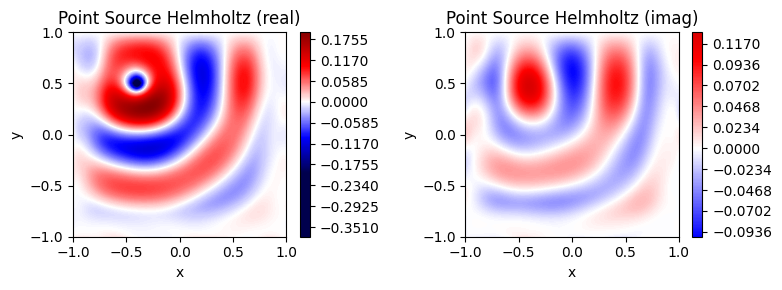

In [26]:
model_pred(model, 1, 1, bar_max=0.2)

In [19]:
import joblib
joblib.dump(model.state_dict(), 'model_batches.joblib')

['model_batches.joblib']

In [20]:
loss_min

0.13517850637435913

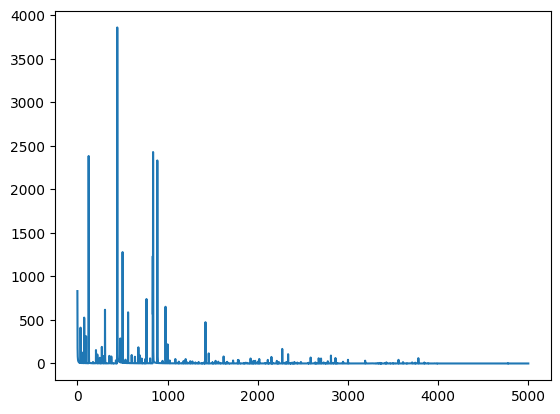

In [21]:
i = 0
loss_list = []
for loss in l_lst:
    loss_list.append(loss.to('cpu').detach().numpy())
np.save('loss.npy', loss_list)
plot_loss(l_lst)

In [22]:
def abs_field(model, Lx, Ly, N=100):
    x, y = torch.linspace(-Lx, Lx, N), torch.linspace(-Ly, Ly, N)
    x, y = torch.meshgrid(x, y)
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    model = model.to('cpu')
    inputs = torch.cat([x, y], dim=-1)
    p_real = model(inputs)[:, 0].detach().numpy()
    p_imag = model(inputs)[:, 1].detach().numpy()
    p_real, p_imag = p_real.reshape(N, N), p_imag.reshape(N, N)
    p = p_real ** 2 + p_imag ** 2

    plt.figure(figsize=(4, 3))
    p_max = np.max(np.abs(p))
    cmap = matplotlib.cm.seismic
    norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
    plt.contourf(x.reshape(N, N), y.reshape(N, N), p, levels=400, cmap=cmap, origin='lower', norm=norm)
    plt.colorbar()
    plt.title('Point Source Helmholtz (real)')
    plt.xlabel('x')
    plt.ylabel('y')

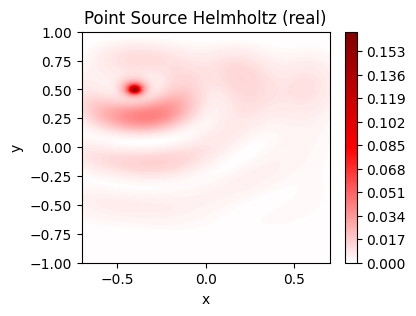

In [23]:
abs_field(model, 0.7, Ly)

Error(Real) 1.4380133152008057, Error(Imag) -0.7763160467147827


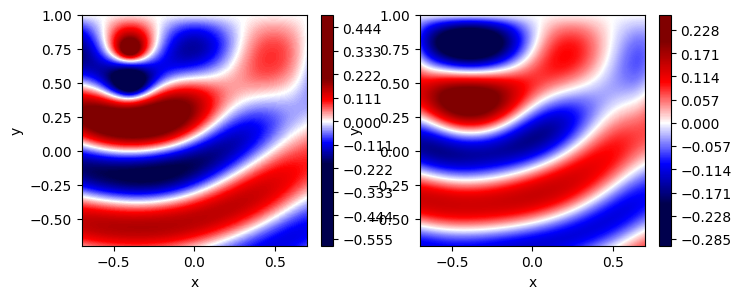

In [24]:
x, y = torch.linspace(-0.7, 0.7, N), torch.linspace(-0.7, 1, N)
x, y = torch.meshgrid(x, y)
x, y = x.reshape(-1, 1), y.reshape(-1, 1)
model = model.to('cpu')
inputs = torch.cat([x, y], dim=-1)
p_real = model(inputs)[:, 0].detach().numpy()
p_imag = model(inputs)[:, 1].detach().numpy()
p_real, p_imag = p_real.reshape(N, N), p_imag.reshape(N, N)

x, y = x.numpy(), y.numpy()
hankel = scipy.special.hankel2(0, k * np.sqrt((x+0.4) ** 2 + (y-0.75) ** 2) + 1e-6) -\
    scipy.special.hankel2(0, k * np.sqrt((x+0.4) ** 2 + (y-1.25) ** 2) + 1e-6)
p_ref = 0.25j * hankel
p_ref_real, p_ref_imag = p_ref.real.reshape(N, N), p_ref.imag.reshape(N, N)

error_real = p_real - p_ref_real
error_imag = p_imag - p_ref_imag

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
p_max = 0.2
cmap = matplotlib.cm.seismic
norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
plt.contourf(x.reshape(N, N), y.reshape(N, N), error_real, levels=400, cmap=cmap, origin='lower', norm=norm)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1, 2, 2)
p_max = 0.2
cmap = matplotlib.cm.seismic
norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
plt.contourf(x.reshape(N, N), y.reshape(N, N), error_imag, levels=400, cmap=cmap, origin='lower', norm=norm)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
print(f"Error(Real) {error_real.mean() / p_ref_real.mean()}, Error(Imag) {error_imag.mean() / p_ref_imag.mean()}")